In [1]:
import tensorflow as tf
import datetime, os
#hide tf logs 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # or any {'0', '1', '2'} 
#0 (default) shows all, 1 to filter out INFO logs, 2 to additionally filter out WARNING logs, and 3 to additionally filter out ERROR logs
import scipy.optimize
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
import time
from pyDOE import lhs         #Latin Hypercube Sampling
import seaborn as sns 
import codecs, json
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error 

# generates same random numbers each time
np.random.seed(1234)
tf.random.set_seed(1234)

print("TensorFlow version: {}".format(tf.__version__))

TensorFlow version: 2.9.1


# *Data Prep*

Training and Testing data is prepared from the solution file

In [2]:
## Data Import
K_real = np.load('./K_tx_real_d_one.npy') # Values of K(t,x)
Q_real = np.load('./Q_15minutes.npy') # Input Matrix of Model
f_real = Q_real[:,1] # Inflow Rate
v_real = Q_real[:,3] # Average Speed
pi_real = np.load('./pitilde_15minutes.npy') # Values of pi(t,x)

In [3]:
pi_real.shape

(150, 2016)

Text(0, 0.5, 'Remaining Trip Distance (miles)')

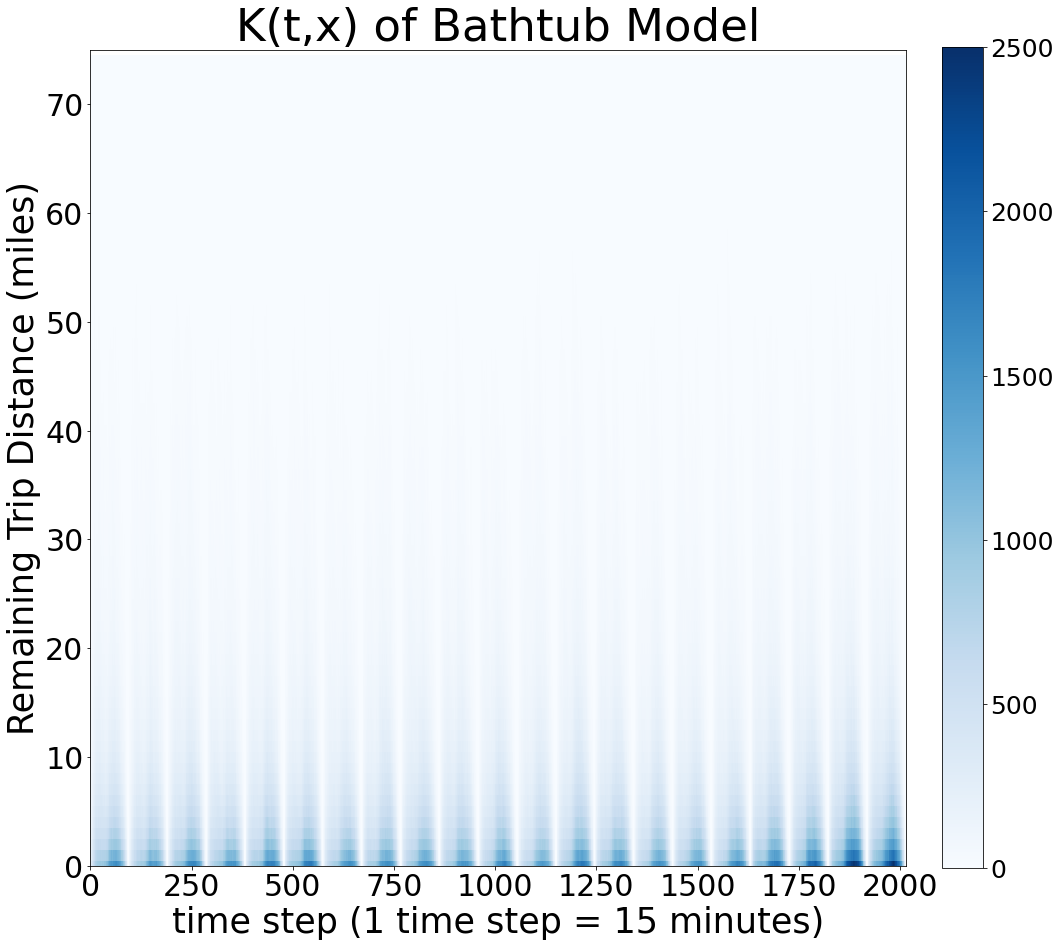

In [4]:
K_array = np.array(K_real[:,0:len(K_real[0])])
fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.T, cmap = 'Blues', interpolation='nearest')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,len(K_real[0])])
plt.clim(0, 2500) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title('K(t,x) of Bathtub Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (miles)', fontsize=35)

In [5]:
## Scale
N_timestep = 24*21*4 # 24 hours * 21 days * 15 minutes = total timestep
N_diststep = 75 # 1 distance step = 1 mile
Size_diststep = 1 # unit: miles
N_trainingdays = 0 # Set zero (0)
N_training = 24*4*N_trainingdays # Training data is all


## Normalization [0,1]
x = np.arange(0,int(N_diststep/Size_diststep))[:,None]   # x: step of remaining distance
t = np.arange(0,N_timestep)[:,None]    # Time step 
usol = K_real.transpose() [:,N_training:]     # real value of K(t,x) ==> Target Variable
usol_max = usol.max()

## Normalization [0,1]
x = (x - x.min()) / (x.max() - x.min())
t = (t - t.min()) / (t.max() - t.min())
f_real = (f_real - usol.min()) / (usol.max() - usol.min())  # usol과 같은 dimension이어야 함. 단위 같기 때문.
v_real = (v_real - v_real.min()) / (v_real.max() - v_real.min())
usol = (usol - usol.min()) / (usol.max()-usol.min())

X, T = np.meshgrid(x,t)                     # makes 2 arrays X and T such that u(X[i],T[j])=usol[i][j] are a tuple


multiplier_dist = int(N_diststep/Size_diststep)-1
multiplier_time = N_timestep-1
multiplier_u = usol_max
print('multiplier distance = ', multiplier_dist)
print('multiplier time = ', multiplier_time)
print('usol max = ', usol_max)

multiplier distance =  74
multiplier time =  2015
usol max =  2500


In [6]:
Size_diststep = 5 # unit: miles
size_input = int(N_diststep/Size_diststep)*N_timestep # Total number of grid points
# size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
N_u = int(size_input*0.2) # Total number of data points for 'u' ==> Training data from grid points
N_f = N_u*2 #Total number of collocation (auxiliary) points 
alpha = 0.5 # weights of loss

print('size input = ', size_input)
print('N_u = ', N_u)
print('N_f = ', N_f)

size input =  30240
N_u =  6048
N_f =  12096


In [7]:
# # Previous version (before Aug 30)
# size_input = int(N_diststep/Size_diststep)*N_timestep # All domain
# # size_input = int(N_diststep/Size_diststep)*2 + N_timestep*7 # Boundary
# N_u = int(size_input*0.5) #Total number of data points for 'u'
# N_f = N_u*2 #Total number of collocation points 
# alpha = 0.5

# print('size input = ', size_input)
# print('N_u = ', N_u)
# print('N_f = ', N_f)

# *Grid Data*

We prepare the grid data to compare against the solution produced by the PINN.

In [8]:
''' X_u_test = [X[i],T[i]] [25600,2] for interpolation'''
X_u_grid = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

# Domain bounds
lb = X_u_grid[0]  # [-1. 0.]
ub = X_u_grid[-1] # [1.  0.99]

'''
   Fortran Style ('F') flatten,stacked column wise!
   u = [c1 
        c2
        .
        .
        cn]

   u =  [25600x1] 
'''
u_grid = usol.flatten('F')[:,None] 

# *Training Data* (All domain)


The boundary conditions serve as the test data for the PINN and the collocation points are generated using **Latin Hypercube Sampling**

In [9]:
def trainingdata(N_u,N_f):

#     '''Boundary Conditions'''

#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 0  
#     leftedge_x = np.hstack((X[0,:][:,None], T[0,:][:,None])) #L1
#     leftedge_u = usol[:,0][:,None]
    
#     #Initial Condition 0 =< x =< 9 (135 miles) and t = 2015  
#     rightedge_x = np.hstack((X[0,:][:,None], T[-1,:][:,None])) #L1
#     rightedge_u = usol[:,-1][:,None]

#     #Boundary Condition x = 9 (135 miles) and 0 =< t =<2015
#     topedge_x = np.hstack((X[:,-1][:,None], T[:,0][:,None])) #L3
#     topedge_u = usol[-1,:][:,None]
        
#     #Boundary Condition x = 0 and 0 =< t =<2015
#     bottomedge_x = np.hstack((X[:,0][:,None], T[:,0][:,None])) #L2
#     bottomedge_u = usol[0,:][:,None]
    
#     #Boundary Condition x = 5 (25 miles) and 0 =< t =<2015
#     midedge_x = np.hstack((X[:,5][:,None], T[:,0][:,None])) #L3
#     midedge_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 10 (50 miles) and 0 =< t =<2015
#     midedge1_x = np.hstack((X[:,10][:,None], T[:,0][:,None])) #L3
#     midedge1_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 15 (75 miles) and 0 =< t =<2015
#     midedge2_x = np.hstack((X[:,15][:,None], T[:,0][:,None])) #L3
#     midedge2_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 20 (100 miles) and 0 =< t =<2015
#     midedge3_x = np.hstack((X[:,20][:,None], T[:,0][:,None])) #L3
#     midedge3_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 25 (125 miles) and 0 =< t =<2015
#     midedge4_x = np.hstack((X[:,25][:,None], T[:,0][:,None])) #L3
#     midedge4_u = usol[-1,:][:,None]
    
#     #Boundary Condition x = 2 and 0 =< t =<2015
#     bottomedge_x_2 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_2 = usol[2,:][:,None]
    
#     #Boundary Condition x = 1 and 0 =< t =<2015
#     bottomedge_x_1 = np.hstack((X[:,1][:,None], T[:,0][:,None])) #L2
#     bottomedge_u_1 = usol[1,:][:,None]


#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x, midedge1_x, midedge2_x, midedge3_x, midedge4_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u, midedge1_u, midedge2_u, midedge3_u, midedge4_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([leftedge_x, rightedge_x, bottomedge_x, topedge_x, midedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([leftedge_u, rightedge_u, bottomedge_u, topedge_u, midedge_u])   #corresponding u [4042,]

#     all_X_u_train = np.vstack([bottomedge_x, bottomedge_x_1, bottomedge_x_2]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, bottomedge_u_1, bottomedge_u_2])   #corresponding u [4042,]
    
#     all_X_u_train = np.vstack([bottomedge_x, topedge_x]) # X_u_train [4042,2] (456 = 10(L1)+2016(L2)+2016(L3))
#     all_u_train = np.vstack([bottomedge_u, topedge_u])   #corresponding u [4042,]

    all_X_u_train = np.hstack((X.T[range(0,N_diststep,Size_diststep)].flatten()[:,None],T.T[range(0,N_diststep,Size_diststep)].flatten()[:,None]))
    all_u_train = usol[range(0,N_diststep,Size_diststep)].flatten()[:,None]
    
    #choose random N_u points for training
    np.random.seed(1234)
    train_idx = np.random.choice(all_X_u_train.shape[0], N_u, replace=False) # ID of training data
    test_idx = np.delete(np.arange(size_input), train_idx) # ID of testing data
    
    # Training Data
    X_u_train = all_X_u_train[train_idx, :] #choose indices from  set 'idx' (x,t)
    u_train = all_u_train[train_idx,:]      #choose corresponding u
    
    # Testing Data
    X_u_test = all_X_u_train[test_idx, :]
    u_test = all_u_train[test_idx,:]

    '''Collocation Points'''

    # Latin Hypercube sampling for collocation points 
    # N_f sets of tuples(x,t)
#     X_f_train = np.rint(lb + (ub-lb)*lhs(2,N_f))
    X_f_train = (lb + (ub-lb)*lhs(2,N_f))
#     X_f_train = np.unique(X_f_train, axis=0).astype(int) # 중복된 것 없앰
    X_f_train = np.vstack((X_f_train, X_u_train)) # append training points to collocation points 
    
    f_t = f_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    pi_tx = pi_real[np.int0(X_f_train*multiplier_dist)[:,0],np.int0(X_f_train*multiplier_time)[:,1]][:,None]
    v_t = v_real[np.int0(X_f_train*multiplier_time)[:,1]][:,None]

    return X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx

In [10]:
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)

In [11]:
X_u_train.shape

(6048, 2)

In [12]:
X_u_test.shape

(24192, 2)

In [13]:
X_u_train

array([[0.        , 0.02630273],
       [0.54054054, 0.8382134 ],
       [0.94594595, 0.23722084],
       ...,
       [0.47297297, 0.98957816],
       [0.06756757, 0.87394541],
       [0.54054054, 0.92704715]])

# **PINN**

Generate a **PINN** of L hidden layers, each with n neurons. 

Initialization: ***Xavier***

Activation: *tanh (x)*

In [14]:
class Sequentialmodel(tf.Module): 
    def __init__(self, layers, name=None):
       
        self.W = []  #Weights and biases
        self.parameters = 0 #total number of parameters
        
        for i in range(len(layers)-1):
            
            input_dim = layers[i]
            output_dim = layers[i+1]
            
            #Xavier standard deviation 
            std_dv = np.sqrt((2.0/(input_dim + output_dim)))

            #weights = normal distribution * Xavier standard deviation + 0
            w = tf.random.normal([input_dim, output_dim], dtype = 'float64') * std_dv
                       
            w = tf.Variable(w, trainable=True, name = 'w' + str(i+1))

            b = tf.Variable(tf.cast(tf.zeros([output_dim]), dtype = 'float64'), trainable = True, name = 'b' + str(i+1))
                    
            self.W.append(w)
            self.W.append(b)
            
            self.parameters +=  input_dim * output_dim + output_dim
    
    def evaluate(self,x):
        
        x = (x-lb)/(ub-lb)
        
        a = x
        
        for i in range(len(layers)-2):
            
            z = tf.add(tf.matmul(a, self.W[2*i]), self.W[2*i+1])
            a = tf.nn.tanh(z)
            
        a = tf.add(tf.matmul(a, self.W[-2]), self.W[-1]) # For regression, no activation to last layer
        return a
    
#     def speed(self,x):
        
#         a = tf.math.minimum(u_free, tf.abs(a_speed/x + b_speed))

#         print('speed = ', a)
#         print('k = ', x)

#         return a
    
    def get_weights(self):

        parameters_1d = []  # [.... W_i,b_i.....  ] 1d array
        
        for i in range (len(layers)-1):
            
            w_1d = tf.reshape(self.W[2*i],[-1])   #flatten weights 
            b_1d = tf.reshape(self.W[2*i+1],[-1]) #flatten biases
            
            parameters_1d = tf.concat([parameters_1d, w_1d], 0) #concat weights 
            parameters_1d = tf.concat([parameters_1d, b_1d], 0) #concat biases
        
        return parameters_1d
        
    def set_weights(self,parameters):
                
        for i in range (len(layers)-1):

            shape_w = tf.shape(self.W[2*i]).numpy() # shape of the weight tensor
            size_w = tf.size(self.W[2*i]).numpy() #size of the weight tensor 
            
            shape_b = tf.shape(self.W[2*i+1]).numpy() # shape of the bias tensor
            size_b = tf.size(self.W[2*i+1]).numpy() #size of the bias tensor 
                        
            pick_w = parameters[0:size_w] #pick the weights 
            self.W[2*i].assign(tf.reshape(pick_w,shape_w)) # assign  
            parameters = np.delete(parameters,np.arange(size_w),0) #delete 
            
            pick_b = parameters[0:size_b] #pick the biases 
            self.W[2*i+1].assign(tf.reshape(pick_b,shape_b)) # assign 
            parameters = np.delete(parameters,np.arange(size_b),0) #delete 

            
    # Loss of data discrepancy
    def loss_BC(self,x,y):

        loss_u = tf.reduce_mean(tf.square(y-self.evaluate(x)))
        return loss_u

    # Loss of physics
    def loss_PDE(self, x_to_train_f, f_t, pi_tx, v_t):
    
        g = tf.Variable(x_to_train_f, dtype = 'float64', trainable = False)
        ft = tf.Variable(f_t,dtype = 'float64', trainable = False)
        pitx = tf.Variable(pi_tx,dtype = 'float64', trainable = False)
        vt = tf.Variable(v_t,dtype = 'float64', trainable = False)
    
        x_f = g[:,0:1]
        t_f = g[:,1:2]

        with tf.GradientTape(persistent=True) as tape:

            tape.watch(x_f)
            tape.watch(t_f)

            g = tf.stack([x_f[:,0], t_f[:,0]], axis=1)   

            z = self.evaluate(g)
            u_x = tape.gradient(z,x_f)

        u_t = tape.gradient(z,t_f)
        
        del tape

        f = u_t - vt*(u_x) - tf.multiply(ft, pitx)
        loss_f = tf.reduce_mean(tf.square(f))

        return loss_f
    
    # total loss
    def loss(self,x,y,g,h,i,k,alpha):

        loss_u = self.loss_BC(x,y)
        loss_f = self.loss_PDE(g,h,i,k)

        loss = alpha*loss_u + (1-alpha)*loss_f

        return loss, loss_u, loss_f
    
    def optimizerfunc(self,parameters):
        
        self.set_weights(parameters)
       
        with tf.GradientTape() as tape:
            tape.watch(self.trainable_variables)
            
            loss_val, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
            
        grads = tape.gradient(loss_val,self.trainable_variables)
                
        del tape
        
        grads_1d = [ ] #flatten grads 
        
        for i in range (len(layers)-1):

            grads_w_1d = tf.reshape(grads[2*i],[-1]) #flatten weights 
            grads_b_1d = tf.reshape(grads[2*i+1],[-1]) #flatten biases

            grads_1d = tf.concat([grads_1d, grads_w_1d], 0) #concat grad_weights 
            grads_1d = tf.concat([grads_1d, grads_b_1d], 0) #concat grad_biases

        return loss_val.numpy(), grads_1d.numpy()
    
    def optimizer_callback(self,parameters):
               
        loss_value, loss_u, loss_f = self.loss(X_u_train, u_train, X_f_train, f_t, pi_tx, v_t, alpha)
        
        u_pred = self.evaluate(X_u_test)
        error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)
        loss_record.append(loss_value)
        l2_record.append(error_vec)
        tf.print(loss_value, loss_u, loss_f, error_vec)
        

# *Model Training and Testing*

A function '**model**' is defined to generate a NN as per the input set of hyperparameters, which is then trained and tested. The L2 Norm of the solution error is returned as a comparison metric

In [15]:
# Training data
X_f_train, X_u_train, u_train, X_u_test, u_test, f_t, pi_tx, v_t, all_X_u_train, all_u_train, train_idx, test_idx  = trainingdata(N_u,N_f)
#alpha = int(N_f/N_u) #weight of loss function

layers = np.array([2,10,10,10,10,1]) #8 hidden layers
loss_record = []
l2_record = []

PINN = Sequentialmodel(layers)

init_params = PINN.get_weights().numpy()

start_time = time.time() 

# train the model with Scipy L-BFGS optimizer
results = scipy.optimize.minimize(fun = PINN.optimizerfunc, 
                                  x0 = init_params, 
                                  args=(), 
                                  method='L-BFGS-B', 
                                  jac= True,        # If jac is True, fun is assumed to return the gradient along with the objective function
                                  callback = PINN.optimizer_callback, 
                                  options = {'disp': None,
                                            'maxcor': 100, 
                                            'ftol': 1 * np.finfo(float).eps,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
#                                             'ftol': 1e-10,  #The iteration stops when (f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1} <= ftol
                                            'gtol': 1e-10, 
                                            'maxfun':  50000, 
                                            'maxiter': 15000,
                                            'iprint': -1,   #print update every 50 iterations
                                            'maxls': 50})
end_time = time.time()

0.0187162300214013 0.035893498902428461 0.001538961140374138 1.4349683529807957
0.012573586474136214 0.022858464297914279 0.00228870865035815 1.154680697616407
0.011160161690470278 0.020600109787172183 0.0017202135937683714 1.097539759660823
0.010335078326840922 0.019157058978027459 0.0015130976756543844 1.0588926907829856
0.0075074585644347921 0.013856193291580164 0.0011587238372894196 0.9010287482033482
0.0058609229287637007 0.010490606525597312 0.00123123933193009 0.7837781533736005
0.0054873318108891759 0.0096885551385166736 0.0012861084832616785 0.7537142642539546
0.0054721688668926379 0.0096607818087729828 0.0012835559250122931 0.7528359871728365
0.0054587146987216187 0.0096522411937675009 0.0012651882036757362 0.7527170415657061
0.0054236803546022618 0.0096532720550379023 0.001194088654166622 0.753142779179766
0.0053567351543607955 0.00967408565018447 0.0010393846585371219 0.7544070974793599
0.0052512620357217177 0.00968772583408265 0.00081479823736078645 0.7552974017691861
0.00

0.0032312220354453747 0.0055646901346279318 0.00089775393626281787 0.5773852910710798
0.0032303363538021771 0.0055832808361384609 0.000877391871465893 0.5782899231527134
0.00322934349114657 0.0055529609689193 0.00090572601337383994 0.5767690631152557
0.0032284870596747594 0.0055745967342081485 0.00088237738514137035 0.5779047553531539
0.0032275395251904395 0.0055744847133989408 0.00088059433698193786 0.5778407722422874
0.0032271203681749593 0.005552854222165263 0.00090138651418465536 0.5767189911292586
0.0032261226857452814 0.0055620283939184544 0.000890216977572108 0.5771754384089594
0.0032255334875986221 0.0055698569421530628 0.00088121003304418132 0.5775771437865828
0.0032244505436901986 0.0055658695474662652 0.0008830315399141319 0.5773806107370985
0.00322340927556463 0.0055483616191340217 0.00089845693199523864 0.5764587027345169
0.0032229511999706758 0.0055526431253178736 0.00089325927462347769 0.5766382389129747
0.003222736642753259 0.0055377612597706273 0.0009077120257358906 0.

0.0031799505580204046 0.005452928679921391 0.00090697243611941784 0.5710007811244934
0.0031797555894698473 0.005452865764885839 0.00090664541405385531 0.5709741270370587
0.0031796542569879145 0.0054563159556428016 0.0009029925583330272 0.5711425393956193
0.0031795464871889447 0.0054564436731159684 0.00090264930126192117 0.5711529439340838
0.0031794670638010235 0.00545591604070474 0.00090301808689730739 0.5711251302441132
0.0031793443704761669 0.0054584081514554494 0.000900280589496884 0.5712547827086988
0.0031792898272452446 0.005448003816567527 0.00091057583792296252 0.5707137036683325
0.0031791713256226635 0.0054516619416536205 0.00090668070959170623 0.570904911941545
0.0031789734277903369 0.0054564550112866476 0.00090149184429402633 0.5711496298189889
0.0031787963405230939 0.0054605632363515762 0.00089702944469461168 0.5713572890608939
0.0031785217575687995 0.0054656136012364376 0.00089142991390116168 0.5716105744524878
0.0031782047233166067 0.0054692338259652454 0.00088717562066796

0.0031698332894682791 0.0054358720693162251 0.00090379450962033332 0.5697984260312351
0.003169789805375483 0.0054322387787257669 0.00090734083202519882 0.5696216131875326
0.0031697420889907945 0.0054302300898279561 0.0009092540881536328 0.5695080189342712
0.0031696953142371972 0.00543183219268349 0.00090755843579090449 0.5695801757562036
0.0031696219047511257 0.0054312976725174045 0.00090794613698484661 0.5695338663193066
0.0031695229915209133 0.0054359124010841461 0.0009031335819576808 0.5697826799644362
0.003169442045503487 0.0054378877899632057 0.0009009963010437683 0.5698943075371735
0.003169323327079259 0.00543438187831912 0.00090426477583939772 0.5697073913166693
0.0031691972116831986 0.00542881879223386 0.00090957563113253689 0.5694301368323156
0.0031691543212954091 0.0054294790144975629 0.00090882962809325568 0.5694515872599328
0.0031690624801915539 0.0054376006721479648 0.00090052428823514266 0.5698722034040141
0.003168926465491724 0.00543291495487412 0.00090493797610932778 0.

0.0031420983860619149 0.0053777670104069733 0.00090642976171685674 0.5667886037529797
0.0031415661005430684 0.0053693283016561736 0.00091380389942996283 0.5663647817376439
0.0031414821473101638 0.0053922668939416019 0.00089069740067872574 0.5675832793675931
0.00314122795089608 0.0053722390214266426 0.0009102168803655174 0.5665131767348808
0.0031409082343798194 0.0053734896558846872 0.00090832681287495169 0.5665914384226303
0.003140731661379239 0.0053731155692818156 0.00090834775347666214 0.5665722624995866
0.0031405339672715442 0.0053745094347542495 0.0009065584997888388 0.5666561500504439
0.0031400755723813888 0.00537409227147233 0.0009060588732904475 0.5666380119318051
0.0031394682031493058 0.0053770960249425225 0.00090184038135608874 0.5667786283886567
0.003138613794134749 0.0053837018299203 0.000893525758349198 0.5669977256724794
0.0031381816198531049 0.0053893823803944745 0.00088698085931173526 0.5674489708703763
0.0031380705064394058 0.0053698045559857025 0.00090633645689310938 0

0.0031214809331035561 0.0053631518182937913 0.00087981004791332117 0.5658465756128475
0.0031214278220537853 0.005363556670959127 0.00087929897314844316 0.5658601300761876
0.0031212338558555468 0.00536506222445894 0.00087740548725215371 0.5659060424673904
0.0031210091494503584 0.0053644361009687214 0.00087758219793199557 0.5658530863871527
0.0031206218920389597 0.0053746305092017468 0.00086661327487617219 0.5664158652495065
0.0031203221042193923 0.0053473730338076553 0.00089327117463112885 0.5649313585057023
0.0031197332257191161 0.0053645544115742 0.00087491203986403215 0.565847790086483
0.0031194276758709874 0.0053773761071128938 0.00086147924462908084 0.5664971094243674
0.0031192109740491784 0.0053656665270392532 0.00087275542105910361 0.5658378598918182
0.0031188675929119678 0.0053673977066265761 0.00087033747919735909 0.5659191973601466
0.0031185504004329484 0.0053684076095726306 0.00086869319129326587 0.5660037665774533
0.0031183582431162688 0.005365404333502917 0.0008713121527296

0.0030966042070735035 0.0053526213125947505 0.00084058710155225614 0.5647847394550229
0.0030963412937596987 0.0053467887934769281 0.00084589379404246916 0.5644574229583852
0.0030959993928614594 0.0053339697463239272 0.00085802903939899151 0.5637713386173174
0.0030956402760566513 0.00533667121975059 0.00085460933236271243 0.5638955410037562
0.0030953674838190364 0.0053393902522129765 0.00085134471542509663 0.564022311402858
0.0030950610701926322 0.0053378215321119 0.00085230060827336425 0.5639220073265699
0.0030948464565786721 0.0053296573167388147 0.00086003559641852946 0.5634975662245173
0.0030946320235570313 0.0053295877893308769 0.00085967625778318561 0.563575267735419
0.0030944734898943602 0.0053316443187560805 0.00085730266103263965 0.5636727640134365
0.0030940990440872589 0.0053365262888141344 0.00085167179936038336 0.5639660530437318
0.0030935496078611569 0.0053299718457826611 0.000857127369939653 0.5636109625240464
0.0030930389352265496 0.0053336557936489327 0.00085242207680416

0.0030715869423693669 0.0052922126713989505 0.00085096121333978335 0.5617493286226037
0.0030713453015398027 0.0052868476782433685 0.00085584292483623667 0.5614829795839151
0.0030711535782658 0.0052891607346731212 0.00085314642185847875 0.5615425337496656
0.0030707871116339961 0.0052915762867263988 0.00084999793654159353 0.5617023471499759
0.0030705955400211682 0.005281679328224086 0.00085951175181825064 0.5611450251498895
0.0030705523899051232 0.0052818330856403877 0.00085927169416985885 0.5611794675898997
0.0030704198844152064 0.0052912949451372768 0.00084954482369313652 0.5616896186367156
0.0030702090401037527 0.0052854314258535167 0.00085498665435398882 0.5613926377316605
0.0030701280946833212 0.0052819344694680272 0.00085832171989861522 0.5611728706825921
0.003070079050286272 0.0052818248282756426 0.00085833327229690125 0.5612071867587569
0.0030700093806547888 0.0052812126428174256 0.00085880611849215179 0.5611720701824103
0.0030699569892167064 0.0052807391846276235 0.0008591747938

0.003056809361924396 0.0052773025732600681 0.00083631615058872414 0.560772537753337
0.0030567442860854458 0.0052782137333285918 0.0008352748388423 0.5608289191096194
0.0030566883685518159 0.005276061391134272 0.00083731534596936019 0.5607189893524812
0.0030566377002216555 0.0052749077946651884 0.00083836760577812256 0.5606672454498095
0.0030565672606165323 0.0052718542947287695 0.00084128022650429483 0.5604960344764666
0.0030564652683375704 0.0052706002719504572 0.00084233026472468344 0.5604463870092032
0.003056408136905173 0.005272205580518911 0.00084061069329143521 0.5605381099602478
0.0030563598588135769 0.0052731871258420342 0.00083953259178511986 0.5605741478197476
0.0030562824537978604 0.0052790194064903234 0.00083354550110539729 0.5608990680054489
0.0030562184634717431 0.005274970873944405 0.00083746605299908118 0.5606548442119859
0.0030561661784380884 0.0052751324781213794 0.00083719987875479783 0.5606606676401795
0.0030561446415327122 0.0052774522997739689 0.000834836983291455

0.0030392468597657562 0.0052261802280082637 0.00085231349152324837 0.5582159691724365
0.0030392153885080635 0.0052273606133307095 0.00085107016368541743 0.5582753646537585
0.0030391884949020173 0.0052269713669871624 0.00085140562281687258 0.5582459710427901
0.00303913714763296 0.0052276140330838085 0.00085066026218211124 0.5582796640821228
0.0030390720138080982 0.0052264100605603084 0.00085173396705588808 0.5582316611994133
0.0030389735780821598 0.0052262555839688706 0.00085169157219544935 0.5582335291371042
0.0030388911430104496 0.0052249220284872637 0.00085286025753363536 0.5581751203123886
0.0030388031388132565 0.0052295031631433469 0.00084810311448316634 0.5584882128656926
0.0030386474513292663 0.0052313189081189754 0.000845975994539557 0.5585632849237072
0.0030385795412080294 0.0052303056096431313 0.00084685347277292785 0.5584975359226491
0.0030385569218151476 0.0052269906526806065 0.00085012319094968851 0.5583133384895532
0.0030384260059081376 0.005225069785267703 0.0008517822265

0.0030337480550833465 0.0052243729531441336 0.00084312315702255922 0.5581944343667166
0.0030337318778185158 0.0052246923677123046 0.00084277138792472693 0.5581984894804812
0.0030337145717995559 0.0052255860595353471 0.00084184308406376484 0.5582431384620311
0.003033707917765258 0.0052270936612554631 0.000840322174275053 0.5583113024096839
0.003033693856627607 0.0052274572320968656 0.00083993048115834875 0.5583328799891436
0.0030336808152742522 0.0052257090116535664 0.00084165261889493793 0.5582488320165057
0.0030336646324253085 0.0052249279954992246 0.00084240126935139275 0.5582022328718156
0.0030336400879205578 0.0052242736728189566 0.00084300650302215874 0.558163587638618
0.0030336248686903136 0.0052238801117653281 0.00084336962561529943 0.5581513076924393
0.003033584621039755 0.0052228100484593819 0.00084435919362012822 0.5580969726577876
0.0030335486564276792 0.005222913244439192 0.0008441840684161665 0.5581010103298544
0.0030334669137925827 0.0052234669507655231 0.0008434668768196

0.0030297430758611989 0.0052104865047502349 0.000848999646972163 0.5573725295510666
0.003029669348453628 0.0052104630404065924 0.00084887565650066331 0.5573755280703998
0.0030295920694387748 0.0052092922330388225 0.00084989190583872735 0.5573298147741902
0.003029544531965802 0.0052078893383071456 0.00085119972562445871 0.5572439202056889
0.0030294706259011272 0.0052066633949534712 0.00085227785684878358 0.5571627828357935
0.00302939042623518 0.0052077830233895582 0.00085099782908080112 0.5572095170222847
0.0030293436606492227 0.0052090929527169655 0.00084959436858148 0.5572849930676587
0.0030292773632691469 0.0052101556442084107 0.00084839908232988326 0.5573228697423308
0.0030291974987375595 0.0052111643011178883 0.0008472306963572307 0.5573759719699487
0.0030291434430406751 0.0052105134611391424 0.00084777342494220774 0.5573489334536332
0.0030290795116608015 0.0052123085500732844 0.00084585047324831823 0.5574443346034139
0.003029045554431981 0.0052120619013751486 0.0008460292074888131

0.0030212931366012806 0.0051706477194166369 0.00087193855378592451 0.5553138140820181
0.0030212786857853821 0.0051710128811385354 0.00087154449043222915 0.5553334714326511
0.0030212680050553274 0.0051707232745232127 0.00087181273558744211 0.5553136595923153
0.0030212550803551687 0.0051705767194778146 0.000871933441232523 0.5553035317978295
0.0030212457816286985 0.0051707942253602333 0.00087169733789716386 0.5553065710630262
0.0030212395277827973 0.0051702211621566293 0.00087225789340896528 0.5552703848034226
0.0030212322761611747 0.0051708333012775928 0.00087163125104475648 0.5553019403966918
0.003021227250540685 0.0051712635804316487 0.00087119092064972137 0.5553236463827057
0.0030212226506327964 0.0051713075293301439 0.00087113777193544863 0.5553265533814755
0.0030212158259751527 0.0051711129531283491 0.00087131869882195608 0.5553147285201347
0.0030212066367881481 0.0051712551120206875 0.00087115816155560876 0.5553226526398616
0.0030211934709483013 0.0051705820210091232 0.00087180492

0.0030160988910923115 0.005154293639704168 0.000877904142480455 0.5544435757726885
0.0030160852486135234 0.0051544263834419528 0.00087774411378509427 0.5544460769439774
0.0030160569882811033 0.0051545323136616451 0.00087758166290056127 0.5544554615051647
0.0030160279601245347 0.0051553186533011336 0.00087673726694793592 0.5544965141457003
0.0030159609312233621 0.0051559245180743266 0.000875997344372398 0.5545360718852776
0.0030157776869434768 0.0051539626271498587 0.00087759274673709464 0.5544513102180404
0.0030156845671985935 0.0051552965938118662 0.00087607254058532052 0.5545539910093799
0.0030156549136447289 0.0051557879829159936 0.00087552184437346393 0.554570813731057
0.0030155511770724517 0.0051547211406738876 0.0008763812134710159 0.5545075912987679
0.003015437841507282 0.005150135425221262 0.0008807402577933022 0.5542503870225814
0.0030154052469045468 0.0051496927398234004 0.0008811177539856936 0.5542747827479009
0.0030153453785811382 0.0051487923610235575 0.0008818983961387191

0.0030111563888796078 0.0051410937176930025 0.00088121906006621311 0.5538916995385098
0.003011126867092046 0.005140831868590769 0.00088142186559332311 0.5538790518439
0.0030110938741014577 0.0051392767366567581 0.00088291101154615759 0.5537966776969613
0.0030110746538146204 0.005139538776297429 0.00088261053133181137 0.5538189127816368
0.00301105944810161 0.0051388234743352931 0.00088329542186792707 0.5537767310114128
0.0030110478206061032 0.0051378927050756661 0.00088420293613654052 0.5537379195293176
0.0030110413334505856 0.00513834388546657 0.000883738781434601 0.5537638003876563
0.003011032387294867 0.0051381808862085007 0.00088388388838123307 0.5537500629985459
0.0030110242448907307 0.0051378503957524076 0.00088419809402905363 0.55373194425012
0.0030110012443711216 0.0051383635266363638 0.00088363896210587908 0.5537604023458489
0.0030109752350709483 0.0051392995815465435 0.00088265088859535335 0.5538053322769219
0.0030109359023556014 0.0051402763351167235 0.00088159546959447907 0.

0.0030076194501705896 0.00513004790305043 0.000885190997290749 0.5533153581992115
0.00300759797423961 0.0051318099365393992 0.00088338601193982034 0.553416809912017
0.0030075554014250489 0.00513244962003755 0.000882661182812548 0.5534507126178292
0.0030075230810340126 0.0051341384747369866 0.00088090768733103876 0.5535236422673698
0.0030074929377127092 0.0051333947120646029 0.00088159116336081536 0.5534932366788791
0.0030074009171780383 0.0051337696225328688 0.00088103221182320786 0.5535011934786198
0.0030073200566963069 0.0051330489910067422 0.00088159112238587144 0.5534593790906576
0.0030072752282040908 0.0051306740282335422 0.00088387642817463943 0.5533440418438416
0.0030071801949771021 0.0051299537700833292 0.00088440661987087459 0.5532866529817858
0.0030070757599972619 0.0051269229519213611 0.00088722856807316262 0.5531231791869421
0.0030070036149082891 0.0051265378925943374 0.00088746933722224036 0.5531146250101838
0.003006937196499305 0.0051284854979868942 0.00088538889501171554

0.0030031716416983817 0.0051235385033497807 0.0008828047800469829 0.5529146284723413
0.0030031457147758323 0.0051200483593960384 0.0008862430701556262 0.5527305533784969
0.0030031254902675554 0.0051195249582710193 0.0008867260222640914 0.5527084198928731
0.0030030975993565337 0.0051199506330373559 0.00088624456567571179 0.5527297513015473
0.0030030696206126131 0.005120401542649115 0.00088573769857611118 0.552754017682616
0.0030030310933521986 0.0051198206889522656 0.00088624149775213136 0.5527182965746302
0.0030029967081793957 0.005119086705613141 0.00088690671074565083 0.5526772635737424
0.0030029588757497978 0.0051200737399743727 0.00088584401152522272 0.5527301975909971
0.0030029364847340787 0.00512289073414335 0.00088298223532480731 0.5528720210556437
0.0030029085589339307 0.005123393681095734 0.0008824234367721276 0.5529038820798148
0.0030028770492669336 0.0051223918798348634 0.00088336221869900341 0.5528537806486047
0.0030027965949905862 0.0051189828300836947 0.000886610359897478

0.0030009536761821123 0.00511488195792967 0.0008870253944345543 0.5524496594676137
0.0030009514434885453 0.0051144005669593855 0.00088750232001770534 0.552421672117373
0.0030009440407054635 0.0051140212571950793 0.00088786682421584766 0.5524030836890027
0.0030009251877856948 0.005113577167309773 0.000888273208261616 0.5523793519297044
0.0030009012787540505 0.0051137635293607127 0.00088803902814738793 0.5523932756364079
0.0030008668124244303 0.0051133905293583234 0.00088834309549053734 0.5523691940169346
0.0030008339324466547 0.0051136480307535474 0.00088801983413976224 0.5523907657894999
0.0030008079106593863 0.0051153374436242209 0.00088627837769455207 0.5524892866546501
0.0030007648761316381 0.0051142498712342345 0.00088727988102904208 0.5524365901041876
0.0030007358879745936 0.0051142579026069558 0.00088721387334223163 0.5524442900161048
0.0030007280414560428 0.0051155455132014865 0.00088591056971059918 0.5525102580685758
0.0030007027419171059 0.0051137015249025789 0.000887703958931

0.0029999087383994422 0.0051204292078008504 0.00087938826899803385 0.5527134833766308
0.0029998689353538657 0.005118219530388139 0.00088151834031959192 0.5525922100518795
0.0029998573447610633 0.0051172139631831754 0.00088250072633895083 0.5525479389875916
0.0029998249379072067 0.0051165514945507818 0.00088309838126363115 0.5525050130512363
0.0029998119312017856 0.0051158528283297214 0.00088377103407384964 0.5524657134550285
0.0029997968914974808 0.0051156456866211075 0.00088394809637385417 0.5524517762621635
0.0029997756558163844 0.0051146753772336124 0.00088487593439915682 0.5524061316791199
0.002999749452895265 0.0051160724658442843 0.00088342643994624586 0.552481868044253
0.002999729975181381 0.0051167081263797974 0.00088275182398296463 0.5525114221421181
0.0029997185055816548 0.0051166562629225854 0.00088278074824072448 0.5525103866972396
0.0029996937619287734 0.0051158272374144213 0.00088356028644312565 0.5524551948020162
0.0029996518975788909 0.0051145894728360716 0.000884714322

0.0029985888217681153 0.00510798425109928 0.00088919339243695059 0.5520178469599704
0.0029985837530689913 0.0051087819414411218 0.00088838556469686067 0.5520602846059796
0.0029985788188816608 0.0051096338335598727 0.00088752380420344882 0.5521076887391323
0.0029985767050554456 0.0051104561488212038 0.00088669726128968735 0.5521517464068064
0.0029985738386455007 0.0051108491251589923 0.00088629855213200916 0.5521716117748943
0.0029985704295151842 0.00511062512599539 0.00088651573303497825 0.5521584236051099
0.0029985684707456929 0.0051101217713716068 0.00088701517011977894 0.552129288884744
0.0029985663735443068 0.0051101913170914 0.00088694142999721376 0.5521326129466181
0.0029985627343376881 0.0051103412479729261 0.00088678422070245029 0.5521387552580389
0.0029985603169110633 0.0051104220369441664 0.00088669859687795993 0.5521443096288223
0.0029985564482578149 0.0051103840187369512 0.00088672887777867823 0.5521432738677117
0.0029985543619700183 0.0051103288271367488 0.0008867798968032

0.0029957501947530576 0.0051130408586281661 0.00087845953087794886 0.5522734248496035
0.0029957179057191604 0.00511381169746688 0.00087762411397144125 0.552315563096957
0.0029956952513485392 0.0051129951402370949 0.0008783953624599836 0.5522765073478904
0.0029956681259569796 0.005113509081579007 0.00087782717033495238 0.5522969752193476
0.0029956351524616795 0.005113071759584956 0.00087819854533840276 0.5522758848845263
0.002995604556200735 0.0051118240201957392 0.00087938509220573079 0.552208267333547
0.0029955922824784122 0.0051115141666261583 0.00087967039833066569 0.5522002789197661
0.0029955785622303062 0.0051117872559924881 0.00087936986846812463 0.5522153412115793
0.0029955673744606363 0.0051118130882476884 0.00087932166067358427 0.5522121221782683
0.0029955571682742555 0.0051106016909977792 0.00088051264555073165 0.5521444567562284
0.00299555323632432 0.00511066696621521 0.00088043950643343046 0.5521453773419829
0.0029955435037379375 0.0051108872587668427 0.00088019974870903229

0.0029950472098385877 0.0051062893481013489 0.00088380507157582674 0.5519185899258762
0.002995044078918947 0.0051054993938475313 0.00088458876399036257 0.5518749637410028
0.002995042812753724 0.0051056644918422087 0.00088442113366523929 0.551885930204511
0.0029950420253713208 0.0051057657096885822 0.00088431834105405938 0.5518908449201889
0.0029950410063159733 0.005105743535895154 0.00088433847673679211 0.551890554757732
0.0029950400626580546 0.0051057014785937356 0.00088437864672237315 0.5518876625655333
0.0029950384660464625 0.0051056699040430585 0.00088440702804986671 0.5518853167308382
0.0029950380521392649 0.005105636178714487 0.00088443992556404294 0.5518845000271988
0.002995036347900883 0.00510553642233387 0.00088453627346789568 0.5518783750283807
0.0029950342183243006 0.0051053903768981529 0.00088467805975044815 0.5518701235927851
0.0029950333161440561 0.0051056611313693738 0.00088440550091873813 0.551883453986633
0.0029950305539096236 0.005105573381111477 0.0008844877267077699

0.0029946515655443285 0.0051022179138196025 0.00088708521726905433 0.5516673812968993
0.0029946504640417267 0.0051022064657359669 0.00088709446234748663 0.5516659532914906
0.0029946488727047491 0.00510225349238981 0.00088704425301968856 0.5516684059294118
0.0029946469750414266 0.0051023993142420773 0.00088689463584077624 0.5516770385524603
0.0029946463720967255 0.0051026181468256052 0.00088667459736784568 0.5516890333400152
0.0029946434472062919 0.0051027146214272512 0.000886572272985333 0.5516969846052528
0.0029946416837862825 0.0051032206161856488 0.000886062751386916 0.5517231724947681
0.0029946403374078584 0.0051032379450374078 0.00088604272977830937 0.5517264821885934
0.0029946389611636378 0.0051031700473885494 0.0008861078749387262 0.5517208633168607
0.0029946374484310962 0.0051030997533736949 0.00088617514348849778 0.5517160512746537
0.0029946348958518262 0.0051028933580675095 0.00088637643363614264 0.5517035584077199
0.0029946333087989907 0.0051023660614790429 0.000886900556118

0.0029934792708904354 0.0051009018639805283 0.00088605667780034284 0.5516127240450869
0.002993475529220628 0.0051006734136482814 0.000886277644792975 0.5515985075342671
0.0029934715439819039 0.0051005265132679908 0.00088641657469581676 0.5515913984893122
0.00299346542851904 0.0051011645553908982 0.00088576630164718148 0.5516261724552541
0.0029934561859794795 0.0051007984180044463 0.00088611395395451272 0.5516051629591039
0.0029934481009438476 0.0050999957018833105 0.00088690050000438483 0.551565673517506
0.0029934438142779135 0.0051001288893482251 0.00088675873920760232 0.5515727337430886
0.0029934404137877168 0.0050996807208709815 0.0008872001067044519 0.5515490891529397
0.00299343713002039 0.0050997848934066278 0.00088708936663415248 0.5515582938243039
0.0029934350181076478 0.0051002983116024561 0.00088657172461283973 0.5515856142612281
0.0029934319990798162 0.0051009820105222779 0.00088588198763735421 0.5516237181077848
0.0029934305286911495 0.0051013930079044324 0.00088546804947786

0.0029930469391130769 0.0051067266815003134 0.00087936719672584041 0.5519020961107733
0.0029930463298383295 0.0051065673503221795 0.00087952530935447967 0.5518941087325052
0.0029930457883405462 0.0051063613698454731 0.0008797302068356196 0.551883946832664
0.0029930453666965669 0.0051063384911802156 0.00087975224221291783 0.5518828257676556
0.0029930441532086691 0.0051061496566281658 0.0008799386497891728 0.5518724645032611
0.0029930428320886311 0.0051064634684364809 0.00087962219574078148 0.5518907559600842
0.0029930416608775975 0.0051065244703622087 0.0008795588513929865 0.5518961487934098
0.0029930409924796429 0.0051066153772057745 0.000879466607753511 0.5519024717659492
0.0029930405582261703 0.0051066198307251785 0.00087946128572716209 0.551903435850351
0.0029930399388330862 0.0051066482869129969 0.00087943159075317583 0.5519051631626211
0.0029930391483189074 0.005106632323624293 0.00087944597301352161 0.551903927145955
0.002993038990579251 0.0051065873752144256 0.000879490605944076

0.0029926335774043428 0.0051055511876089863 0.00087971596719969977 0.5518429607160502
0.0029926323873626145 0.005105355543273335 0.00087990923145189357 0.5518339211522285
0.0029926311323001378 0.00510536624685127 0.00087989601774900487 0.551833995171192
0.0029926300520008793 0.0051054512083785857 0.00087980889562317322 0.5518385659936342
0.0029926292453424197 0.0051054829453196166 0.00087977554536522256 0.551838736503413
0.0029926276733356072 0.0051055909847984452 0.00087966436187276878 0.5518452314316079
0.0029926246159678932 0.0051057418690376166 0.00087950736289816949 0.5518539222005077
0.0029926208317895978 0.005105739220757537 0.00087950244282165835 0.5518511925530889
0.0029926157451331111 0.0051060016494509529 0.00087922984081526977 0.5518629012929877
0.0029926091846832108 0.00510559843925707 0.0008796199301093514 0.5518375343080917
0.0029925977315931824 0.00510589525339921 0.00087930020978715516 0.5518468074918712
0.0029925873280429805 0.0051067949938785172 0.000878379662207444 

0.0029917069751970323 0.0051027154046070352 0.00088069854578702968 0.5517090269867584
0.0029916945994939558 0.0051033974896202705 0.00087999170936764112 0.551739225609074
0.0029916852397134405 0.005103964454214141 0.00087940602521274 0.5517585822363279
0.0029916734123112305 0.0051033092395032925 0.000880037585119169 0.5517254285680083
0.0029916580034076773 0.0051041517688753934 0.00087916423793996123 0.551780822866961
0.0029916522921816422 0.0051052705865605487 0.00087803399780273569 0.5518459174333142
0.0029916396117524629 0.0051050441165706242 0.00087823510693430125 0.5518359233606153
0.0029916324512455606 0.0051043608911565076 0.00087890401133461392 0.5518015170638413
0.0029916273811671982 0.0051040059072577715 0.00087924885507662529 0.5517785225626205
0.0029916209401636995 0.0051042720276775729 0.00087896985264982635 0.5517933010735364
0.0029916150793276768 0.005104202352482508 0.00087902780617284549 0.5517915989694023
0.0029916053067719768 0.0051045694409229229 0.00087864117262103

0.0029911353188989565 0.0051032561048627439 0.00087901453293516866 0.55172532252842
0.0029911346125771386 0.0051032338475820692 0.00087903537757220789 0.551723772051051
0.0029911334265577579 0.0051030647404767659 0.0008792021126387495 0.5517155886914701
0.0029911329477355806 0.0051030131485317268 0.00087925274693943475 0.5517129785872334
0.002991132060518271 0.0051030175592129629 0.00087924656182357939 0.551711912186563
0.0029911318166199012 0.00510300677164839 0.0008792568615914125 0.5517124309183152
0.0029911310223718177 0.0051031474344503305 0.00087911461029330522 0.5517184520999825
0.0029911304244080168 0.0051032867343508486 0.0008789741144651853 0.5517250160048002
0.0029911292670657236 0.0051034692927275334 0.00087878924140391361 0.5517340688133506
0.0029911277332797821 0.0051034766219414463 0.00087877884461811751 0.5517345600609538
0.0029911248216574187 0.0051032334369228854 0.00087901620639195229 0.5517239316522502
0.0029911238967231446 0.0051031240038959987 0.000879123789550290

0.00299068678883847 0.0051047524195178082 0.00087662115815913147 0.5518339893993109
0.0029906473183065369 0.0051003805701243269 0.00088091406648874659 0.5516144586504118
0.00299061561368299 0.0051002882755948409 0.00088094295177113956 0.5516092039684227
0.0029905559549811586 0.00509968446927765 0.00088142744068466731 0.5515745480965396
0.0029905320447789659 0.0050989781194001925 0.00088208597015773877 0.5515420145886982
0.0029905086999044233 0.0050984003701271558 0.00088261702968169041 0.5515090209165726
0.0029904810618966303 0.0050985990557722389 0.00088236306802102181 0.5515114237538641
0.0029904207072479335 0.0050978470443435548 0.00088299437015231246 0.551464305080036
0.0029904135751426561 0.0050981422048669185 0.00088268494541839375 0.5514766042990678
0.0029903967801661628 0.0050985687713418285 0.0008822247889904971 0.5514888000349688
0.0029903586706222628 0.0050993102620880189 0.0008814070791565064 0.5515342162734072
0.0029903492967690241 0.005098540036279269 0.000882158557258779

0.0029894396319243934 0.0050943800267251056 0.00088449923712368155 0.5512818416868926
0.002989423384504955 0.0050948046304068037 0.00088404213860310624 0.5513042903686947
0.0029894139868360883 0.0050948496785662477 0.00088397829510592852 0.5513036075870998
0.0029894000896138421 0.0050941560947788877 0.000884644084448796 0.5512604554473315
0.0029893814184126237 0.0050944511939874995 0.0008843116428377477 0.5512758938130977
0.0029893661708715815 0.005093395334831584 0.00088533700691157909 0.5512212526184136
0.0029893543885144923 0.005094200781289175 0.0008845079957398096 0.5512622616961572
0.0029893505295734164 0.005094094519159641 0.00088460653998719181 0.551260591619616
0.0029893378576201406 0.0050938164132647784 0.00088485930197550276 0.5512552939926919
0.0029893292872041795 0.0050948199041262552 0.0008838386702821042 0.5513113333891408
0.0029893240206116632 0.0050955343811738179 0.00088311366004950858 0.5513492712914936
0.0029893162315646621 0.00509597976907519 0.00088265269405413376

0.0029888794246023865 0.0050925264490775807 0.000885232400127192 0.551196141013111
0.0029888732543579422 0.0050932494638662677 0.00088449704484961657 0.5512410866368366
0.0029888669014456262 0.0050934876609919563 0.00088424614189929656 0.5512506458253934
0.0029888622456205154 0.0050929940666772549 0.00088473042456377587 0.5512191942629744
0.0029888503452085418 0.0050933625902468025 0.00088433810017028085 0.5512379546574828
0.0029888420946410994 0.0050926529322539923 0.00088503125702820633 0.5511977139129488
0.0029888373440587583 0.0050936354921205674 0.00088403919599694923 0.5512498367793673
0.0029888289939498012 0.0050940264587705291 0.00088363152912907309 0.5512650157487475
0.0029888245185106868 0.0050933384229710768 0.00088431061405029729 0.5512265674637354
0.0029888206328777577 0.0050930382937635337 0.00088460297199198176 0.551208382301035
0.0029888148094007051 0.0050937212531791823 0.000883908365622228 0.5512463667713271
0.0029888107951819647 0.005092952047689633 0.000884669542674

0.0029880726759219621 0.0050919379497902173 0.0008842074020537073 0.5511487103307501
0.0029880637267899351 0.005092398120476572 0.000883729333103298 0.551175219438373
0.0029880547920377752 0.0050920885500832591 0.00088402103399229165 0.5511600603787641
0.0029880476240937526 0.0050920523412083026 0.00088404290697920228 0.5511553915545837
0.0029880415449119167 0.0050918980108282533 0.00088418507899557983 0.5511497235490038
0.0029880336041556072 0.0050922377325723373 0.00088382947573887748 0.5511667448914346
0.0029880306542815404 0.0050925925423716614 0.00088346876619141922 0.5511857740723174
0.0029880248312296738 0.0050930344216324761 0.00088301524082687116 0.5512134273364057
0.0029880203991216447 0.0050933530445229133 0.00088268775372037566 0.5512305724750172
0.0029880182530650371 0.0050936801770366811 0.00088235632909339321 0.5512429063792513
0.0029880130563646606 0.0050942414169846137 0.00088178469574470776 0.551274320320503
0.0029880072837701224 0.0050938186383427163 0.00088219592919

0.0029876310274793328 0.00509155952651456 0.00088370252844410574 0.5511038610351736
0.002987624572690366 0.0050932288209870015 0.00088202032439373026 0.5511855804189931
0.0029876180553780095 0.0050921620141678916 0.000883074096588127 0.5511341271684171
0.0029876096318664997 0.0050926931662016459 0.00088252609753135312 0.5511586337205959
0.0029875962012226305 0.0050930619493853224 0.00088213045305993881 0.5511798389833678
0.0029875820848498397 0.0050926859733491647 0.00088247819635051486 0.5511623487885218
0.0029875580208006311 0.0050916255132847713 0.00088349052831649094 0.5511085896333754
0.0029875415641513496 0.0050917712004232224 0.00088331192787947693 0.5511183004631307
0.0029875113509649264 0.0050917580967391905 0.00088326460519066237 0.5511186796173908
0.0029874816275405362 0.0050927813285613424 0.00088218192651973008 0.5511646907601898
0.0029874571831915507 0.0050915632449994377 0.00088335112138366331 0.551109160057605
0.002987432059152295 0.0050906588330098873 0.000884205285294

0.0029856014869884522 0.0050867765832492964 0.00088442639072760793 0.550850081793274
0.0029855766470176805 0.0050855793617872423 0.00088557393224811872 0.5507767857847446
0.0029855506365766282 0.0050843428826761053 0.0008867583904771508 0.5507187161123638
0.0029855132280590013 0.0050870166317455437 0.00088400982437245924 0.5508563048335484
0.0029854729644510575 0.005089624305270656 0.00088132162363145877 0.550986543916895
0.0029854249446021751 0.0050896140996122361 0.00088123578959211388 0.5509870792051961
0.0029853685312059377 0.0050888785720129568 0.00088185849039891832 0.5509286934102775
0.0029853325286795362 0.0050870456671397429 0.00088361939021932992 0.5508333060032174
0.0029853091615952366 0.0050859955380499009 0.00088462278514057186 0.550775674067325
0.0029852550064562583 0.0050848677125196065 0.00088564230039290962 0.5507144693652757
0.0029851914090843839 0.0050847042610245915 0.00088567855714417616 0.5507198679564567
0.0029851672659125862 0.0050843619103810864 0.0008859726214

0.0029842115803496759 0.0050796467572131222 0.00088877640348622986 0.5504566030743367
0.0029842071853581295 0.0050795814953079731 0.00088883287540828611 0.5504549637570837
0.0029842009531872672 0.0050795085078814573 0.00088889339849307727 0.5504506789811381
0.0029841875609332583 0.0050801954412260583 0.00088817968064045817 0.5504831342002073
0.0029841852769112919 0.0050797125277166569 0.000888658026105927 0.5504571220423201
0.0029841770836473462 0.0050799840012353123 0.00088837016605937988 0.5504687176383142
0.0029841720663919525 0.0050801909760171812 0.00088815315676672377 0.5504780784946176
0.0029841682973926992 0.0050805121746320047 0.00088782442015339325 0.5504871223672759
0.0029841596352525221 0.0050799168740396734 0.00088840239646537089 0.5504598408373668
0.0029841535540598512 0.0050798338741372163 0.00088847323398248581 0.5504558232052011
0.0029841402814230309 0.0050796729856188326 0.00088860757722722893 0.5504469568519696
0.0029841332168567287 0.0050806661066148309 0.0008876003

0.0029829286260180622 0.00508045121921101 0.00088540603282511441 0.5504564681818338
0.00298289390401237 0.0050802498828207317 0.00088553792520400861 0.5504521889973407
0.0029828414815196067 0.0050832478720153861 0.00088243509102382746 0.5506116595143586
0.0029827954811596975 0.00508316937952856 0.00088242158279083522 0.5506101244962084
0.0029827330066417731 0.0050822007050965587 0.00088326530818698737 0.5505678244324431
0.0029826829369692608 0.0050818519021949395 0.00088351397174358224 0.5505546982594639
0.0029826508409940421 0.0050825329726518053 0.00088276870933627887 0.5505771164342279
0.0029825770374600092 0.00508139282338699 0.00088376125153302829 0.5505257178606947
0.0029825307050589107 0.0050809125411816142 0.00088414886893620757 0.5505074749659774
0.0029825256964141908 0.0050780988547101443 0.00088695253811823757 0.5503641087999351
0.0029824719573576484 0.0050794819613062727 0.00088546195340902462 0.5504391170098927
0.0029824292294499317 0.00507900101639269 0.000885857442507173

0.0029817866924807396 0.0050770667249433838 0.00088650666001809531 0.5503264036645419
0.0029817820101767445 0.0050773009296517747 0.00088626309070171413 0.5503319619430626
0.0029817756984531619 0.0050771286850509771 0.0008864227118553469 0.5503241035055438
0.0029817722347579316 0.0050772493033815628 0.0008862951661343006 0.550330163927706
0.0029817624493012796 0.005077415906374924 0.00088610899222763527 0.5503354881655954
0.00298175652078782 0.0050772007022992756 0.00088631233927636427 0.5503277547224942
0.0029817456696305815 0.005077563394331611 0.00088592794492955193 0.5503492784063289
0.0029817385187423605 0.0050777713385492824 0.00088570569893543847 0.550361107865479
0.0029817354330959455 0.0050773677503250141 0.000886103115866877 0.5503416806927856
0.0029817257085059451 0.0050782924364377192 0.000885158980574171 0.5503854901933041
0.0029817197885786398 0.0050776939448790035 0.0008857456322782757 0.5503561774558627
0.0029817137061853875 0.0050775311985992062 0.000885896213771569 0.

0.0029793459967151921 0.0050776604606021783 0.00088103153282820582 0.5503390150744518
0.0029793229729695009 0.0050768624129428688 0.00088178353299613336 0.5503028048464309
0.0029793103066372345 0.0050784968749646962 0.00088012373830977238 0.5503809204888555
0.0029793023026974787 0.0050789003401775544 0.00087970426521740265 0.5504045511035827
0.0029792815679489746 0.0050783671216129552 0.00088019601428499384 0.5503769291151394
0.0029792685358858251 0.0050773108320365593 0.00088122623973509065 0.5503224108976883
0.00297925267082819 0.0050765178214682355 0.000881987520188144 0.5502821676916592
0.002979240873507526 0.0050757670207077646 0.00088271472630728758 0.5502476409750269
0.0029792361817868188 0.0050763976278455367 0.00088207473572810122 0.5502806328601767
0.0029792301863730123 0.0050768888955857018 0.00088157147716032269 0.5503077159274723
0.00297922477168703 0.0050776541771085362 0.00088079536626552439 0.550349585795116
0.0029792225082110805 0.0050775167788283115 0.0008809282375938

0.0029770116917986812 0.0050657369592175764 0.00088828642437978626 0.5497692867241566
0.002976982917340232 0.0050695290542819372 0.00088443678039852635 0.5499607895356989
0.0029769690410922853 0.0050703358006862339 0.00088360228149833694 0.5499781514736897
0.0029769229942041074 0.005062313239575714 0.00089153274883250057 0.5495790270133378
0.002976888633578127 0.0050637298692930138 0.00089004739786324022 0.549651724163284
0.0029768324563521241 0.0050664813537824012 0.00088718355892184733 0.5497943745279732
0.0029768014882179832 0.0050649555447782151 0.00088864743165775111 0.5497134677787152
0.0029767519245541552 0.0050617276919015042 0.00089177615720680589 0.5495530248169149
0.0029767013030109982 0.0050615554471984325 0.0008918471588235643 0.5495488987612237
0.0029766745381375947 0.0050632616714544392 0.00089008740482075029 0.5496440924563891
0.0029766632003743131 0.0050630069433434486 0.00089031945740517774 0.5496372143331367
0.0029766487303017511 0.00506193261590258 0.000891364844700

0.0029743922219598274 0.0050584440439647837 0.00089034039995487119 0.5494169411404415
0.0029742834080926897 0.0050597560089059058 0.00088881080727947349 0.5494750306931576
0.0029741717031695441 0.0050592580564999155 0.00088908534983917257 0.5494386695762598
0.0029741166650393471 0.005058194140162656 0.00089003918991603821 0.5493931853180299
0.0029740156925112558 0.0050595415219035047 0.00088848986311900683 0.5494554726095348
0.0029739527892766638 0.005060228843338112 0.00088767673521521586 0.5494956523391881
0.0029738682505439807 0.0050618028849819148 0.00088593361610604649 0.5495872597845168
0.0029738038430879832 0.0050611068034048324 0.00088650088277113378 0.5495504027886324
0.0029737082318842464 0.005059253693973584 0.00088816276979490909 0.5494498854898652
0.0029736745578515062 0.0050586299131033206 0.00088871920259969174 0.5494147059060898
0.0029736321733696684 0.0050585922168153883 0.0008886721299239483 0.5494142654524249
0.0029735819697106597 0.0050578835848666681 0.000889280354

0.0029719591954274274 0.0050525983386179776 0.000891320052236877 0.5491445997100753
0.0029719486953057781 0.0050516147610082012 0.000892282629603355 0.5490848572790807
0.0029719272267352079 0.0050519301661497594 0.00089192428732065684 0.5491058379485874
0.0029719064897463098 0.0050515929346820381 0.00089222004481058113 0.5490906819926037
0.0029718957623750351 0.00505182108150522 0.00089197044324485061 0.5491010340852326
0.0029718784244134504 0.0050507968844048876 0.00089295996442201287 0.5490487254002375
0.0029718652453955955 0.0050504141288055431 0.00089331636198564763 0.549027388582543
0.0029718638386850515 0.0050505313028339468 0.00089319637453615618 0.5490349668526779
0.0029718596496509991 0.005050146358418421 0.00089357294088357746 0.5490159001619472
0.0029718528613338355 0.0050516447885363023 0.00089206093413136912 0.5490945575245247
0.0029718477097353483 0.005051774590736983 0.00089192082873371407 0.5491009461577931
0.0029718413407915211 0.0050522989387717394 0.00089138374281130

0.0029699792150963862 0.0050494541435237216 0.00089050428666905034 0.5489766904645214
0.0029699600300543512 0.005048995130066884 0.0008909249300418187 0.5489652816860342
0.0029699176684712669 0.0050471628595977532 0.00089267247734478052 0.5488605113655832
0.0029698985623447922 0.0050465884837677961 0.00089320864092178823 0.5488230345541684
0.0029698807642579471 0.0050486088267583454 0.00089115270175754865 0.5489277975433722
0.0029698416696124007 0.00504878120484891 0.00089090213437589133 0.5489434876658986
0.0029698113142781427 0.0050497507881202457 0.00088987184043604 0.5489828558544992
0.0029697962330619597 0.0050489965727871042 0.000890595893336815 0.5489424975036525
0.002969771825684705 0.0050495784587470359 0.00088996519262237372 0.5489626673370841
0.0029697596989027423 0.0050501451758685426 0.0008893742219369422 0.5489887923895074
0.0029697450834880309 0.0050505418125337768 0.00088894835444228485 0.5490008572094088
0.0029697285686924261 0.0050505648069002059 0.0008888923304846462

0.0029691894218276046 0.0050455313110624074 0.00089284753259280189 0.5487484603306085
0.0029691832756342 0.0050462670515394534 0.00089209949972894674 0.5487840386264314
0.002969178342625989 0.0050459718378939077 0.00089238484735807018 0.5487691585681519
0.0029691742030854167 0.0050461557228718154 0.00089219268329901837 0.5487803243188628
0.0029691669805626411 0.0050459080927397169 0.00089242586838556579 0.5487677669822855
0.0029691615909076658 0.0050459621755136888 0.00089236100630164306 0.548772138267128
0.0029691554040258829 0.0050459790184755153 0.00089233178957625031 0.5487752195680029
0.0029691496924180859 0.00504635898927547 0.00089194039556070217 0.5487954566971567
0.0029691357599317082 0.00504708769559298 0.00089118382427043612 0.5488351118048548
0.00296912024233437 0.0050474146008837551 0.00089082588378498479 0.5488569309940976
0.0029691121621765156 0.00504738656362095 0.00089083776073208042 0.5488560622701796
0.0029691042217620226 0.0050476733901401562 0.0008905350533838887 0

0.0029679284929406838 0.0050460916760306446 0.0008897653098507226 0.5487796975203122
0.0029679185380553853 0.00504701596267333 0.00088882111343744025 0.5488285432622929
0.0029679059972048762 0.0050472273461579032 0.00088858464825184954 0.5488424207620749
0.0029678875678987721 0.005047800104881749 0.00088797503091579536 0.5488784994504396
0.0029678686157904722 0.0050483730948929174 0.00088736413668802675 0.5489197873686049
0.0029678566891122075 0.00504828962834787 0.00088742374987654479 0.5489219769282901
0.0029678461998626946 0.0050482585000843948 0.00088743389964099448 0.5489209946912547
0.0029678282160914889 0.0050472416913424521 0.00088841474084052578 0.5488716704162149
0.0029678208408818944 0.0050465086816460685 0.00088913300011772046 0.5488357675288499
0.0029678168245415157 0.0050459903865183418 0.00088964326256468925 0.5488095584807784
0.0029678136679118262 0.0050464534970031671 0.00088917383882048491 0.5488292556197805
0.0029677982907416619 0.0050468841835043087 0.00088871239797

0.0029666782645568967 0.0050478130691147417 0.00088554345999905222 0.5488933091708745
0.0029666735764193953 0.00504770034901837 0.00088564680382042051 0.5488880180252048
0.0029666674317724811 0.00504756842780233 0.00088576643574263237 0.5488823928084546
0.0029666625175223133 0.0050474212978091357 0.00088590373723549136 0.548876363234428
0.0029666596316975679 0.0050469104891201523 0.00088640877427498331 0.5488530588797677
0.0029666532714151292 0.00504676088831563 0.00088654565451462845 0.5488451185759117
0.0029666471616852682 0.0050469307435739548 0.00088636357979658144 0.5488510639745695
0.0029666395439860108 0.0050461552182065068 0.00088712386976551468 0.548810602011419
0.0029666346860624205 0.0050464872329830665 0.00088678213914177473 0.5488276599721958
0.00296663089917878 0.00504688957106324 0.00088637222729432026 0.5488500409571238
0.0029666274439298429 0.0050472634391341272 0.0008859914487255587 0.5488709709735554
0.0029666236723522067 0.0050472134468479589 0.0008860338978564547 0

0.0029660670330827841 0.0050484206253356258 0.00088371344082994281 0.548954061039778
0.0029660637729300625 0.005048100191389843 0.00088402735447028246 0.5489413650225983
0.002966061620971328 0.0050484274373351918 0.00088369580460746452 0.5489588105004821
0.0029660580959649297 0.0050493932448493761 0.00088272294708048344 0.5490082003465768
0.0029660562105823362 0.005049304805880994 0.00088280761528367817 0.5490052280272114
0.0029660538300682552 0.0050489678216769328 0.00088313983845957772 0.5489892662182801
0.00296605226836622 0.0050491138819122013 0.00088299065482023889 0.5489972352534219
0.0029660506273752121 0.0050484009826355074 0.00088370027211491639 0.5489593052170474
0.0029660481297896241 0.005047753617963292 0.000884342641615956 0.5489246628300058
0.002966042751928535 0.005047456665429044 0.00088462883842802562 0.548907578524053
0.002966037250546187 0.0050471696703650705 0.0008849048307273033 0.5488915646222524
0.0029660318326157013 0.005046950924333592 0.00088511274089781084 0.

0.002964981905783847 0.00504261477187888 0.00088734903968881382 0.5486607041850894
0.0029649754735986103 0.0050429951591806884 0.0008869557880165326 0.5486802353184153
0.0029649642269349566 0.0050429596046822813 0.00088696884918763137 0.5486762409082909
0.0029649498771834441 0.0050429795477525755 0.00088692020661431271 0.5486757051587655
0.002964930917074198 0.0050425852399179853 0.00088727659423041031 0.5486558135818297
0.0029649223861103672 0.0050424317542790958 0.00088741301794163872 0.5486477101703638
0.0029649109918507919 0.0050421365700629084 0.00088768541363867565 0.5486363622796488
0.0029649068371944681 0.0050429901055363659 0.00088682356885257 0.5486818695179755
0.0029648955214040353 0.005042242735565465 0.00088754830724260532 0.5486472501075864
0.002964888518381227 0.00504211292736698 0.00088766410939547416 0.5486405968026472
0.0029648783931428817 0.0050423501760575489 0.00088740661022821494 0.5486534842585746
0.0029648706889607618 0.0050428223796201935 0.00088691899830133016

0.002964234137692744 0.0050367238770285781 0.0008917443983569095 0.5483460410310755
0.0029642317659444254 0.005036447510273291 0.00089201602161556 0.5483327341130789
0.0029642265183423204 0.0050375331815083295 0.00089091985517631117 0.5483888019066583
0.002964221836043193 0.0050379671728923367 0.00089047649919404934 0.5484099764990809
0.0029642160930189133 0.0050379355567514543 0.00089049662928637275 0.5484063321828614
0.0029642087763974054 0.0050388475451960835 0.000889570007598727 0.5484508022302786
0.0029642042388753329 0.0050387223752342879 0.00088968610251637808 0.5484447477415947
0.0029641961781075193 0.0050386416537258208 0.00088975070248921743 0.548438955832929
0.0029641895414431593 0.0050383812751155924 0.00088999780777072651 0.5484271782972304
0.002964184285999546 0.0050385294732759505 0.00088983909872314111 0.5484355866621473
0.0029641806308579391 0.0050383012832899508 0.00089005997842592709 0.5484255157621035
0.0029641779738728952 0.0050385293659063685 0.0008898265818394222

0.0029630455217694745 0.0050296935251009115 0.00089639751843803778 0.5479325436622218
0.0029630434829729722 0.0050293820338969362 0.00089670493204900841 0.5479158093310537
0.002963040035564345 0.0050292067628981982 0.00089687330823049166 0.5479063179943678
0.0029630377559183192 0.0050292957749965977 0.0008967797368400407 0.5479116444471186
0.002963034969594673 0.0050295879449045525 0.00089648199428479336 0.547929682804335
0.002963033823238002 0.0050297901607984164 0.00089627748567758768 0.5479415847436553
0.0029630311402069711 0.0050299642035502145 0.00089609807686372785 0.5479497129550658
0.0029630290058387234 0.0050300282779138956 0.00089602973376355091 0.5479531842385477
0.0029630262210366574 0.0050300978922832671 0.00089595454979004814 0.5479559891460974
0.0029630225887420985 0.0050298915044731766 0.00089615367301102008 0.5479458257180564
0.0029630202528153609 0.0050300363483718634 0.00089600415725885865 0.547952899475594
0.0029630162981493552 0.0050296009145149711 0.00089643168178

0.0029612851333832018 0.0050300390130152374 0.00089253125375116614 0.54793978469607
0.0029612840240844278 0.0050302923697606835 0.00089227567840817251 0.5479528175524911
0.0029612831753286122 0.0050299906884932995 0.00089257566216392466 0.5479356732440256
0.0029612823317017216 0.0050298474536033541 0.00089271720980008931 0.5479280556937056
0.0029612815161672 0.00502960751348686 0.00089295551884754052 0.5479149023821026
0.0029612803835944355 0.0050293257553286758 0.00089323501186019537 0.5478992950510227
0.0029612791523671894 0.00502941554345138 0.00089314276128299854 0.547904013605254
0.0029612775299440778 0.0050293811517332469 0.00089317390815490851 0.5479025129643387
0.0029612742630701376 0.0050295634509240133 0.00089298507521626182 0.5479133262368838
0.0029612700711968373 0.0050293855730241593 0.00089315456936951536 0.5479047402013101
0.0029612661905991612 0.0050287573792413163 0.000893775001957006 0.5478750881480832
0.0029612594248860117 0.0050288842508372615 0.00089363459893476206

0.0029607037825917083 0.0050262399017934481 0.00089516766338996838 0.5477537703732757
0.0029606950992123716 0.0050260480823048261 0.00089534211611991688 0.5477439570751178
0.0029606857985417551 0.0050248972941416663 0.00089647430294184378 0.5476731992933886
0.0029606763013876767 0.0050259060315230066 0.00089544657125234647 0.5477320619234644
0.0029606702507742428 0.0050257896789573289 0.00089555082259115681 0.5477302897791599
0.0029606648543887611 0.0050257715081187294 0.00089555820065879315 0.5477333136749518
0.0029606577783995681 0.0050254782481132512 0.00089583730868588536 0.5477160675546656
0.0029606527248989944 0.0050264558476583584 0.0008948496021396299 0.547764722219191
0.0029606461842870352 0.0050263916373142507 0.00089490073125981931 0.5477643762805885
0.0029606385091108514 0.0050262360772709335 0.00089504094095076961 0.5477596585337333
0.0029606272887818539 0.0050261112379356761 0.00089514333962803147 0.5477516059398404
0.0029606250839111429 0.0050264043301527462 0.0008948458

0.00295944769901442 0.0050266162022180559 0.00089227919581078474 0.5477786334341063
0.0029594312809291048 0.0050256655753988036 0.000893196986459406 0.5477268993565718
0.002959415252875291 0.0050247765682705486 0.00089405393748003329 0.5476827143970381
0.0029593943012516445 0.0050255532232282825 0.00089323537927500619 0.5477231266907373
0.0029593631942861245 0.0050262250991345916 0.00089250128943765719 0.5477582914350325
0.0029593504200370806 0.0050268249702902458 0.000891875869783915 0.5477844728937673
0.0029593196436832254 0.00502751085330266 0.000891128434063791 0.5478108993265781
0.0029593070464264443 0.0050272938132026792 0.00089132027965020948 0.5478000836893677
0.0029592911056789029 0.0050261625334503688 0.00089241967790743709 0.5477335227604404
0.0029592789727285631 0.005025806772437762 0.00089275117301936425 0.5477104199200202
0.0029592722436758041 0.0050274006949104343 0.00089114379244117393 0.5477923501066064
0.0029592598115441475 0.00502603002793608 0.00089248959515221516 0

0.0029588120367973997 0.005023380412238999 0.00089424366135580006 0.5475645036467042
0.0029588114616596849 0.0050235093382718695 0.00089411358504749979 0.5475716206052123
0.0029588094891112747 0.0050235344309246662 0.0008940845472978834 0.5475717083099055
0.0029588064898612037 0.0050235177792255677 0.00089409520049683975 0.5475681936429811
0.0029588056835751085 0.0050235005513422195 0.00089411081580799737 0.5475661951120019
0.0029588048595923081 0.0050234681085186625 0.000894141610665954 0.5475643992194328
0.0029588042991395714 0.0050234265916546108 0.00089418200662453218 0.5475625696357993
0.0029588037054843943 0.0050233386668239828 0.00089426874414480582 0.5475580222102092
0.0029588028039046542 0.0050231187372577245 0.00089448687055158373 0.5475462456809803
0.0029588015008880364 0.0050230214667007543 0.00089458153507531878 0.54754094214217
0.0029587982367574911 0.0050226317202006132 0.000894964753314369 0.5475196244795381
0.00295879754230112 0.0050222763452271064 0.000895318739375133

0.0029581965017363527 0.005022449739182035 0.00089394326429067074 0.5474997796037729
0.0029581625385646194 0.0050207975534332 0.00089552752369603849 0.5474165576222532
0.0029581419026667539 0.0050205168013857972 0.00089576700394771033 0.5474004826513411
0.002958127282142843 0.0050210246119866105 0.00089522995229907563 0.547426286625841
0.0029581202435931251 0.0050201345214356142 0.000896105965750636 0.547384333599651
0.0029581027773578931 0.005019785400236525 0.00089642015447926075 0.5473618555008201
0.0029580955550437809 0.00501986616895767 0.00089632494112989189 0.5473653517924776
0.0029580895243707605 0.0050194305070592714 0.00089674854168224924 0.5473409502081873
0.0029580779714197107 0.0050195393226948092 0.00089661662014461224 0.5473443167981538
0.0029580623562084803 0.0050201309645849235 0.00089599374783203662 0.5473763958895936
0.0029580423380525488 0.0050204852265703951 0.00089559944953470207 0.5473973439102515
0.0029580382228122427 0.0050201705235406362 0.00089590592208384939

0.0029575371347550219 0.0050170684506792131 0.00089800581883083084 0.5472008737279754
0.0029575310421711622 0.00501726769907544 0.00089779438526688452 0.5472131631343542
0.0029575252593923413 0.0050174425308380311 0.00089760798794665127 0.547224993808314
0.0029575209987193771 0.0050177233276963214 0.000897318669742433 0.5472417543249136
0.0029575156903912845 0.0050179330463951529 0.00089709833438741634 0.5472525898878722
0.0029575112220699678 0.0050181198377833875 0.00089690260635654818 0.5472625976896114
0.0029575055758428613 0.00501831341197178 0.00089669773971394245 0.5472744613625575
0.0029575031574217265 0.0050180648505061482 0.00089694146433730488 0.5472600350869399
0.0029575011178242321 0.0050176775870567842 0.00089732464859167973 0.5472408400442009
0.0029574977047744067 0.0050176441488594065 0.00089735126068940681 0.5472388677999718
0.0029574931868208967 0.0050176231280667193 0.00089736324557507436 0.5472369577582491
0.0029574867861407151 0.0050174605293583883 0.000897513042923

0.0029571017075223308 0.005017332268357484 0.00089687114668717774 0.5472159481676823
0.0029570963485028119 0.0050170782692082107 0.00089711442779741291 0.547208960018957
0.0029570910955345462 0.0050171859332675513 0.00089699625780154146 0.5472137641046412
0.0029570850095073657 0.0050177379292765277 0.00089643208973820391 0.5472374670288604
0.0029570778563936259 0.0050173651299702934 0.00089679058281695817 0.5472146027109328
0.0029570578382205844 0.0050162517174116242 0.00089786395902954463 0.5471441139199489
0.0029570555993872873 0.0050161288993301936 0.00089798229944438115 0.5471394036566266
0.002957047487711321 0.005016287692223907 0.000897807283198735 0.5471488178004628
0.0029570391459272025 0.0050168881479419839 0.00089719014391242123 0.5471808607854806
0.0029570327099546889 0.0050167230635795625 0.00089734235632981546 0.5471736962909678
0.0029570234972886361 0.0050170938746246134 0.000896953119952659 0.5471951157264184
0.0029570195035679612 0.0050168366366789277 0.0008972023704569

0.0029562472155627521 0.0050173839918484031 0.00089511043927710076 0.5471992422900579
0.0029562390771091648 0.00501938772285316 0.000893090431365169 0.5473027775532437
0.0029562096500320109 0.0050193879900677215 0.00089303130999629987 0.5473084218508988
0.0029561940151338261 0.005020032604863521 0.00089235542540413158 0.5473380369401954
0.0029561787098023335 0.0050203057472886165 0.00089205167231605086 0.5473534776444741
0.0029561707602158691 0.0050185780903733391 0.00089376343005839894 0.5472681677467539
0.0029561375892954607 0.0050198304209949658 0.00089244475759595531 0.5473288844435693
0.0029561173943645639 0.0050205172841793948 0.00089171750454973336 0.547363570735929
0.002956098452319679 0.0050217681804571807 0.00089042872418217719 0.5474277841710501
0.0029560920913161634 0.0050199084713795274 0.000892275711252799 0.5473322716445194
0.0029560851040943315 0.0050207031113056379 0.00089146709688302532 0.5473714743909684
0.0029560798963358436 0.0050204877060949565 0.00089167208657673

0.002955843890262504 0.0050201541089059422 0.00089153367161906583 0.5473465857032243
0.0029558428891320837 0.0050202193495847052 0.00089146642867946209 0.5473492746528569
0.0029558422162668896 0.0050204437585133141 0.00089124067402046472 0.5473606156501006
0.0029558416541236509 0.0050203355778583513 0.00089134773038895018 0.5473548441554068
0.0029558412287632378 0.0050202313434665738 0.000891451114059902 0.5473493876590999
0.0029558408580970417 0.0050202110768084321 0.00089147063938565109 0.5473486187210885
0.0029558399282925891 0.0050203189970367528 0.0008913608595484255 0.547354885292934
0.0029558385475597082 0.00502049129729439 0.00089118579782502671 0.5473648624454084
0.0029558371180485065 0.0050206388834800357 0.0008910353526169777 0.5473733584388266
0.0029558356619954779 0.00502059396870069 0.00089107735529026519 0.5473710159333841
0.0029558341010336919 0.0050205062443920076 0.00089116195767537652 0.5473658071888569
0.00295583303417706 0.0050200789033695917 0.00089158716498452908

0.0029550313775009197 0.0050213198048131369 0.00088874295018870266 0.5474067786262986
0.0029550191267266393 0.0050226893203476723 0.00088734893310560639 0.5474739016717746
0.0029549968854080781 0.0050246798812370276 0.00088531388957912834 0.5475834231203455
0.0029549840963332655 0.0050240291057722 0.00088593908689433079 0.5475477175010912
0.0029549720194672743 0.0050237205044111411 0.00088622353452340753 0.5475270243240984
0.0029549652104964275 0.0050245927998713172 0.0008853376211215376 0.5475708877486184
0.0029549545447674361 0.0050241084376424711 0.000885800651892401 0.5475475878166238
0.0029549463983177472 0.0050239311802618607 0.00088596161637363366 0.5475354935011744
0.0029549364778960179 0.0050227430094176373 0.00088712994637439883 0.547474790936482
0.0029549333247151973 0.0050224775974967908 0.0008873890519336034 0.5474582812490291
0.0029549288063138823 0.0050222426630022856 0.000887614949625479 0.5474487358588933
0.0029549243126503434 0.005022832228899759 0.0008870163964009272

0.0029548132341467651 0.005021060956469179 0.00088856551182435082 0.5473890571044355
0.0029548122417569242 0.0050205471260474695 0.00088907735746637914 0.5473615944443144
0.0029548115693114486 0.005020628611410431 0.00088899452721246655 0.5473650511975693
0.002954809462447357 0.0050207946075918027 0.00088882431730291124 0.5473737768311909
0.0029548066632894055 0.0050209319197703434 0.00088868140680846755 0.5473808642526382
0.0029548052752572562 0.0050208688289943822 0.00088874172152013028 0.5473781825647712
0.0029548033427331637 0.005021023628769797 0.00088858305669653069 0.5473880754858187
0.0029548021383291687 0.0050208310748639171 0.00088877320179442062 0.5473784425344926
0.0029548001287359894 0.0050208155303209457 0.00088878472715103328 0.5473762842367506
0.0029547986672315792 0.0050208888678437312 0.00088870846661942722 0.547380561161372
0.0029547954787707952 0.0050211741031563166 0.00088841685438527352 0.5473964601480299
0.002954794055707608 0.0050211644815585333 0.00088842362985

0.0029544240344427397 0.00502148429554491 0.00088736377334056884 0.5474306477056515
0.0029544202310961285 0.0050217668447310754 0.00088707361746118163 0.5474467609419824
0.0029544162939467741 0.005021509253435176 0.00088732333445837243 0.5474327125349246
0.0029544121013172189 0.0050214993487367786 0.00088732485389765939 0.5474311029962631
0.002954409074215411 0.005021440162836845 0.00088737798559397694 0.5474271583006508
0.0029544065836180581 0.0050210073136067483 0.00088780585362936747 0.5474043358946785
0.0029544044512140257 0.0050206501878883531 0.00088815871453969825 0.5473859063393407
0.0029544023201636687 0.0050205924413390954 0.00088821219898824167 0.5473853129223568
0.0029544005340453941 0.0050204713864750233 0.00088832968161576447 0.5473800669893703
0.002954399261394969 0.0050208791153036059 0.00088791940748633215 0.5474012235606882
0.0029543987409548118 0.0050209074532886252 0.00088789002862099816 0.5474042257728299
0.0029543984957395714 0.005020765791348465 0.000888031200130

0.0029541978846108997 0.005021671808444231 0.00088672396077756857 0.547429701516494
0.0029541947571282215 0.0050208658110610406 0.00088752370319540228 0.5473872247158617
0.0029541919698327633 0.0050208526706351734 0.00088753126903035311 0.5473873342525363
0.0029541903319604667 0.00502101507146764 0.00088736559245329366 0.5473895525458569
0.0029541884317479429 0.0050209069743194345 0.00088746988917645165 0.5473842874846566
0.0029541858791327516 0.0050207184589435268 0.00088765329932197613 0.547374165154647
0.0029541831805782815 0.00502043880763122 0.0008879275535253428 0.5473587312918593
0.0029541816922156339 0.0050203812220855825 0.00088798216234568567 0.5473532523777099
0.0029541784979926684 0.00502005931684933 0.00088829767913600635 0.5473339263593124
0.0029541772872849819 0.00502019799913542 0.00088815657543454406 0.5473432623369178
0.002954175371123316 0.0050201727639455759 0.00088817797830105624 0.547341613324154
0.0029541732107577915 0.0050200687041121426 0.00088827771740344007 0

0.0029539794756102866 0.0050224317355757851 0.00088552721564478815 0.5474382822755425
0.0029539784349979052 0.005022672040021485 0.00088528482997432588 0.5474525105724675
0.0029539725686390538 0.005021816366174622 0.00088612877110348588 0.5474053736243121
0.0029539694410173787 0.0050215634233742052 0.00088637545866055193 0.547392102886073
0.002953967279705589 0.0050211866334187354 0.00088674792599244235 0.547372481287327
0.0029539649886224117 0.0050209815601335349 0.00088694841711128879 0.5473626590210889
0.0029539627812555282 0.0050208549495572349 0.00088707061295382117 0.547354047331711
0.0029539605257839219 0.0050206039595563894 0.00088731709201145465 0.5473388385952461
0.002953957943782992 0.0050203754547537959 0.00088754043281218835 0.5473256676253174
0.0029539553157559477 0.0050203420171731333 0.0008875686143387623 0.5473240083212353
0.00295395186907049 0.0050206301559077527 0.000887273582233227 0.5473396841393339
0.00295394686205563 0.005020999807702058 0.00088689391640920138 0.

0.0029538078210799542 0.0050209645154293348 0.000886651126730574 0.5473694201268953
0.0029538062630146415 0.0050209369326598263 0.000886675593369457 0.5473671501534862
0.0029538040130445316 0.005020856008722996 0.00088675201736606744 0.5473622769616784
0.0029538023285459705 0.0050207882609786449 0.00088681639611329626 0.5473578669071286
0.0029538009538750453 0.005020717133390769 0.000886884774359322 0.5473534545551635
0.0029537990843659266 0.0050209258521881879 0.00088667231654366511 0.5473644169703505
0.0029537971648508797 0.0050207824710762254 0.00088681185862553389 0.5473582264418697
0.0029537939424061728 0.0050205329056056784 0.00088705497920666678 0.5473455243510224
0.0029537909590244844 0.0050201108972828187 0.00088747102076615033 0.5473201570202659
0.0029537892438476609 0.0050199758141622084 0.00088760267353311343 0.5473127147099275
0.002953786819283617 0.005019850278794924 0.00088772335977230991 0.5473052827739413
0.0029537820467751808 0.005019774582262884 0.0008877895112874779

0.0029535895262421475 0.0050214724938023236 0.00088570655868197123 0.5474048841072452
0.0029535878853198159 0.005021317337739372 0.00088585843290026 0.5473955493573134
0.0029535870192041735 0.0050212266618417959 0.00088594737656655126 0.5473885357829922
0.0029535853759340334 0.0050209602661871015 0.00088621048568096551 0.5473756026497111
0.0029535836244064624 0.0050209151326296711 0.00088625211618325358 0.5473733504108639
0.0029535829166896076 0.0050209885996487947 0.00088617723373042069 0.5473784440218639
0.0029535815131820154 0.00502069061906432 0.0008864724072997109 0.5473646785064371
0.0029535806064506214 0.0050208351964747761 0.00088632601642646706 0.547372068645131
0.0029535791510276414 0.00502140843784085 0.00088574986421443289 0.5474034468059968
0.0029535785070080285 0.0050215043902492621 0.00088565262376679452 0.5474083437700716
0.002953577400552005 0.0050213558661678977 0.00088579893493611229 0.5474005482793461
0.0029535763191513142 0.0050215292403888211 0.0008856233979138076

0.0029532065012264552 0.0050196189114807433 0.00088679409097216664 0.5472842593160265
0.0029532018288611172 0.0050196167608706323 0.00088678689685160207 0.547281953333331
0.002953193895181715 0.0050192364330071473 0.000887151357356283 0.547262554991261
0.0029531902001223263 0.0050189096338556565 0.00088747076638899655 0.5472477335646926
0.0029531865721939498 0.0050189942177526021 0.00088737892663529744 0.54725388912031
0.0029531857429136465 0.0050195998370296951 0.00088677164879759785 0.5472838883094128
0.0029531819904605504 0.0050195566575882474 0.00088680732333285353 0.5472835177258657
0.0029531804093501698 0.0050194372970815988 0.00088692352161874122 0.5472765855517956
0.0029531782336646595 0.0050193963472680188 0.00088696012006130032 0.5472735599009341
0.0029531772258258489 0.0050202938552591624 0.00088606059639253565 0.5473200861825539
0.0029531750553151237 0.005019871962249828 0.0008864781483804195 0.5472970189241041
0.0029531736725253352 0.0050198391608804174 0.00088650818417025

0.0029528885588906693 0.0050189568074674729 0.000886820310313866 0.5472565093335919
0.0029528823053162618 0.0050187736357240609 0.0008869909749084626 0.5472498333890179
0.0029528787088513803 0.005018701334877129 0.00088705608282563188 0.5472480433063105
0.0029528739484178303 0.005018627819486394 0.00088712007734926667 0.547252129930053
0.0029528686266750504 0.0050186743566191126 0.00088706289673098784 0.5472538980334039
0.0029528636405974484 0.005019268026327621 0.00088645925486727619 0.5472830167363864
0.0029528577191398754 0.0050193842312462027 0.00088633120703354815 0.5472870174395007
0.0029528511588204774 0.00501872361719468 0.00088697870044627484 0.5472552877424777
0.0029528482807277406 0.0050188253403844084 0.00088687122107107324 0.5472610867959865
0.0029528461750411373 0.0050192952849677161 0.00088639706511455809 0.5472858155845628
0.0029528444767439131 0.0050194006834872055 0.00088628827000062065 0.5472908573173724
0.0029528418941420775 0.0050193985313939328 0.00088628525689022

0.0029525630200077048 0.0050219974966054376 0.00088312854340997214 0.5474676929555983
0.0029525557895689414 0.0050219643695544828 0.00088314720958340036 0.5474747045004655
0.0029525480062549464 0.00502099589483831 0.00088410011767158284 0.5474187132227465
0.0029525377295922684 0.0050209528492388819 0.00088412260994565517 0.5474105942742206
0.0029525221684003639 0.0050216253699683373 0.00088341896683239037 0.5474479370187798
0.0029525108497269721 0.0050221462145753739 0.00088287548487857 0.5474813364809982
0.0029524945164760542 0.0050228323317812905 0.00088215670117081763 0.54750992970988
0.0029524884201391575 0.00502263603497249 0.00088234080530582508 0.5475006325039761
0.0029524804415282688 0.0050217834869799921 0.00088317739607654544 0.547457547588287
0.0029524720589591182 0.00502140566082965 0.00088353845708858618 0.5474389872533294
0.0029524653808642286 0.0050214725488099731 0.00088345821291848422 0.5474384619609173
0.0029524616989771604 0.0050213130876837564 0.00088361031027056407

0.0029520246114273056 0.0050195441340595854 0.00088450508879502618 0.547341227736397
0.0029520201287224802 0.0050194153628807239 0.00088462489456423679 0.5473365871366178
0.0029520173253359903 0.0050193507365206393 0.00088468391415134115 0.5473346408998422
0.0029520155494763057 0.0050191608122548987 0.00088487028669771294 0.5473258577090022
0.0029520146868482504 0.005019617063177822 0.000884412310518679 0.5473500097514978
0.0029520125127745342 0.00501966721633204 0.00088435780921702824 0.5473532013871512
0.0029520113569219963 0.0050196170938149832 0.00088440562002900947 0.5473512134013406
0.0029520097319140721 0.005019639812309365 0.00088437965151877971 0.5473535486033722
0.0029520080371974568 0.0050197344023879325 0.00088428167200698153 0.5473609135089271
0.0029520062591568428 0.0050197105967721718 0.00088430192154151355 0.5473612186969453
0.0029520042148172138 0.0050196414899419152 0.00088436693969251221 0.5473595936721135
0.0029520017785765232 0.005019479733115834 0.0008845238240372

0.0029518264480858131 0.005019619947310679 0.00088403294886094715 0.5473464186011728
0.0029518257672759302 0.0050194715383710944 0.00088417999618076572 0.5473388462881231
0.0029518243961153081 0.0050191443596981833 0.000884504432532433 0.5473218706547279
0.0029518229285843056 0.0050188183007575417 0.00088482755641106959 0.5473025234080455
0.002951821764002667 0.0050187269815685767 0.00088491654643675763 0.5472972144030855
0.002951820737356373 0.0050187154310740523 0.00088492604363869332 0.5472962626778697
0.0029518174744295874 0.0050189185186243455 0.00088471643023482977 0.5473036377591158
0.00295181513828819 0.0050192206864751272 0.00088440959010125221 0.5473180418706307
0.0029518131749652183 0.0050193056185074266 0.0008843207314230099 0.5473217570379163
0.0029518104776077177 0.0050194447138698188 0.00088417624134561642 0.5473274813058413
0.0029518062044512627 0.0050195633831439821 0.00088404902575854312 0.5473354305557122
0.002951798571377309 0.0050197867848844118 0.00088381035787020

0.0029515656929008727 0.0050186557662013345 0.00088447561960041136 0.5472813833691081
0.0029515582025439035 0.0050185605614958672 0.00088455584359193934 0.5472762328281182
0.0029515559541777978 0.00501856402719218 0.00088454788116341628 0.5472757637106953
0.0029515523767294316 0.0050185459256237245 0.00088455882783513879 0.5472772265026347
0.0029515494503699262 0.0050189386353893138 0.00088416026535053868 0.5472969132955839
0.002951547990583944 0.005019398858775558 0.00088369712239233 0.5473202578766113
0.0029515470957777283 0.0050194971261253666 0.0008835970654300898 0.5473259997481449
0.0029515452426848031 0.0050190436372729991 0.00088404684809660682 0.5473015222628103
0.0029515444096668282 0.0050187703306421635 0.00088431848869149269 0.5472859052352509
0.0029515416052811232 0.0050184767059779437 0.00088460650458430231 0.5472680794066932
0.0029515376010653131 0.0050177178438558911 0.00088535735827473543 0.5472258956271528
0.0029515324389680197 0.00501735421655806 0.000885710661377980

0.0029512011909334293 0.0050164347512279958 0.00088596763063886251 0.5471586934534388
0.0029511994811482808 0.0050178266680270169 0.0008845722942695442 0.5472300588717571
0.0029511955489649076 0.0050170758732319349 0.00088531522469787989 0.5471906343972153
0.0029511945609529077 0.0050167352082762916 0.000885653913629524 0.5471739661297926
0.0029511933119238435 0.005016539624501627 0.00088584699934605982 0.5471637958172455
0.002951191013323212 0.00501676374567744 0.00088561828096898377 0.5471761522969775
0.0029511896172430127 0.0050167566586992087 0.00088562257578681631 0.547176547505484
0.0029511879291506619 0.0050166020684068342 0.00088577378989448962 0.5471703531928402
0.0029511876279980946 0.0050165856525168978 0.00088578960347929171 0.5471700886054307
0.002951186708848641 0.0050165670585335673 0.00088580635916371444 0.5471692468074772
0.0029511851028325713 0.0050166261235741437 0.00088574408209099909 0.5471727019048193
0.0029511841012219418 0.0050167503560199864 0.00088561784642389

0.0029507109024168336 0.0050160363334355021 0.00088538547139816468 0.5471435826024612
0.0029507062146291018 0.0050162232293623843 0.00088518919989581928 0.547154229586094
0.00295070133640162 0.0050162365443834995 0.00088516612841974028 0.5471583469274272
0.0029506963105843304 0.0050167194412424343 0.0008846731799262268 0.5471794837068628
0.0029506898144286472 0.0050163921808828284 0.00088498744797446585 0.5471629374736776
0.0029506826034734106 0.0050165350249210009 0.00088483018202582049 0.547171009171557
0.0029506762927604688 0.0050167079530149305 0.000884644632506007 0.5471788944637832
0.002950673815473189 0.0050171504626822065 0.00088419716826417189 0.5471975651017071
0.0029506698305165986 0.0050174761478213566 0.00088386351321184046 0.547214400124022
0.0029506678771830919 0.0050160857261689453 0.00088525002819723846 0.5471421360577405
0.0029506656460706105 0.0050166644742700977 0.000884666817871123 0.547171426748885
0.0029506617165487039 0.005017116833220348 0.00088420659987705939 

0.0029502105917579352 0.0050149164188294532 0.0008855047646864169 0.5470448539096103
0.0029502090526573941 0.0050145901093966326 0.00088582799591815583 0.5470279474802666
0.0029502082549383289 0.0050150122392473321 0.00088540427062932592 0.5470499277902563
0.0029502070016481146 0.0050147364230589781 0.00088567758023725155 0.5470330452374685
0.0029502054576672817 0.0050145273715848336 0.00088588354374972977 0.5470197049655796
0.0029502035446131629 0.0050144751962223587 0.00088593189300396728 0.547014039914987
0.0029502028710608353 0.0050144892570187383 0.00088591648510293183 0.5470116242461149
0.0029501992258987738 0.0050147659980393318 0.00088563245375821559 0.5470234354876852
0.0029501953558674324 0.0050151313565341632 0.00088525935520070154 0.547041322941899
0.0029501939955957207 0.0050152557245111886 0.00088513226668025249 0.5470479197907745
0.0029501908920411563 0.0050156683535949511 0.000884713430487362 0.5470710220345788
0.0029501887371077306 0.0050155759967923635 0.0008848014774

0.0029500996590146769 0.0050142898042847689 0.00088590951374458468 0.546986827423158
0.0029500989071090905 0.0050141894955442511 0.00088600831867392956 0.5469824988612063
0.0029500977838188419 0.0050140258428817029 0.000886169724755981 0.5469756878307503
0.0029500971078020876 0.0050140651889127828 0.00088612902669139208 0.5469782686407391
0.002950096687153667 0.0050140041029246357 0.00088618927138269844 0.5469758376275745
0.0029500961771213364 0.0050140089587870969 0.00088618339545557586 0.5469754371756788
0.0029500956143726363 0.0050140977314195269 0.00088609349732574592 0.5469789825953184
0.0029500950279044372 0.0050141522023260075 0.00088603785348286728 0.5469813949055327
0.002950094244311034 0.0050141635181999294 0.00088602497042213838 0.5469825666387638
0.002950093326212511 0.0050141582929061563 0.00088602835951886549 0.5469837963100339
0.0029500926337799396 0.0050141650524994875 0.00088602021506039143 0.5469854970795516
0.0029500921511397054 0.0050141240875345525 0.00088606021474

0.0029499153798171569 0.0050136627590471189 0.00088616800058719523 0.5469453065157661
0.0029499105512932984 0.0050136537028574171 0.00088616739972917976 0.5469443766310019
0.00294990465760811 0.005013531890914481 0.0008862774243017388 0.5469394179044195
0.002949897841661611 0.0050132523690531016 0.00088654331427012072 0.5469224221422665
0.0029498897822779922 0.0050132873617478079 0.00088649220280817651 0.5469230644913318
0.0029498789861647262 0.0050137572916175406 0.00088600068071191182 0.5469490255358639
0.0029498756101088812 0.0050141084317691367 0.0008856427884486259 0.5469659544295846
0.0029498703856501245 0.0050141998347962664 0.00088554093650398263 0.5469709520058832
0.0029498639476478921 0.0050143428179871422 0.00088538507730864238 0.5469793802406605
0.0029498601688705993 0.0050140545461326465 0.00088566579160855225 0.5469646290002474
0.0029498562061418777 0.0050139017291986852 0.00088581068308507039 0.5469572813885724
0.0029498538162072334 0.0050137846445468624 0.00088592298786

0.0029494902036304982 0.0050146508177334138 0.00088432958952758235 0.5469780165925525
0.002949489737939954 0.005014532407283826 0.00088444706859608184 0.5469710561876431
0.0029494890200544794 0.0050144396819519965 0.00088453835815696213 0.5469659107213415
0.0029494881499120651 0.0050145181589799394 0.00088445814084419044 0.5469700661828031
0.0029494872293969166 0.0050146630716699572 0.00088431138712387575 0.5469776886460237
0.0029494862856059116 0.0050148955501857512 0.0008840770210260722 0.5469905649240903
0.002949485893110863 0.0050147061647984143 0.00088426562142331175 0.5469800206941362
0.0029494846510071896 0.0050149320408288548 0.00088403726118552412 0.5469920100221293
0.0029494828981273947 0.0050148853329398365 0.00088408046331495279 0.5469899959973646
0.0029494803696947115 0.0050145218590450322 0.00088443888034439035 0.5469704700572724
0.0029494802494873045 0.0050144507386207446 0.00088450976035386473 0.5469664869857945
0.0029494787862828237 0.00501423790268407 0.00088471966988

0.0029489842412814024 0.0050139261040668976 0.00088404237849590728 0.5469162444168163
0.0029489775899977045 0.005014602533080937 0.000883352646914472 0.546954122840009
0.0029489699742728079 0.0050146005153083326 0.000883339433237283 0.5469512691527932
0.0029489605725195865 0.0050142770355159688 0.00088364410952320393 0.5469314130743915
0.00294895361573211 0.0050139277654880441 0.00088397946597617563 0.5469102592767249
0.002948947774546956 0.0050136734648495215 0.00088422208424439059 0.5469009780338745
0.0029489389292494963 0.0050134805410564139 0.00088439731744257839 0.5468886319591894
0.0029489296130176396 0.0050133232844595437 0.00088453594157573555 0.5468798020880323
0.0029489204433525459 0.0050135265282047854 0.00088431435850030635 0.5468904961177888
0.0029489162603313652 0.005013697713411625 0.00088413480725110555 0.5468998747807967
0.0029489069007062282 0.0050142287009550413 0.00088358510045741527 0.5469284071072571
0.0029488992723141053 0.0050143773264268686 0.000883421218201341

0.0029483441075141077 0.0050112576133900686 0.00088543060163814706 0.5467516129820824
0.0029483400695408737 0.0050111385782169934 0.00088554156086475438 0.546744588195447
0.0029483384182333087 0.005010529097887728 0.00088614773857888967 0.5467080945472227
0.0029483323345787537 0.0050110814537359921 0.0008855832154215157 0.546737121768537
0.0029483266643843425 0.0050106929070246661 0.00088596042174401914 0.5467194773040243
0.0029483224154294198 0.0050105937018552716 0.00088605112900356749 0.5467099749715423
0.0029483156195461548 0.0050112481981440145 0.00088538304094829478 0.5467419934429809
0.002948302279470402 0.0050102595887604523 0.0008863449701803517 0.5466882895052025
0.0029482952852536016 0.0050102522459908438 0.00088633832451635928 0.5466877951533808
0.002948288910532634 0.0050109385463385885 0.00088563927472667915 0.5467261522287343
0.0029482785645122849 0.0050109978767459576 0.00088555925227861245 0.5467358791953285
0.0029482752552534839 0.005011676739256783 0.0008848737712501

0.0029481125172993944 0.0050122008846584833 0.00088402414994030558 0.546791486661256
0.0029481092697088256 0.0050121551893318765 0.00088406335008577486 0.5467879150897356
0.0029481045692904117 0.0050124336014245544 0.00088377553715626863 0.5468015746494563
0.0029480992449804739 0.0050123754117624587 0.00088382307819848919 0.5468001246803114
0.0029480932433816622 0.0050118655195978048 0.00088432096716551973 0.546776207654996
0.002948089707453016 0.0050122901960316293 0.00088388921887440233 0.5468011414702038
0.0029480885729997581 0.0050122083589876432 0.00088396878701187294 0.5467978433497006
0.002948087012688407 0.0050119301912787094 0.00088424383409810422 0.5467826278214052
0.0029480851911477626 0.0050116487570591745 0.00088452162523635085 0.5467670537024218
0.0029480828447912936 0.0050117318214028149 0.00088443386817977255 0.5467697892981399
0.0029480806365013257 0.0050118332360060648 0.00088432803699658633 0.5467759716139237
0.0029480762223142291 0.0050119063122268191 0.000884246132

0.0029477884434961081 0.0050126765634374241 0.00088290032355479238 0.5467869741509567
0.0029477858286241681 0.0050120479257381818 0.00088352373151015409 0.5467557094272779
0.0029477850000763964 0.0050119649005604455 0.00088360509959234737 0.5467501235825984
0.0029477834628791142 0.005012128611831766 0.00088343831392646258 0.5467586235464501
0.0029477807253732308 0.0050121506878640018 0.00088341076288245941 0.5467587136804235
0.0029477778225025339 0.0050120624064621429 0.00088349323854292462 0.5467515841409539
0.0029477754177009412 0.0050121095981456847 0.00088344123725619765 0.5467542939393725
0.0029477735249748569 0.0050123029649335208 0.000883244085016193 0.5467654955542341
0.0029477720901350903 0.0050125876961322436 0.00088295648413793694 0.5467796344049483
0.0029477713455986106 0.0050127497237835092 0.000882792967413712 0.5467873195280971
0.0029477707437641845 0.0050128683790994161 0.00088267310842895272 0.5467931348879893
0.0029477698710822908 0.005012635304237149 0.00088290443792

0.0029474884746409032 0.0050135080807870488 0.0008814688684947575 0.546832426161665
0.0029474873219006055 0.0050134803963186895 0.0008814942474825217 0.5468306213626473
0.0029474854741709964 0.0050130526664283062 0.00088191828191368682 0.5468060223892218
0.0029474841930041927 0.0050136427830171056 0.00088132560299127981 0.5468385437893207
0.0029474832693894989 0.0050137587586315865 0.000881207780147411 0.5468433297417583
0.0029474814368677313 0.0050130635258740664 0.00088189934786139584 0.5468081208861365
0.00294747973893611 0.0050133239667508418 0.00088163551112137837 0.5468227174497227
0.002947478506078178 0.0050134735037765032 0.0008814835083798525 0.5468306935883822
0.0029474770548765725 0.0050137234727826606 0.00088123063697048459 0.5468450885078425
0.0029474751021686795 0.0050137550677283923 0.00088119513660896631 0.5468475664155801
0.0029474744423615123 0.0050131984098248858 0.000881750474898139 0.5468218001500642
0.0029474723965428008 0.00501348695243242 0.00088145784065318139 

0.0029471898123865532 0.0050121230477687883 0.00088225657700431834 0.5467694356547421
0.0029471884790956688 0.0050121771034148362 0.00088219985477650182 0.5467728425987932
0.0029471872451799163 0.0050118098549783588 0.00088256463538147407 0.5467538817718935
0.0029471863994425776 0.0050116901681727753 0.00088268263071238 0.546747676533699
0.00294718512392863 0.0050114806163196147 0.0008828896315376454 0.5467373599597758
0.0029471833165721838 0.0050114620130610726 0.00088290462008329493 0.5467372597342572
0.0029471826525456395 0.0050112371053354877 0.00088312819975579161 0.5467245608452901
0.0029471814208064792 0.0050109564295989142 0.00088340641201404375 0.5467100593042131
0.0029471787188963387 0.0050110086438479974 0.00088334879394467991 0.5467138725946921
0.0029471746839572809 0.0050114546820337492 0.00088289468588081293 0.5467375762473703
0.0029471679691822294 0.0050119008602601649 0.00088243507810429407 0.5467593580690149
0.0029471637451924998 0.0050122607473722675 0.000882066743012

0.0029466889002586097 0.0050126924147654087 0.000880685385751811 0.5467867627591402
0.0029466847063623521 0.0050106012075701711 0.00088276820515453293 0.5466719178305985
0.0029466829968025836 0.0050115369152494522 0.000881829078355715 0.5467157530380534
0.0029466746690190496 0.0050118451666741554 0.00088150417136394384 0.546736893196133
0.002946671038433683 0.005012248145227014 0.00088109393164035189 0.5467566710733206
0.0029466648755351842 0.0050116650590454666 0.00088166469202490135 0.5467237165351687
0.0029466578928711187 0.0050118405177133427 0.00088147526802889471 0.5467290819423705
0.0029466567869874359 0.0050112681227176313 0.00088204545125724059 0.5466977701773071
0.0029466533288169026 0.005010860273519175 0.00088244638411462981 0.5466761555847482
0.0029466526844282828 0.0050113063206515185 0.00088199904820504755 0.5466990390372668
0.0029466504398095285 0.0050113743043578105 0.00088192657526124673 0.5467039288936762
0.0029466478453940253 0.0050106250750550614 0.0008826706157329

0.0029461759249477704 0.0050095487436785024 0.00088280310621703824 0.5465979580451544
0.0029461744636485885 0.0050094072933008164 0.000882941633996361 0.546590838791996
0.0029461721479654536 0.0050096583574174049 0.00088268593851350229 0.5466030929125787
0.0029461701396917934 0.0050096028954746642 0.000882737383908923 0.5466003418312525
0.0029461697368958224 0.0050091581584573537 0.00088318131533429093 0.5465781826374921
0.0029461653552502083 0.0050093649449475071 0.00088296576555290979 0.5465917910964361
0.0029461618727979035 0.0050097220305431447 0.00088260171505266259 0.5466113852428297
0.0029461588351930574 0.0050099237026877286 0.000882393967698386 0.5466214657603605
0.0029461528656262856 0.0050100929806355049 0.0008822127506170665 0.5466305721564837
0.002946145915514412 0.0050104435543455146 0.000881848276683309 0.5466500501795251
0.0029461376048518697 0.0050113042367377113 0.00088097097296602775 0.5466936309110283
0.0029461350897880653 0.0050114455532760645 0.000880824626300066 

0.0029458891382683951 0.0050111888268649088 0.00088058944967188153 0.5466892691326161
0.0029458849146832104 0.005010501237746416 0.00088126859162000509 0.5466542610108697
0.002945879774855479 0.0050104510043078605 0.00088130854540309793 0.5466515838175539
0.0029458736030012773 0.0050105301390583647 0.00088121706694418978 0.5466571839356751
0.0029458731241990108 0.0050102561872258922 0.0008814900611721295 0.5466434076499205
0.0029458698350036186 0.0050097271092825139 0.00088201256072472376 0.5466195197264565
0.0029458663755058626 0.0050100074863353378 0.00088172526467638777 0.5466331545399042
0.0029458621188626572 0.0050103686221583468 0.00088135561556696731 0.5466516842856961
0.0029458579047748072 0.0050100573316263488 0.00088165847792326586 0.546634143831784
0.002945852552066074 0.005009883102957198 0.00088182200117494988 0.5466252032662253
0.00294584499729462 0.0050095197998793976 0.000882170194709843 0.5466069082580743
0.0029458398976696365 0.0050094690561267108 0.000882210739212562

0.0029455578995451824 0.0050087632702689368 0.00088235252882142782 0.5465948231119077
0.0029455527721024347 0.005008802388203162 0.0008823031560017074 0.5465975426467373
0.0029455517453679178 0.0050081592636696814 0.0008829442270661546 0.5465632332674197
0.0029455472857120423 0.0050080065797270552 0.00088308799169702957 0.5465552973511929
0.0029455434990521292 0.0050079914666052274 0.00088309553149903107 0.5465557597785721
0.0029455422299928475 0.0050066927295600652 0.00088439173042562981 0.5464883332591529
0.002945536851049224 0.0050074961873207806 0.00088357751477766773 0.5465270267836801
0.0029455341774477523 0.0050072694699649783 0.00088379888493052641 0.5465152416007593
0.00294553220727828 0.0050069575989128666 0.00088410681564369306 0.5464987287294392
0.0029455312016899724 0.0050069392153670265 0.00088412318801291807 0.5464979815528463
0.0029455289917308804 0.0050068885497271494 0.000884169433734611 0.5464949740775336
0.0029455270005528645 0.0050068007488566178 0.0008842532522491

0.002945371918313172 0.0050083530329294674 0.00088239080369687634 0.546569969005794
0.0029453704701514725 0.005008251266828718 0.00088248967347422666 0.5465637828112831
0.002945368954448354 0.0050084164007540531 0.000882321508142655 0.5465694361532211
0.0029453674493498797 0.0050083497231063418 0.0008823851755934177 0.5465656723137013
0.0029453662156644828 0.0050083581047275739 0.0008823743266013921 0.546565469310757
0.0029453643949120096 0.0050083875042310679 0.00088234128559295155 0.5465664590655542
0.0029453640873475105 0.0050087496416183416 0.00088197853307667943 0.5465856246589976
0.0029453637685335123 0.0050087473192397 0.00088198021782732484 0.5465847784953108
0.0029453621235123613 0.0050088047770445922 0.00088191946998013044 0.5465859927242441
0.0029453595196298229 0.0050089529496624378 0.00088176608959720777 0.5465945157129066
0.0029453560226513431 0.0050091397513367 0.00088157229396598692 0.5466045426260154
0.0029453524801136503 0.0050092095225430485 0.00088149543768425206 0.

0.0029450946916986008 0.0050081922828905563 0.000881997100506645 0.5465753261572676
0.0029450903319451307 0.0050078675961137513 0.00088231306777651034 0.5465570084199787
0.0029450851666404463 0.0050077393334314419 0.00088243099984945032 0.5465481883308766
0.0029450815476808083 0.0050075820839602806 0.00088258101140133638 0.5465389667353396
0.0029450750973624325 0.00500679208092428 0.00088335811380058549 0.5464911271548433
0.0029450704841977636 0.0050058444889987917 0.00088429647939673522 0.5464383752138661
0.0029450656424808833 0.0050067394935724326 0.00088339179138933425 0.5464850120624637
0.0029450601223167186 0.0050067452387769244 0.0008833750058565128 0.5464867846753042
0.0029450579844164087 0.0050069821538479362 0.00088313381498488126 0.5464990304754924
0.0029450496536894506 0.0050069032584520714 0.00088319604892682932 0.5464939414018768
0.0029450436536467054 0.0050060116042520775 0.00088407570304133317 0.5464518389240155
0.0029450384436300724 0.0050058187920961044 0.0008842580951

0.0029443174921098669 0.0050054280880349076 0.0008832068961848261 0.5464759939874871
0.0029443125468450793 0.0050051923926179558 0.00088343270107220286 0.5464639048677692
0.0029443099448686065 0.0050057000918800531 0.00088291979785716 0.5464837940954727
0.0029442996819740545 0.0050050851978400181 0.00088351416610809121 0.546455118800711
0.0029442950926958722 0.0050056032632465547 0.00088298692214519 0.5464857042426977
0.0029442871891404432 0.0050051074798363277 0.00088346689844455884 0.5464589660924288
0.0029442755983942791 0.0050050538222549687 0.000883497374533589 0.5464539813488511
0.0029442649004367753 0.0050049476465139058 0.00088358215435964448 0.54644538473884
0.002944255412685678 0.0050048952951631019 0.00088361553020825353 0.5464401759085369
0.0029442522835255551 0.00500489997662752 0.00088360459042358965 0.5464353799619632
0.002944245428759634 0.005005386122632305 0.00088310473488696271 0.5464659206309355
0.0029442431788973358 0.0050052281112195635 0.00088325824657510825 0.54

0.002943959916990539 0.0050061157672163792 0.00088180406676469894 0.5464702602191298
0.0029439592325934769 0.005006004192696362 0.00088191427249059207 0.5464643556361873
0.0029439585814523364 0.0050059487080607989 0.00088196845484387362 0.5464620050688924
0.0029439573131743533 0.00500558335508885 0.00088233127125985668 0.5464438267889614
0.0029439568829605963 0.0050055524786190037 0.00088236128730218889 0.5464408585813285
0.0029439560914840566 0.0050054619769711213 0.00088245020599699193 0.5464369357518422
0.0029439551111785549 0.0050054325714397963 0.00088247765091731387 0.546435889905344
0.0029439546116204825 0.0050055113797622432 0.000882397843478722 0.546440591426083
0.0029439542936508336 0.0050056431022027963 0.00088226548509887093 0.546448464299822
0.002943953326039867 0.0050057525681728651 0.00088215408390686866 0.5464543526663508
0.0029439525399099038 0.005005715136417406 0.00088218994340240114 0.5464520510674975
0.0029439524091312238 0.005005551310801719 0.00088235350746072849

0.0029437676696647042 0.0050051464273249517 0.00088238891200445677 0.5464034642894758
0.0029437640200658051 0.0050052607227754819 0.00088226731735612852 0.5464099942390193
0.002943760505523506 0.0050050157740663776 0.000882505236980634 0.5463935576647099
0.00294375661203528 0.0050048605319618087 0.00088265269210875176 0.5463815816486608
0.0029437541355937635 0.0050047059058221958 0.00088280236536533133 0.5463709567774726
0.0029437500419556136 0.0050045120405854491 0.00088298804332577832 0.5463597917229829
0.0029437452873938203 0.0050050488255481314 0.0008824417492395096 0.546391465176833
0.0029437397257453574 0.0050054234649534067 0.0008820559865373083 0.5464148949597684
0.0029437360436770691 0.0050058708657910672 0.0008816012215630706 0.546440481169076
0.0029437295416646046 0.0050057367590691029 0.00088172232426010676 0.5464348138705293
0.0029437260490038251 0.0050053656697252383 0.00088208642828241206 0.5464133085746605
0.0029437214721318907 0.0050050956922462718 0.00088234725201751 

0.0029430794209190157 0.0050021082413780763 0.00088405060045995535 0.5462577055422206
0.0029430756187103927 0.0050014110215681881 0.00088474021585259715 0.5462193505359438
0.0029430672018085115 0.0050024899846713537 0.00088364441894566944 0.5462792956543758
0.0029430657991807983 0.0050028735546381077 0.00088325804372348874 0.5462980406778469
0.0029430564604884411 0.0050024514626073879 0.00088366145836949437 0.5462749746627092
0.0029430503217367241 0.0050023617006399682 0.00088373894283347992 0.546271442061435
0.0029430419807149211 0.0050029046610115015 0.00088317930041834092 0.5463007047492243
0.0029430304345063316 0.0050026138860838516 0.00088344698292881145 0.5462883465193558
0.0029430248767286821 0.0050032401265923858 0.00088280962686497824 0.5463231766087301
0.002943021954322186 0.0050038402530943717 0.00088220365555000081 0.5463571859166999
0.0029430140110607047 0.0050029713569372941 0.000883056665184115 0.5463108778248468
0.00294300947483656 0.0050027286142618945 0.00088329033541

0.002942555366441744 0.0050000152915237175 0.0008850954413597708 0.5461694857080709
0.002942552691676664 0.0050001995031048211 0.00088490588024850718 0.546178249294784
0.0029425492131319947 0.0050001729665716879 0.00088492545969230164 0.5461749549296725
0.0029425464903382829 0.005000164063678425 0.00088492891699814083 0.546173215610262
0.0029425441828926941 0.0049998309744065193 0.00088525739137886939 0.5461562221674778
0.0029425425025920784 0.0049994396386352528 0.00088564536654890452 0.5461347957641397
0.0029425404713627652 0.0049992565806254146 0.00088582436210011628 0.5461254854491687
0.0029425393743397763 0.0049992228012733777 0.000885855947406175 0.5461247596063641
0.0029425381085896518 0.0049992162657560959 0.0008858599514232076 0.5461241757223013
0.0029425369105956891 0.0049990921444367942 0.00088598167675458378 0.546116147474822
0.0029425344315154893 0.0049991961853275736 0.000885872677703405 0.5461226700638165
0.0029425318129874633 0.0049995614949135056 0.00088550213106142119

0.0029423684256249917 0.0049992779718121038 0.00088545887943787961 0.5461151140482745
0.002942367003375519 0.00499951314187887 0.00088522086487216752 0.5461284306490132
0.0029423668439762947 0.00499946120386768 0.00088527248408490963 0.5461251451347601
0.0029423658834408974 0.0049998269330863527 0.00088490483379544181 0.5461455837470677
0.0029423648607865638 0.0049999854487852392 0.00088474427278788866 0.5461546869558432
0.0029423644598572836 0.0049997794582063064 0.00088494946150826119 0.5461432519800411
0.0029423624124201696 0.0050000985032809617 0.00088462632155937755 0.5461611445294836
0.00294235994031781 0.0050001676749555574 0.00088455220568006286 0.5461655285179465
0.0029423557478893561 0.00500065243055456 0.000884059065224152 0.5461912317734615
0.0029423532641463315 0.0049999234451250721 0.00088478308316759075 0.5461523652898527
0.0029423456381140354 0.0049994675559265223 0.00088522372030154842 0.5461261369812627
0.0029423386603001033 0.00499938628758037 0.0008852910330198364 0

0.0029419402722032609 0.004996330600541856 0.00088754994386466585 0.5459470656140231
0.0029419337402126684 0.0049968448957965605 0.00088702258462877617 0.5459767333317656
0.0029419272260342855 0.0049977766941959488 0.00088607775787262239 0.5460256317611677
0.0029419227760178472 0.0049972944506874676 0.00088655110134822654 0.5460014539173376
0.0029419197052121121 0.0049972610557736672 0.00088657835465055671 0.5459997472456202
0.0029419163555581516 0.0049972817184796969 0.00088655099263660643 0.5460007317813438
0.0029419121806996155 0.0049972040223940717 0.0008866203390051593 0.5459968636641976
0.00294190307557091 0.0049973866173088494 0.00088641953383297061 0.5460067241736154
0.0029419003625571036 0.0049972142022760039 0.00088658652283820326 0.546000038695639
0.0029418972242676272 0.0049976014031331492 0.000886193045402105 0.5460235878950704
0.0029418850253908491 0.0049978670263452277 0.0008859030244364707 0.5460355233675332
0.0029418753790350139 0.0049975443580943541 0.0008862063999756

0.0029415089262072626 0.0049955507404465718 0.00088746711196795365 0.5459221629716273
0.0029415009219875394 0.00499540886742093 0.00088759297655414894 0.545911290337734
0.0029414963417782407 0.0049961786841461239 0.00088681399941035761 0.5459540084170997
0.0029414890298435038 0.0049963166207034216 0.0008866614389835861 0.5459608573958514
0.0029414851551028335 0.0049950185631776048 0.000887951747028062 0.5458948905701925
0.0029414762261300294 0.0049956694504359181 0.00088728300182414044 0.5459286019163578
0.0029414715566641455 0.0049959133419604142 0.00088702977136787692 0.5459422481499541
0.0029414663403733634 0.0049956696449580734 0.000887263035788653 0.545934661350463
0.0029414592118139449 0.0049958165130180015 0.00088710191060988822 0.5459431565008019
0.002941454545722881 0.0049957809270027046 0.000887128164443057 0.5459395761839839
0.0029414483564011631 0.0049952688396316444 0.00088762787317068169 0.5459103129035349
0.0029414419128695156 0.0049950607271534555 0.00088782309858557594

0.0029411715300224914 0.0049948253831194342 0.00088751767692554892 0.5458909894341863
0.00294116965287856 0.0049950259776958411 0.00088731332806127826 0.5459010414319612
0.0029411676598717815 0.004995378775622528 0.00088695654412103528 0.5459186737117117
0.0029411657452968337 0.0049954773608110016 0.00088685412978266624 0.5459234307248595
0.002941163807797441 0.0049953781508332989 0.00088694946476158333 0.5459178614268642
0.0029411624904771886 0.0049947230033347148 0.0008876019776196621 0.5458833934314615
0.0029411617397539936 0.004994848773585448 0.00088747470592253892 0.5458901212777147
0.002941160811410117 0.0049942807251052764 0.00088804089771495748 0.5458606581824391
0.0029411599896364406 0.0049945056061512861 0.00088781437312159515 0.5458728760873306
0.0029411587583524209 0.0049947796269770141 0.00088753788972782764 0.5458880195792045
0.0029411561664484196 0.0049952913737406363 0.00088702095915620322 0.5459162106837847
0.0029411534799776264 0.0049956123963877845 0.000886694563567

0.0029407320857569226 0.0049952662052605151 0.0008861979662533302 0.5459231520844634
0.0029407282476676911 0.004995152283087073 0.0008863042122483094 0.5459148283516995
0.0029407205162468595 0.0049953855103905187 0.00088605552210320048 0.545925381832056
0.0029407167899098935 0.0049951857360625183 0.00088624784375726832 0.5459149838316483
0.0029407096136439517 0.004995786896176406 0.0008856323311114974 0.5459474141611146
0.0029406984096232635 0.0049969236288315167 0.00088447319041501035 0.5460143007091008
0.0029406903580460057 0.0049971815700715141 0.00088419914602049724 0.5460264443247296
0.0029406851775996765 0.0049964361246850912 0.00088493423051426174 0.5459865040534069
0.00294067454315604 0.0049965849261778342 0.00088476416013424551 0.5459915583253768
0.002940664538425375 0.0049966228169560142 0.00088470625989473591 0.5459956877733617
0.0029406588730492827 0.0049969004077324826 0.00088441733836608317 0.5460178037096738
0.0029406462883112237 0.0049964972847247767 0.00088479529189767

0.0029402342003317038 0.0049954195022810857 0.00088504889838232224 0.5459559746387923
0.0029402281802523816 0.0049957426692191637 0.00088471369128559991 0.5459713988564205
0.0029402210733352752 0.0049963517913937088 0.00088409035527684118 0.5460062364762927
0.0029402178869085481 0.0049960793859929768 0.00088435638782411949 0.5459916185844467
0.0029402112308327005 0.0049963281287659688 0.00088409433289943207 0.5460039425709178
0.00294020715483421 0.0049955187476271945 0.000884895562041225 0.545959456063808
0.0029402037211009409 0.0049954333512893792 0.000884974090912503 0.5459545119773839
0.0029402024188005431 0.00499564972153071 0.00088475511607037617 0.5459638413382084
0.0029402007712218533 0.004995493127349474 0.00088490841509423221 0.5459558050963413
0.0029401982844548765 0.0049949889420116906 0.00088540762689806249 0.5459273464467425
0.0029401962624891636 0.0049949303177478218 0.0008854622072305056 0.5459233025396396
0.0029401936431991656 0.0049948504701543871 0.0008855368162439445

0.00293979886703881 0.004992295325521443 0.00088730240855617714 0.5457992748648023
0.0029397920543025491 0.0049920347770253575 0.00088754933157974051 0.5457853166112651
0.002939779075738949 0.0049927184683223056 0.00088683968315559226 0.5458248682091283
0.0029397724468185264 0.0049934844142717491 0.000886060479365304 0.5458620897198923
0.0029397637699996055 0.0049932767813797522 0.00088625075861945848 0.5458469493945022
0.0029397524801965565 0.0049929860515716632 0.0008865189088214494 0.5458372647756898
0.0029397395008908794 0.0049922818644188276 0.000887197137362931 0.5457984561349795
0.0029397231388500647 0.0049924635357073274 0.00088698274199280165 0.5458093069901974
0.0029397049659283165 0.0049935951718769345 0.00088581475997969849 0.5458713828027757
0.0029396884099326258 0.0049928135049409792 0.00088656331492427225 0.5458257858555855
0.0029396831457255725 0.004991770012595079 0.00088759627885606556 0.5457654498203682
0.0029396742478460872 0.0049923824478251694 0.000886966047867004

0.0029390778899441739 0.0049927170281968032 0.00088543875169154419 0.5458304126152819
0.002939062635280263 0.0049925556252312046 0.00088556964532932156 0.5458233730041484
0.0029390479399801859 0.0049933226815369516 0.00088477319842342043 0.5458628854471942
0.0029390368514204167 0.0049935278715351333 0.00088454583130569966 0.5458756974741582
0.0029390290021847221 0.0049921103205999859 0.00088594768376945847 0.5457982165392903
0.0029390206175093762 0.0049924362688543531 0.00088560496616439958 0.5458153949835205
0.0029390160925993861 0.0049915863452383909 0.00088644583996038144 0.5457704273742559
0.0029390113814671387 0.0049915419957605126 0.000886480767173765 0.5457642587357006
0.0029390043869139322 0.0049916183107997746 0.00088639046302809007 0.5457699195299032
0.0029389969355338211 0.0049913229983406145 0.00088667087272702768 0.5457518073051546
0.0029389911471583469 0.00499231948233771 0.00088566281197898411 0.5457991096871555
0.0029389786925844174 0.0049911823510163074 0.0008867750341

0.0029385987030852876 0.00499417428783084 0.00088302311833973485 0.5458974225241141
0.0029385911984727239 0.0049941818035570918 0.00088300059338835592 0.5458946774528683
0.0029385813371233297 0.0049945942571068868 0.00088256841713977294 0.5459172658027013
0.0029385728652171895 0.0049951255203939567 0.00088202021004042273 0.5459443612271244
0.0029385669770878335 0.0049944503283507746 0.00088268362582489266 0.5459096836016185
0.0029385617422482595 0.004994111926506309 0.00088301155799020965 0.5458863197971049
0.0029385562952158086 0.0049948283548685839 0.00088228423556303327 0.5459269538234869
0.002938549487390159 0.0049951621511214721 0.000881936823658846 0.5459504357712927
0.0029385377799532489 0.0049952659686336876 0.00088180959127281023 0.5459557897042995
0.0029385300546663109 0.0049960216288462336 0.0008810384804863882 0.5459979012733778
0.0029385233055750385 0.0049960270729027464 0.00088101953824733031 0.5459957828682241
0.00293851861918221 0.0049973542648886317 0.00087968297347578

0.0029379985005706004 0.0049941878890831159 0.0008818091120580846 0.5458851863432173
0.0029379961006422458 0.0049945002716282874 0.0008814919296562041 0.5458997096711357
0.0029379931002469261 0.0049942257569290278 0.0008817604435648244 0.545883787879995
0.0029379891049861862 0.0049938631165459511 0.00088211509342642138 0.5458669732113228
0.0029379873083278684 0.0049937655989398984 0.00088220901771583857 0.5458633468827644
0.002937985185458891 0.0049936356824597959 0.00088233468845798574 0.5458564763420031
0.0029379814412125406 0.0049936140113734963 0.000882348871051585 0.5458566531402228
0.002937977862058171 0.004993361332469041 0.00088259439164730074 0.5458451132827378
0.0029379748670979753 0.0049927735762301763 0.000883176157965774 0.5458123948856041
0.0029379702198971806 0.0049930348096197327 0.00088290563017462864 0.5458290362000612
0.0029379640351093954 0.0049932838226378253 0.00088264424758096541 0.5458480138804532
0.0029379583889097053 0.0049935019210983365 0.0008824148567210743

0.0029376256252247115 0.0049944527130292484 0.00088079853742017446 0.5458727284332379
0.0029376209828313972 0.0049945100048799434 0.00088073196078285079 0.5458710528275423
0.0029376186217349625 0.0049945860235200068 0.00088065121994991861 0.5458753058883155
0.0029376157208530324 0.0049943101437803991 0.00088092129792566559 0.5458624098257121
0.0029376141902676782 0.0049941769420765161 0.00088105143845884008 0.545855227804267
0.0029376122099670126 0.004993974999211716 0.00088124942072230884 0.5458450372022474
0.0029376115915480438 0.0049935079707202762 0.00088171521237581174 0.5458185645483536
0.0029376092655647272 0.0049936986846092837 0.00088151984652017025 0.5458293339954593
0.0029376072737742863 0.0049938824486099919 0.00088133209893858028 0.5458398258794274
0.0029376047905246717 0.0049940100804147982 0.00088119950063454482 0.5458462635659148
0.0029376010098455746 0.0049943537726334945 0.00088084824705765455 0.5458657437434167
0.0029375971678464322 0.0049945446201362254 0.0008806497

0.0029369157280533468 0.0049945469380158359 0.00087928451809085736 0.5458867627766627
0.0029368888410352271 0.0049953567656121139 0.00087842091645833986 0.5459322260122732
0.0029368706679921003 0.0049962126730658486 0.0008775286629183523 0.5459821207175691
0.0029368613383780806 0.0049959918163022046 0.000877730860453957 0.5459726467106882
0.0029368416920995404 0.0049961081048093678 0.000877575279389713 0.5459678684909482
0.0029368039028900314 0.0049970165508280836 0.00087659125495197926 0.5460099281979357
0.0029367697278975835 0.0049949021939526489 0.00087863726184251819 0.5458936945148023
0.0029367426984414657 0.00499510376172715 0.00087838163515578161 0.545896116197676
0.0029367214324337574 0.0049939725714827268 0.00087947029338478774 0.5458255436963537
0.002936685038331951 0.0049922718957735885 0.00088109818089031344 0.5457361862288009
0.0029366574644310475 0.004992233302820683 0.00088108162604141167 0.5457349346884243
0.0029366337916858836 0.0049957857584927712 0.000877481824878996

0.0029357317485593382 0.004987187655303 0.00088427584181567664 0.5454996929064746
0.0029357289101322303 0.0049876363634957068 0.00088382145676875338 0.5455259211556336
0.002935725959060176 0.004987509668229923 0.00088394224989042885 0.5455199542312019
0.0029357229530347279 0.0049875228220442819 0.00088392308402517375 0.5455195670604591
0.0029357195707752758 0.0049870339443229637 0.00088440519722758832 0.545493873154983
0.0029357184706528153 0.00498716503270261 0.00088427190860302079 0.5455002897187048
0.0029357175261221541 0.0049872493914276126 0.00088418566081669586 0.5455055358173933
0.0029357158002863188 0.0049871697437674821 0.000884261856805155 0.5455030068440666
0.0029357134666905152 0.0049869092316823654 0.00088451770169866459 0.545490110138502
0.0029357117805862065 0.0049874179890743832 0.00088400557209802975 0.5455208179593672
0.002935706353684492 0.00498690730626585 0.00088450540110313416 0.5454921997941234
0.0029357002613378297 0.0049862956434521813 0.00088510487922347793 0.

0.002935088110720181 0.0049821615732459417 0.00088801464819442079 0.5452170419780399
0.0029350798471338988 0.004982334924237589 0.00088782477003020827 0.5452214314550432
0.0029350730535298627 0.0049823458606378162 0.00088780024642190957 0.5452173938376086
0.0029350659858070585 0.0049827888450135393 0.00088734312660057764 0.5452419608200931
0.0029350597994624605 0.0049824533383526015 0.0008876662605723191 0.5452258935814217
0.0029350577668237816 0.0049823365437820458 0.00088777898986551755 0.5452191444380928
0.0029350506122876358 0.0049822777848676069 0.00088782343970766442 0.5452149857441569
0.0029350440156485076 0.0049823585365271674 0.00088772949476984811 0.545219276990435
0.00293503372027374 0.0049820448543702028 0.000888022586177277 0.5452097254569426
0.0029350192416375746 0.0049825390030653833 0.00088749948020976576 0.5452303613192334
0.0029350036542171568 0.0049834409651562305 0.00088656634327808281 0.5452752914420165
0.0029349824720133035 0.0049825443534047345 0.0008874205906218

0.0029343256081566784 0.0049779353774500957 0.00089071583886326123 0.5449702489480223
0.0029343139548577406 0.0049784325974023894 0.00089019531231309226 0.5449984778870913
0.0029343090870063795 0.0049779833488636767 0.00089063482514908216 0.5449749253968581
0.0029343029243449961 0.0049772351963510335 0.00089137065233895862 0.5449304754193056
0.0029342942355697283 0.0049773242333073916 0.00089126423783206492 0.5449339497453469
0.0029342876663391495 0.0049776765189763466 0.000890898813701952 0.5449466188705538
0.0029342831033425235 0.0049792559533736883 0.000889310253311359 0.5450232320306478
0.0029342737991678723 0.00497837559368408 0.00089017200465166453 0.5449826606185374
0.0029342661567936957 0.0049776718086366068 0.00089086050495078414 0.5449464321515813
0.0029342554650419544 0.0049772646879783751 0.00089124624210553337 0.544928291487145
0.0029342448497916653 0.00497768298156729 0.00089080671801604057 0.5449469393602393
0.0029342319901064498 0.0049778841995511839 0.00089057978066171

0.00293334338836622 0.004970713626493207 0.00089597315023923283 0.544555887526104
0.0029333313248694577 0.0049704332900889466 0.00089622935964996878 0.5445368448387143
0.0029333155310407983 0.0049708166849825718 0.00089581437709902452 0.5445698581706543
0.0029333041432287564 0.0049714846887465372 0.00089512359771097571 0.5446073327156487
0.0029332979873791234 0.0049697396643973643 0.00089685631036088209 0.5445176860368913
0.0029332744326887538 0.00496987144334615 0.00089667742203135747 0.5445235356249754
0.002933271568029056 0.0049707157842840879 0.000895827351774024 0.5445721763000153
0.0029332567888712825 0.004971178370513884 0.00089533520722868075 0.5445936083803937
0.002933243872115251 0.004969253560581104 0.00089723418364939822 0.544484889770292
0.0029332267057159142 0.0049678780731981344 0.00089857533823369429 0.5444105797543485
0.002933201747321177 0.0049682587597332387 0.00089814473490911514 0.5444280938726894
0.0029331850039937221 0.0049667802989722207 0.00089958970901522371 0

0.0029296864332274278 0.0049650408858395228 0.00089433198061533313 0.5442775451520937
0.00292967084166299 0.0049655138714300353 0.00089382781189594406 0.5443034170902479
0.0029296558347490865 0.0049646892386887419 0.00089462243080943107 0.5442646001678983
0.0029296469948405512 0.0049644472884152607 0.00089484670126584219 0.5442526422018292
0.0029296378903891735 0.0049643103857084829 0.00089496539506986371 0.5442444103061399
0.0029296257024939687 0.00496411658946318 0.00089513481552475765 0.5442345347137252
0.0029296233969036221 0.0049636788598057258 0.0008955679340015187 0.544212468474722
0.0029296148084730126 0.0049649379664404658 0.00089429165050555911 0.544276195303916
0.0029295901315144583 0.0049642003686729726 0.00089497989435594419 0.544241714239625
0.0029295745452630703 0.0049641987609350862 0.00089495032959105414 0.5442428520578031
0.0029295655537651243 0.0049635840336071648 0.00089554707392308338 0.5442153198812575
0.0029295540133627185 0.0049646978502773595 0.0008944101764480

0.0029286765452649442 0.0049597302826688327 0.00089762280786105609 0.5440349386466539
0.0029286691663142463 0.0049595457218822624 0.00089779261074623019 0.5440202214029047
0.0029286617509931 0.004959624827801319 0.00089769867418488126 0.5440250076545374
0.0029286422331545789 0.0049595353281115971 0.00089774913819756113 0.5440220838458829
0.0029286346124808059 0.0049597768207116514 0.00089749240424996071 0.5440367038928132
0.0029286165867008769 0.0049592264916039066 0.00089800668179784715 0.5440058764676049
0.0029285969364163012 0.0049589685230672694 0.000898225349765333 0.5439957497566528
0.0029285840464468461 0.0049601779185787119 0.00089699017431498 0.5440556755912269
0.0029285775502663385 0.00495945016010355 0.00089770494042912664 0.5440191978163377
0.0029285722856596122 0.0049584486716991267 0.00089869589962009774 0.5439732866486143
0.0029285647359370091 0.004959237759002165 0.00089789171287185307 0.544020184202407
0.0029285582674334508 0.0049586417656409323 0.00089847476922596907 

0.0029277124020461224 0.00495526286424789 0.000900161939844355 0.5438204380032485
0.0029277070278674149 0.0049544610834773191 0.00090095297225751094 0.5437792489496245
0.002927698205301631 0.004954618163657048 0.00090077824694621443 0.5437841122623592
0.0029276891581426147 0.0049557314425303749 0.00089964687375485442 0.5438433313924601
0.0029276799219293973 0.0049552737821959916 0.00090008606166280326 0.5438180134225338
0.0029276775542177061 0.0049538407625753277 0.00090151434586008413 0.5437385114076203
0.0029276682653390979 0.0049539151257773171 0.00090142140490087868 0.5437435825146937
0.0029276649221358056 0.0049537298633039973 0.00090159998096761421 0.5437325358591838
0.002927660968766383 0.0049534344601401149 0.000901887477392651 0.5437195518700096
0.0029276572442951251 0.00495323928382404 0.00090207520476621018 0.5437095452179042
0.0029276536098255287 0.0049529245254124931 0.00090238269423856417 0.5436929925357201
0.0029276507614237244 0.0049529515404392 0.00090234998240824838 0

0.0029267305402271627 0.0049522333709937161 0.00090122770946060961 0.5436247771406131
0.0029267234726173021 0.004952714629395118 0.00090073231583948608 0.543647770351142
0.0029267139108078428 0.0049526190719763434 0.00090080874963934215 0.5436449201358015
0.0029267059535635341 0.0049530277133603851 0.000900384193766683 0.5436656928606556
0.0029266883597495142 0.0049528329018168667 0.00090054381768216141 0.5436530696891134
0.0029266857624237782 0.0049524669370003809 0.00090090458784717535 0.5436352355181365
0.0029266637395195618 0.0049547222970275934 0.00089860518201152989 0.5437552651834549
0.0029266475626655575 0.0049542032982886125 0.00089909182704250271 0.5437245463238577
0.0029266228948993758 0.004953562807551235 0.00089968298224751657 0.5436891641574662
0.0029266164630494733 0.004953456622157743 0.0008997763039412034 0.5436849633905134
0.0029266032891979111 0.0049537834915997043 0.00089942308679611836 0.543703701638221
0.0029265924786650945 0.0049538160487453 0.0008993689085848888

0.002925698618985101 0.0049496547894337783 0.000901742448536424 0.5434728543212475
0.0029256823718410629 0.0049505406274482642 0.00090082411623386178 0.5435212460384937
0.0029256720214541824 0.0049501366361241871 0.00090120740678417742 0.5435038773404259
0.002925652166531146 0.0049505338313735776 0.00090077050168871451 0.5435225639049313
0.002925639977052735 0.0049505367473878913 0.00090074320671757867 0.5435238032207543
0.0029256241103215288 0.0049497082412625079 0.00090153997938054956 0.5434767799717739
0.0029256192185008051 0.00494887267841291 0.00090236575858870045 0.543434654917252
0.0029256007676255243 0.0049482417308152078 0.0009029598044358408 0.5434072571352342
0.0029255848870994058 0.004947318952097826 0.00090385082210098591 0.5433524934919101
0.00292556293160892 0.0049474827818492889 0.0009036430813685512 0.5433599484874371
0.0029255370474280651 0.0049474454263963973 0.00090362866845973327 0.5433637463627465
0.0029255229612413346 0.0049487684026218179 0.00090227751986085168 

0.0029243738783179042 0.00494667646318153 0.0009020712934542784 0.5433251860114825
0.0029243565585337322 0.0049475552039551368 0.00090115791311232759 0.5433749244147432
0.0029243490680738943 0.0049473374559052428 0.00090136068024254537 0.5433690103702379
0.0029243368320561532 0.0049485042550610715 0.00090016940905123454 0.5434390713781857
0.0029243192162576232 0.0049489174196658547 0.00089972101284939139 0.5434611896278184
0.0029243083075545166 0.0049473351493523193 0.00090128146575671356 0.5433768870210878
0.0029242988170628658 0.0049487031668032254 0.00089989446732250658 0.5434495073307001
0.0029242816736377414 0.0049487954761065654 0.00089976787116891727 0.5434605519894778
0.0029242689779652186 0.0049482261464927572 0.00090031180943767985 0.5434298207017118
0.00292425441308981 0.0049466787919405716 0.00090183003423904883 0.5433422993062151
0.0029242418155950817 0.0049479815453824247 0.0009005020858077387 0.5434047000699315
0.0029242299260756961 0.004946773526091742 0.000901686326059

0.0029229059994215238 0.0049427379251459087 0.00090307407369713934 0.5431036549488016
0.0029228985781869438 0.0049432003588576008 0.00090259679751628671 0.5431329341403391
0.0029228833929712543 0.0049428207728381551 0.00090294601310435339 0.5431071459838225
0.0029228685558995021 0.0049431247760942246 0.00090261233570478 0.543123391680292
0.0029228477062618044 0.0049431804976918922 0.000902514914831717 0.5431247327752282
0.0029228408905153944 0.0049416855318238926 0.00090399624920689591 0.543053640614706
0.002922823640278419 0.0049428262976374555 0.00090282098291938242 0.5431071748825265
0.0029228157694883494 0.004943148768878124 0.00090248277009857478 0.5431246395560372
0.0029228035029937442 0.004942171555436972 0.00090343545055051634 0.5430758889531373
0.0029227925013045088 0.00494255225310415 0.00090303274950486758 0.5430968185072648
0.0029227827981890267 0.0049433214963656982 0.00090224410001235535 0.5431388122882902
0.0029227725628247826 0.0049435654392428544 0.00090197968640671079

0.0029214736901508991 0.0049358616590039327 0.00090708572129786494 0.5427173343626895
0.0029214532222985564 0.0049354203947123941 0.00090748604988471831 0.5426905721993068
0.0029214250296355116 0.0049348727396986087 0.00090797731957241435 0.5426594676226951
0.0029214160498556466 0.004934395827440886 0.00090843627227040716 0.5426357342698042
0.00292140125160455 0.0049351987673341806 0.00090760373587491882 0.5426689779978472
0.0029213769665834255 0.0049351381593346986 0.0009076157738321524 0.5426744854879888
0.0029213657904985442 0.004934781320324229 0.00090795026067285909 0.542654366244619
0.0029213512365815031 0.0049348949211711441 0.000907807551991862 0.5426585410124141
0.002921344631360939 0.0049350781816275653 0.0009076110810943127 0.5426713191300743
0.0029213365253241263 0.0049348891134382506 0.00090778393721000243 0.5426591378531359
0.002921325420095201 0.0049353324610036525 0.00090731837918674955 0.5426789672142164
0.0029213187599372403 0.0049360277976976241 0.0009066097221768562

0.0029204372635643493 0.0049320183702608409 0.00090885615686785788 0.542491402183933
0.0029204360549736907 0.0049320713695678075 0.00090880074037957424 0.5424930000062311
0.002920432428931198 0.004932240744220431 0.00090862411364196478 0.5424990687751924
0.0029204303591677831 0.0049326242884727 0.00090823642986286664 0.5425207347980188
0.0029204274457339356 0.0049330612977931832 0.00090779359367468759 0.5425446735860112
0.0029204235112493754 0.0049335693988447485 0.00090727762365400253 0.5425716305714394
0.0029204165741262768 0.0049345389912435079 0.00090629415700904583 0.5426288493518773
0.0029204091046033274 0.0049341254820304018 0.00090669272717625276 0.5426093982206646
0.002920402965186968 0.0049333180503150472 0.00090748788005888851 0.5425682057297198
0.0029203994882395679 0.0049335652414899088 0.00090723373498922694 0.5425836469641732
0.0029203940651820362 0.0049330880861434495 0.0009077000442206225 0.5425593410210191
0.0029203911592709931 0.0049330406882826987 0.0009077416302592

0.0029194754780656326 0.0049339629219723657 0.00090498803415889936 0.5425775352775632
0.0029194628573798349 0.0049331152928444814 0.00090581042191518872 0.5425355501377744
0.0029194546452059587 0.0049328998437483673 0.00090600944666355016 0.5425277392596712
0.0029194437514279341 0.0049331314233334164 0.00090575607952245185 0.5425411774991987
0.002919430179807283 0.0049335031846687158 0.00090535717494585 0.5425638248921408
0.0029194198436900218 0.0049344769998989823 0.00090436268748106147 0.5426146209027575
0.00291941413289346 0.0049346188876301916 0.0009042093781567287 0.542618742355881
0.0029194081874455279 0.004934376569807125 0.00090443980508393132 0.5426047814916017
0.0029194010817012459 0.0049342520483406736 0.00090455011506181788 0.5425978323322324
0.0029193958063855746 0.0049341155622077285 0.00090467605056342116 0.5425919837999232
0.0029193931194686916 0.00493450777774109 0.00090427846119629329 0.5426136203475058
0.0029193906957717722 0.0049347848627945643 0.0009039965287489801

0.0029182089868172298 0.0049312686195700194 0.00090514935406444 0.5424413082782295
0.0029182030962962976 0.0049317891318851025 0.00090461706070749288 0.542467150420666
0.0029181981255807714 0.0049324030649782529 0.00090399318618328967 0.5425007313706985
0.002918193179916873 0.0049321441393364437 0.00090424222049730258 0.5424847850723229
0.0029181884751253006 0.0049317382624177409 0.00090463868783286037 0.5424623654475053
0.002918179600290274 0.00493154355166134 0.00090481564891920819 0.5424490638615511
0.0029181709133864566 0.0049311390546577958 0.00090520277211511774 0.542424571004278
0.0029181598435099728 0.0049305286230176592 0.00090579106400228684 0.5423928996626599
0.0029181491060231986 0.0049320429253236079 0.000904255286722789 0.5424729062729009
0.0029181380632135536 0.0049320297304735325 0.00090424639595357455 0.5424733007233897
0.0029181302203178409 0.0049315228351156717 0.00090473760552000964 0.5424516111102136
0.0029181176756989478 0.0049316278405464858 0.0009046075108514102

0.0029170044305110525 0.0049287061075032629 0.00090530275351884224 0.5423010864500709
0.0029169971821863044 0.0049281115311493266 0.00090588283322328236 0.5422741599690195
0.0029169927838691386 0.0049285819256278795 0.00090540364211039767 0.5422900312882503
0.0029169887979850163 0.0049282526663761593 0.00090572492959387334 0.5422745608083089
0.0029169837206257936 0.004928098186687678 0.00090586925456390892 0.5422680159105668
0.0029169809958810617 0.0049278302376261881 0.00090613175413593525 0.5422578049073459
0.0029169767241149576 0.0049279056910814653 0.00090604775714845027 0.542260802982789
0.0029169714730742863 0.0049282093788906162 0.00090573356725795647 0.5422770635937985
0.0029169664407402989 0.0049285910663240543 0.00090534181515654366 0.5422993099162896
0.0029169601213299848 0.0049287483358489252 0.00090517190681104452 0.5423101487186331
0.0029169567130506737 0.0049275390637647685 0.00090637436233657854 0.5422475351789802
0.0029169503927839349 0.0049288772371380383 0.0009050235

0.0029165121009090225 0.0049274204815659695 0.00090560372025207548 0.5422526515207065
0.0029165047950854878 0.0049276140209328885 0.000905395569238087 0.5422630429745319
0.0029164989035710361 0.0049272602509046895 0.00090573755623738308 0.5422393126759179
0.0029164937677924629 0.0049276036028102314 0.00090538393277469445 0.5422554895803324
0.0029164854360328035 0.0049294274829009051 0.00090354338916470191 0.5423581376435165
0.0029164775526692734 0.0049287790488721792 0.00090417605646636741 0.5423222679508264
0.0029164745331867019 0.0049275762007775364 0.000905372865595867 0.5422572819144178
0.0029164630512004577 0.0049278790540475386 0.000905047048353377 0.5422638210569655
0.00291645338547207 0.00492922663301019 0.00090368013793394911 0.5423389274361928
0.0029164403929477748 0.0049292780066562281 0.00090360277923932106 0.5423391114708845
0.0029164258990913854 0.004928334085127971 0.0009045177130548 0.5422811457422198
0.0029164218002563263 0.00492818673588581 0.00090465686462684256 0.54

0.0029154071856228921 0.0049279777079641179 0.00090283666328166653 0.5422293029063242
0.0029153917287260893 0.004927265428223083 0.00090351802922909545 0.5421816533921374
0.0029153781255407572 0.0049271156693292241 0.00090364058175229 0.5421759006440585
0.0029153649075238687 0.0049278552538114667 0.00090287456123627036 0.5422174683253769
0.0029153526445076078 0.0049273554483424747 0.00090334984067274074 0.5421880361720697
0.0029153447319426617 0.0049278444957213154 0.00090284496816400782 0.5422138521805906
0.0029153366230783404 0.0049285611801172836 0.00090211206603939709 0.5422556574665237
0.0029153295642799517 0.00492788909938792 0.00090277002917198287 0.5422179397263409
0.0029153247669358004 0.0049276347809558349 0.00090301475291576559 0.5422009157273183
0.0029153191351063965 0.0049279793676832795 0.00090265890252951323 0.5422170334207698
0.00291531280347893 0.0049275633225240381 0.00090306228443382127 0.5421984113970967
0.0029153068350411754 0.0049279526955717462 0.0009026609745106

0.0029146731767436176 0.0049275202730362459 0.00090182608045098929 0.5422170887895319
0.0029146653960000378 0.0049267666197828673 0.00090256417221720785 0.5421759201413087
0.0029146589690753387 0.0049267590408008134 0.00090255889734986361 0.5421727960900101
0.0029146545154249666 0.0049265856329185689 0.0009027233979313641 0.5421642254001404
0.0029146507956272043 0.0049265079815605187 0.00090279360969388993 0.5421595871574859
0.0029146486926653978 0.0049264898936969784 0.00090280749163381736 0.5421584630287566
0.0029146452909012128 0.0049266766262439 0.00090261395555852567 0.5421705123267162
0.0029146432971921344 0.0049272143349700171 0.00090207225941425144 0.5422004669483337
0.0029146410463458776 0.0049269538346486319 0.0009023282580431232 0.5421876648801826
0.0029146393752847418 0.0049268403995411806 0.00090243835102830276 0.5421801515068227
0.0029146365831147435 0.0049272128076302928 0.00090206035859919449 0.5421985374358598
0.0029146314004466316 0.0049271419564056122 0.0009021208444

0.00291379366852191 0.0049286994191898572 0.0008988879178539632 0.5422517443707106
0.0029137876553192265 0.0049287168952871678 0.000898858415351285 0.5422523149619479
0.0029137768828560234 0.0049286961857208378 0.00089885757999120879 0.5422508514919714
0.0029137683572069452 0.0049283848829597531 0.00089915183145413747 0.542234504570213
0.0029137565199766689 0.0049283145573354916 0.00089919848261784633 0.5422273124241415
0.002913754980234262 0.0049279641041474415 0.00089954585632108269 0.5422083945965578
0.002913743675968891 0.0049276949356306448 0.00089979241630713694 0.542189762054025
0.0029137301698070757 0.0049275623240118372 0.00089989801560231392 0.5421756361608276
0.002913716361592926 0.0049273289749058079 0.000900103748280044 0.5421660919154762
0.0029137088934328512 0.0049273656031563959 0.00090005218370930681 0.5421647749411214
0.0029137005430972403 0.00492738783883524 0.00090001324735924026 0.5421672604737481
0.00291369346939774 0.0049272887687094027 0.00090009817008607706 0.5

0.0029133957097679645 0.0049235408993562263 0.00090325052017970235 0.5419623949242213
0.0029133869070808172 0.0049238156420415907 0.00090295817212004362 0.5419802339680255
0.0029133809652240167 0.00492367765512082 0.00090308427532721325 0.5419720013012254
0.0029133775539110529 0.0049238011120107663 0.00090295399581133949 0.5419769118013082
0.0029133728961849826 0.0049234826221895411 0.00090326317018042375 0.5419623720813109
0.0029133686295735334 0.0049235986615256367 0.00090313859762142972 0.5419686611922455
0.0029133630408963904 0.0049232038522240666 0.000903522229568714 0.541949946294183
0.0029133581596948151 0.0049231474489032 0.00090356887048642946 0.5419489656102537
0.002913352285526769 0.0049236114052671909 0.000903093165786347 0.5419745567453251
0.0029133443902687626 0.004924321881614434 0.000902366898923091 0.542011486239003
0.0029133282388294109 0.0049247855160325657 0.00090187096162625566 0.5420357473711265
0.0029133150572149915 0.0049248852396417912 0.00090174487478819208 0.

0.0029122219310803075 0.0049222689760965287 0.00090217488606408652 0.5419422754783372
0.0029122118166172509 0.0049226656030283049 0.000901758030206197 0.5419631105597222
0.0029122003899750316 0.0049225076826887315 0.00090189309726133177 0.5419522989931598
0.0029121884789365428 0.0049217293203844929 0.000902647637488593 0.54190871843783
0.0029121819683413891 0.0049221630538547395 0.00090220088282803835 0.5419321848602742
0.0029121753525565091 0.0049215345061033068 0.00090281619900971135 0.5418985955867756
0.0029121717440850556 0.0049212966612366014 0.00090304682693350953 0.5418856072152284
0.0029121643770995574 0.004921684910821289 0.00090264384337782554 0.5419075486947497
0.0029121576957215345 0.0049221278140716192 0.00090218757737144963 0.5419328700311487
0.002912148528811994 0.0049213917404652774 0.00090290531715871039 0.54189218577491
0.0029121410433305813 0.0049210161972491661 0.00090326588941199663 0.5418749952016413
0.00291213281956972 0.0049205638855063264 0.00090370175363311308

0.002910698885770573 0.004922492904633956 0.00089890486690718955 0.5419722288887798
0.0029106853306312048 0.004921890401289983 0.000899480259972427 0.5419385193918934
0.0029106734707705344 0.0049219128687142686 0.0008994340728268 0.5419382419690022
0.0029106608054627089 0.0049220493720692664 0.00089927223885615155 0.5419412443810724
0.0029106492848133708 0.0049226865893180908 0.00089861198030865088 0.5419774978669093
0.0029106401680693565 0.0049224981116319493 0.00089878222450676365 0.5419661361491471
0.0029106319868760118 0.0049224221977273571 0.00089884177602466656 0.5419640693934887
0.00291062243864248 0.0049215390836120417 0.00089970579367291829 0.5419194942350435
0.0029106163357112487 0.0049209994277272223 0.0009002332436952754 0.5418888702881414
0.0029106111315018181 0.0049208413296013232 0.000900380933402313 0.5418842848491681
0.002910607508997967 0.00492083364726685 0.00090038137072908373 0.5418819001217804
0.0029106008739926874 0.0049207351010348774 0.00090046664695049724 0.54

0.0029094688020675037 0.0049155698880667779 0.00090336771606822975 0.5415994763116847
0.0029094520724724914 0.0049161171177875222 0.00090278702715746058 0.5416287888796932
0.0029094385219122438 0.0049142623143680966 0.00090461472945639132 0.5415269811305728
0.0029094217746005774 0.00491450641051698 0.000904337138684175 0.5415328476805894
0.002909417704679939 0.0049150801764477553 0.00090375523291212276 0.5415755775714384
0.0029094014699828775 0.0049146690906824277 0.00090413384928332715 0.5415495396641135
0.00290939786020887 0.0049139994354237384 0.00090479628499400141 0.5415086255533055
0.0029093899314268016 0.0049129291336945735 0.00090585072915902963 0.5414502975956546
0.0029093787826661292 0.004913203780581854 0.00090555378475040411 0.5414700210003613
0.0029093659311925308 0.0049135523140975638 0.00090517954828749786 0.5414920752933464
0.00290934933159579 0.00491388293695495 0.00090481572623663019 0.5415103529600056
0.0029093373747965763 0.0049133241902646072 0.0009053505593285458 

0.0029080715805075933 0.0049180374602997888 0.00089810570071539809 0.5417145256316604
0.0029080456110205702 0.0049195281832676054 0.000896563038773535 0.5417990065627288
0.0029080176169703552 0.0049177633102453792 0.00089827192369533113 0.5417009020356576
0.0029079943071914616 0.00491703620186655 0.00089895241251637323 0.5416568510066492
0.0029079791251917222 0.00491530883701303 0.00090064941337041418 0.5415471350471738
0.0029079708750836455 0.0049163097198134352 0.00089963203035385564 0.5416017137958792
0.0029079518143634779 0.004916989139955261 0.00089891448877169446 0.5416414764631263
0.0029079349982152852 0.0049177409130685941 0.00089812908336197662 0.5416831537143206
0.0029079219408051121 0.0049167104224307869 0.00089913345917943773 0.5416333575583975
0.0029079076686829878 0.0049175324538257978 0.00089828288354017768 0.5416740012539646
0.0029078933077296525 0.0049170541651428106 0.00089873245031649477 0.5416473728998901
0.0029078858208550769 0.0049172751629579462 0.000898496478752

0.0029072574942598508 0.0049164588061825594 0.0008980561823371425 0.5416112732069217
0.0029072477737743072 0.00491594379948942 0.00089855174805919416 0.541582758251068
0.0029072377393202439 0.0049158471977329195 0.00089862828090756821 0.5415776025322385
0.0029072254561730436 0.0049157949065036736 0.00089865600584241364 0.541575519614596
0.0029072173223732988 0.0049160942905714742 0.00089834035417512366 0.5415902323960088
0.0029072012431249341 0.0049161468679502895 0.00089825561829957878 0.541593101750046
0.002907179397829353 0.0049180087371972041 0.00089635005846150232 0.5416954358336125
0.0029071671783563683 0.0049165299905898 0.00089780436612293718 0.5416118509101849
0.0029071571373168775 0.0049167224101290194 0.00089759186450473537 0.541625282676328
0.0029071520649984152 0.0049182968669502954 0.00089600726304653539 0.5417085918814539
0.0029071447835560468 0.0049167253308000985 0.00089756423631199471 0.5416228810809571
0.0029071390616234377 0.0049164390967700164 0.0008978390264768592

0.0029063482875058971 0.004913781154893237 0.00089891542011855748 0.5414364271265983
0.0029063301922269435 0.0049136494566332112 0.00089901092782067576 0.5414234445107045
0.00290630403721725 0.0049135182277481645 0.00089908984668633535 0.5414177833699388
0.0029062744526044864 0.00491258585143404 0.00089996305377493236 0.5413641390171237
0.00290624597008663 0.0049129122732691245 0.00089957966690413572 0.541395040227383
0.0029062242318982 0.004913562125117686 0.00089888633867871387 0.5414285947463177
0.0029062069137232877 0.0049137429536459032 0.000898670873800672 0.5414402924266072
0.0029061750427058818 0.00491463197950721 0.00089771810590455426 0.5414855068877287
0.0029061625596978847 0.0049139421221129562 0.0008983829972828136 0.5414483047320219
0.0029061288231231894 0.0049159080063636848 0.00089634963988269388 0.5415549848211566
0.0029060949067957931 0.0049138207579845113 0.00089836905560707482 0.5414434827610629
0.0029060712497764054 0.0049163220388266024 0.00089582046072620857 0.54

0.0029052595716628636 0.0049119300602462074 0.0008985890830795197 0.5413591834741749
0.0029052432123356253 0.0049117729815671071 0.00089871344310414375 0.5413575863632389
0.0029052272146897129 0.0049114653011882829 0.0008989891281911427 0.5413375196786903
0.00290521197235927 0.0049123008017924082 0.00089812314292613189 0.541390133990619
0.0029051966856307818 0.00491130114369525 0.00089909222756631376 0.5413367745375207
0.0029051843816839968 0.0049110333834751982 0.00089933537989279563 0.5413195817649772
0.0029051752630356188 0.0049105009180865564 0.00089984960798468135 0.5412935751189373
0.0029051640894014789 0.00490958423622939 0.00090074394257356734 0.5412463735826366
0.0029051515285803469 0.0049098521281268443 0.00090045092903384976 0.5412617458144544
0.00290514621101559 0.0049084792392976714 0.00090181318273350824 0.5411898650292802
0.0029051339100732046 0.0049087740948873205 0.00090149372525908885 0.5412051323880874
0.0029051280085482579 0.0049102276473598772 0.0009000283697366386

0.0029043435622445103 0.0049082640567372207 0.0009004230677518 0.5411902219925754
0.0029043334800414075 0.0049091720638558605 0.00089949489622695423 0.5412403628310859
0.002904323892436628 0.0049073503384597138 0.00090129744641354189 0.5411471081658638
0.0029043128922761046 0.0049071209323983522 0.00090150485215385694 0.54113632136674
0.0029042915065913976 0.0049070383019942636 0.00090154471118853135 0.5411373306583833
0.0029042805644197622 0.0049074544189942181 0.00090110670984530638 0.5411533737456576
0.0029042587737059329 0.0049067726407269014 0.00090174490668496453 0.541115961665795
0.0029042308060316124 0.004904454662865129 0.00090400694919809551 0.5409853214659336
0.002904205546914005 0.0049045050029505322 0.00090390609087747807 0.5409892059576051
0.002904187049190259 0.0049067596471939531 0.000901614451186565 0.541105171198455
0.0029041587747947236 0.00490498367744471 0.00090333387214473748 0.5410114576453775
0.0029041357153771616 0.0049055233596537844 0.00090274807110053874 0.5

0.0029032029406217004 0.0049013700817945993 0.00090503579944880164 0.5407902269135317
0.0029031905281247331 0.0049008061459432537 0.00090557491030621227 0.5407540360519025
0.002903177837048855 0.0049005044048070732 0.0009058512692906365 0.5407414352925446
0.0029031588884332474 0.0049014472291242471 0.00090487054774224815 0.5407857180774607
0.002903138343249104 0.0049014907413836408 0.00090478594511456773 0.5407894321228617
0.0029031117557753974 0.0049018534442961349 0.00090437006725465978 0.5408119097785202
0.0029030863373360983 0.0049017847770250061 0.00090438789764719007 0.5408105646925974
0.0029030740059157309 0.0048992187216756172 0.00090692929015584488 0.5406744897535566
0.0029030461981491866 0.0049012006412607941 0.0009048917550375788 0.5407789048801904
0.002903039412323788 0.0049017208623065569 0.0009043579623410191 0.5408007383526128
0.0029029916422319397 0.0049012274834721757 0.00090475580099170355 0.5407801401345795
0.0029029680713754213 0.0049014285890793992 0.00090450755367

0.0029012626286074668 0.0049014738146673335 0.00090105144254760006 0.5407380885089467
0.002901255398155608 0.0049019651123044438 0.0009005456840067719 0.540759422736223
0.0029012526292738071 0.0049021363820958876 0.00090036887645172686 0.5407663944451998
0.00290124872098832 0.0049021009567338644 0.000900396485242776 0.5407638381447494
0.0029012426766389077 0.0049019001208008882 0.00090058523247692711 0.5407500644788298
0.0029012391877242479 0.0049014043220256048 0.0009010740534228913 0.5407205296861264
0.0029012357245079105 0.004901199834137485 0.00090127161487833654 0.5407075542777022
0.0029012340221983642 0.0049005245671020986 0.0009019434772946297 0.5406690146165007
0.0029012275614417622 0.0049007455620425086 0.000901709560841016 0.5406767769107387
0.00290122093100215 0.0049013364091993654 0.000901105452804934 0.540709891716194
0.0029012102301787506 0.004901913291613714 0.00090050716874378722 0.5407437085034188
0.0029012033623447308 0.0049020979743362057 0.000900308750353256 0.54075

0.0029005669485717518 0.0049023455824004757 0.00089878831474302762 0.5408026942991451
0.0029005611337257924 0.0049020700191286133 0.00089905224832297125 0.5407887421903357
0.0029005523104568549 0.00490180341938809 0.00089930120152562022 0.540775346956656
0.002900539739156304 0.0049016551879936046 0.00089942429031900366 0.5407695982692979
0.0029005229925815157 0.0049029367779019027 0.00089810920726112842 0.5408384614504329
0.002900511592084939 0.0049021599852045366 0.00089886319896534134 0.5408026532704931
0.0029004910686234822 0.0049035515491934883 0.0008974305880534762 0.5408725578130532
0.0029004781114554531 0.004903583953135158 0.0008973722697757483 0.5408683012165367
0.0029004656708054625 0.0049031297922869956 0.00089780154932392916 0.5408404999192045
0.0029004532375129705 0.0049028542181062144 0.000898052256919727 0.5408219744966198
0.0029004432800262829 0.0049029629714364984 0.00089792358861606725 0.5408285283045505
0.0029004333877582691 0.00490050817154928 0.00090035860396725867

0.0028997674826653002 0.0048983707882495715 0.00090116417708102864 0.5405345553176624
0.0028997630609061313 0.0048982590872293291 0.00090126703458293371 0.5405287839875575
0.0028997568067032058 0.0048979324648228042 0.0009015811485836077 0.5405109610192246
0.0028997516550669381 0.004898315327078925 0.00090118798305495137 0.5405313386156843
0.0028997476769733839 0.0048981770955912746 0.00090131825835549359 0.5405225689278005
0.0028997406190228313 0.0048972755202998271 0.00090220571774583542 0.5404727168565548
0.0028997330495472116 0.0048978848312568862 0.00090158126783753724 0.540506671663376
0.0028997286503088726 0.0048978933889682157 0.0009015639116495295 0.5405052327157411
0.0028997246052387955 0.0048972347512401286 0.00090221445923746265 0.5404709948120772
0.0028997194354767391 0.0048979897408573305 0.00090144913009614818 0.54051345801281
0.0028997135155371012 0.0048971201049107229 0.00090230692616347931 0.5404688145479927
0.002899709155008561 0.0048976251127035072 0.000901793197313

0.0028991290630652638 0.0048942531737264407 0.000904004952404087 0.5402851804434969
0.0028991101714263686 0.0048952041488757383 0.00090301619397699893 0.5403339395521534
0.0028990949962048661 0.0048956298865370819 0.0009025601058726499 0.5403597380181016
0.0028990858274648935 0.0048964311135410356 0.00090174054138875126 0.5404087942944036
0.00289906894756995 0.0048949397294441328 0.00090319816569576681 0.5403250137182318
0.0028990555306042157 0.0048951544412179126 0.00090295661999051878 0.5403399397671216
0.0028990420678996227 0.0048958983020761723 0.00090218583372307279 0.5403833409581963
0.0028990214487898767 0.0048946035184036767 0.00090343937917607673 0.5403117693264292
0.0028990084361745264 0.0048934323676513491 0.0009045845046977036 0.5402592866918828
0.002898985648944692 0.004894230048575917 0.0009037412493134669 0.5402997934934148
0.0028989686186911574 0.0048941647861617888 0.00090377245122052563 0.5402975332751138
0.002898935883458271 0.0048928056842970948 0.000905066082619447

0.002897935309225835 0.0048940726004515281 0.0009017980180001414 0.5402966248890013
0.0028979294837569794 0.0048938662291982881 0.00090199273831567043 0.5402867834521804
0.002897923642093628 0.0048935179778703645 0.00090232930631689134 0.5402684250136014
0.0028979197230518203 0.00489353370212753 0.00090230574397611113 0.5402691889045411
0.0028979141267670258 0.0048935615398204447 0.00090226671371360708 0.5402693824170334
0.0028979071635072432 0.004893891885363157 0.00090192244165133 0.5402861772996036
0.0028979005117109723 0.004894153892796676 0.00090164713062526819 0.5402995263731417
0.0028978877604940974 0.00489454553934707 0.00090122998164112508 0.5403194715994128
0.0028978705862065662 0.004894550487493713 0.0009011906849194191 0.5403169849580977
0.0028978679296974997 0.0048957418224095861 0.00089999403698541364 0.5403798468696929
0.0028978482797019619 0.0048937074767014914 0.00090198908270243188 0.5402714443972908
0.0028978310938707372 0.00489463155740677 0.00090103063033470439 0.5

0.0028956795756323226 0.0048850288703408155 0.00090633028092383 0.539718640168543
0.0028956585956090609 0.0048857200216622489 0.00090559716955587266 0.5397532426265472
0.0028956401865728458 0.0048856761577168468 0.00090560421542884518 0.5397518755205245
0.0028956103051034931 0.0048857760843032212 0.00090544452590376513 0.5397589812260658
0.0028955817322153278 0.0048862163043040521 0.000904947160126604 0.5397809408448592
0.0028955482702511279 0.0048864407181879654 0.00090465582231429053 0.5397928335812682
0.0028955339321114818 0.0048869514306297632 0.0009041164335932 0.5398171750441945
0.00289550577855081 0.0048870277206351257 0.00090398383646649353 0.539818881879108
0.002895484082324996 0.0048890048896336451 0.00090196327501634649 0.5399265988727173
0.0028954582996312734 0.0048882107995088468 0.00090270579975370018 0.5398862794874639
0.0028954231324567377 0.004887848090206732 0.00090299817470674334 0.539862355477048
0.0028953939573524005 0.0048887559050601942 0.00090203200964460661 0.5

0.0028929077793665922 0.0048881496790029186 0.00089766587973026625 0.5399330440163601
0.0028928878122694525 0.0048865469948501973 0.00089922862968870761 0.53984581681305
0.0028928662837860311 0.00488506486789238 0.00090066769967968253 0.5397711349019213
0.0028928524513476507 0.0048848974848510075 0.00090080741784429421 0.5397657953973337
0.0028928339363414341 0.0048844120671786154 0.00090125580550425249 0.539743047414076
0.00289281376769768 0.0048835360179798606 0.0009020915174154996 0.5397013296532083
0.0028928001134414386 0.0048839408783304386 0.00090165934855243829 0.5397149701349183
0.0028927813031729222 0.0048837344608247254 0.00090182814552111916 0.5397013380736415
0.0028927654533967766 0.0048831809438844029 0.00090234996290915 0.5396648677339251
0.0028927590494943244 0.0048835086178838048 0.000902009481104844 0.5396839937958186
0.0028927498355824977 0.0048832934793353886 0.00090220619182960658 0.5396728452712202
0.0028927375678207226 0.0048832435843200878 0.000902231551321357 0.

0.0028907976725200289 0.0048841572961278923 0.00089743804891216563 0.5396410133409104
0.0028907922582012062 0.0048840408403070358 0.00089754367609537673 0.5396343355892235
0.0028907880878269779 0.00488407811723992 0.0008974980584140357 0.5396365107222713
0.0028907850368440503 0.0048842353826742228 0.00089733469101387726 0.5396439276437301
0.0028907806134059392 0.004884042587961517 0.0008975186388503611 0.5396312216292521
0.002890775138124785 0.0048840751729164467 0.00089747510333312321 0.5396323682003441
0.0028907674671284755 0.0048838832870888287 0.0008976516471681219 0.53961930394296
0.002890764229207757 0.0048843548361287769 0.00089717362228673735 0.5396484881073453
0.0028907524887304271 0.0048834534924610219 0.00089805148499983215 0.5395973303836231
0.0028907416726556136 0.0048836736071103826 0.00089780973820084448 0.5396055514199951
0.0028907262313590141 0.0048828181542128393 0.00089863430850518856 0.5395595057575551
0.0028907139767256791 0.0048833163975113949 0.000898111555939963

0.0028885604477902169 0.00487593386286421 0.00090118703271622449 0.5392052301716744
0.0028885382394125015 0.0048763887549637015 0.00090068772386130125 0.5392290425182188
0.0028885074697980267 0.0048752281154970873 0.00090178682409896606 0.5391605140074343
0.0028884686556265482 0.004875479243403022 0.00090145806785007479 0.5391712214835183
0.0028884446369589994 0.0048720378456675994 0.00090485142825039969 0.5389811992116152
0.0028884218346082193 0.0048737532358303125 0.00090309043338612587 0.5390793558716331
0.0028884098375952546 0.0048744602172254075 0.00090235945796510208 0.5391161150198028
0.0028884015650506496 0.0048736851070766262 0.00090311802302467327 0.5390748782967207
0.0028883970705097339 0.0048729144181949161 0.00090387972282455174 0.5390329148829589
0.0028883906041179269 0.0048728516820229018 0.00090392952621295216 0.5390291374201217
0.002888379629088199 0.0048725998279057579 0.00090415943027064016 0.5390145187581513
0.0028883699250173366 0.0048728137600399825 0.000903926089

0.002886481582635307 0.0048791334735437345 0.00089382969172687972 0.539303354361097
0.0028864680482240243 0.0048792293078575065 0.0008937067885905418 0.5393194550650864
0.002886457449128996 0.0048790384570775863 0.00089387644118040573 0.539307940595354
0.0028864416750338752 0.0048793606062606651 0.00089352274380708494 0.539329225483931
0.0028864257704202039 0.0048791553938685051 0.00089369614697190256 0.5393133895142984
0.0028864098857351566 0.0048791997475928564 0.000893620023877457 0.5393137326579993
0.0028863858094207474 0.0048787779575554958 0.00089399366128599942 0.5392868631483693
0.0028863558861572263 0.0048784843660352436 0.000894227406279209 0.5392724763659367
0.002886320379718615 0.004877346732212357 0.00089529402722487333 0.5392092488779449
0.0028862857687850015 0.0048768162341401586 0.000895755303429844 0.5391854724092201
0.0028862575414116518 0.00487712692442753 0.0008953881583957736 0.5392012326284277
0.0028862339252186298 0.00487723715988466 0.00089523069055259992 0.5392

0.0028840317310057538 0.0048742260299440166 0.00089383743206749059 0.538987249883993
0.0028839893856919272 0.0048741699115960229 0.0008938088597878317 0.5389741585602886
0.0028839422661772725 0.0048768249126422683 0.00089105961971227643 0.5391213736853515
0.0028838938169643866 0.004875716862391106 0.000892070771537667 0.5390533631863784
0.0028838415783247881 0.0048756215013617864 0.00089206165528778972 0.5390481165643793
0.0028838109902844583 0.0048747127838564214 0.00089290919671249492 0.5389967414785135
0.002883766374277542 0.0048740469591018118 0.00089348578945327214 0.5389602878722293
0.0028837139280266577 0.0048746749207783631 0.00089275293527495267 0.5389929785797708
0.00288365252945712 0.0048733415558716159 0.00089396350304262384 0.5389231383878142
0.0028836043344300623 0.004872967604528617 0.00089424106433150783 0.5389050636696038
0.0028835241066802807 0.0048735718433986167 0.00089347636996194469 0.538938735123768
0.0028834653331044052 0.0048723880253813689 0.000894542640827441

0.0028809456463897314 0.0048694775501277893 0.00089241374265167388 0.5387341902586789
0.0028809365114472094 0.0048694701845526985 0.00089240283834172008 0.5387316866792339
0.0028809254087392468 0.004868956577649429 0.00089289423982906414 0.5387069700885238
0.0028809081521837124 0.0048688865921795079 0.00089292971218791648 0.5387119295615309
0.0028808946762283452 0.004868686193512271 0.00089310315894441982 0.5387020549148828
0.0028808702596048977 0.0048684652161466264 0.00089327530306316876 0.5386897517180491
0.0028808541928923835 0.0048682709296359325 0.00089343745614883427 0.5386772405439931
0.0028808336045294284 0.0048681880556519707 0.00089347915340688624 0.538665344177149
0.0028808167660123577 0.0048680834119774839 0.00089355012004723139 0.5386555597261549
0.0028808037241755536 0.0048678232612839921 0.00089378418706711517 0.5386390694152011
0.0028807956950563768 0.00486807221070018 0.000893519179412574 0.5386525299527313
0.0028807820732917712 0.0048687845460874731 0.000892779600496

0.0028786782124046338 0.0048737735681202293 0.00088358285668903834 0.5389915188540155
0.0028786528814282479 0.0048729218771342746 0.00088438388572222091 0.5389530544862831
0.0028786345261861113 0.0048743868715674966 0.0008828821808047261 0.5390312965043293
0.0028786029276484256 0.0048747475843299711 0.00088245827096687971 0.5390417167368464
0.0028785668295252956 0.0048755678834570687 0.00088156577559352241 0.539079596806248
0.0028785196189536695 0.004874235256562524 0.000882803981344815 0.5389949543612887
0.0028784651739714095 0.0048723971205009873 0.00088453322744183127 0.5388818506075953
0.00287840114673687 0.0048698199328595562 0.00088698236061418427 0.5387354397267067
0.0028783739277586182 0.0048687480263316365 0.00088799982918560027 0.5386707613177187
0.0028783256200781561 0.0048702741894243763 0.00088637705073193616 0.5387444184792589
0.0028782760375448968 0.0048704636405755581 0.00088608843451423518 0.5387560954870235
0.0028782608715372283 0.0048716000718649951 0.000884921671209

0.0028764315287160367 0.0048705483854508506 0.00088231467198122287 0.5388272789375516
0.0028764093996086165 0.0048697549597289495 0.0008830638394882838 0.5387783373644449
0.0028763889102613595 0.0048696054703250852 0.00088317235019763391 0.538765801400795
0.0028763761073494153 0.0048693643951537788 0.00088338781954505163 0.5387518931058536
0.0028763650593096827 0.0048693500700862724 0.000883380048533093 0.5387483172923475
0.0028763543745764148 0.0048695419866415079 0.00088316676251132145 0.5387546589666818
0.0028763246797984246 0.0048705271713710037 0.00088212218822584587 0.5388126566756571
0.0028762951266345458 0.0048692748757717744 0.00088331537749731755 0.538746691799659
0.0028762510684281224 0.0048693862042326758 0.00088311593262356861 0.5387518344949072
0.0028762095593981166 0.0048675864103531882 0.00088483270844304544 0.5386514613048854
0.0028761648467890374 0.0048674036860943039 0.000884926007483771 0.5386332429132848
0.0028761323787709625 0.0048659852090641538 0.000886279548477

0.0028746056257242022 0.00487204381545795 0.00087716743599045412 0.5388797557873185
0.0028745861768274747 0.0048719464742199613 0.000877225879434988 0.5388784138236017
0.0028745542900471223 0.0048718551206397764 0.00087725345945446854 0.5388751564732578
0.0028745364317701865 0.0048721803822392006 0.00087689248130117263 0.5388941068251144
0.0028744852401608456 0.0048710304465533908 0.00087794003376830056 0.5388242975687738
0.0028744361730631729 0.0048706254608092076 0.000878246885317138 0.5387933016478619
0.0028744043771475204 0.0048714030151363876 0.00087740573915865339 0.5388235028404087
0.0028743794012061571 0.0048713957272656476 0.00087736307514666649 0.5388151510778585
0.0028743572903937387 0.004870657286589958 0.00087805729419751912 0.5387812872064768
0.0028743340701635686 0.0048716171836372226 0.00087705095668991467 0.538830686781133
0.0028743048886341127 0.0048722593224605889 0.00087635045480763624 0.5388658181431706
0.00287428925386834 0.0048729217850984972 0.000875656722638182

0.0028714939806577964 0.004865987028674564 0.00087700093264102849 0.5386338713723318
0.00287148301427408 0.0048656569451217581 0.00087730908342640147 0.5386166110208033
0.0028714730758834231 0.0048656233347097863 0.00087732281705706007 0.538612555362163
0.0028714653075415991 0.0048648445755990911 0.00087808603948410678 0.5385720354041548
0.0028714488257684037 0.0048644638581948219 0.0008784337933419855 0.538554435343481
0.0028714332485951 0.0048647377548552018 0.00087812874233499756 0.538570996194355
0.0028714140873936185 0.0048655025782650078 0.00087732559652222873 0.5386110613962332
0.0028714013348132648 0.004865545807272195 0.00087725686235433419 0.538610551404983
0.0028713851516680572 0.0048651493459487393 0.00087762095738737485 0.538581764890037
0.00287137611457825 0.0048652857433340831 0.0008774664858224164 0.5385869605730211
0.0028713655440005025 0.0048647645118422992 0.00087796657615870548 0.5385570465747749
0.0028713574576783455 0.004865105393510382 0.00087760952184630912 0.53

0.0028697010860396486 0.0048671437060815986 0.00087225846599769843 0.5386704961706089
0.0028696704017708145 0.0048665487740540371 0.00087279202948759211 0.5386321949482424
0.0028696517414308759 0.0048660235659540836 0.000873279916907668 0.5385991655602392
0.0028696398011456821 0.0048660074219881166 0.00087327218030324794 0.538590655339274
0.0028696247893546896 0.0048659839114015956 0.00087326566730778392 0.5385910231197104
0.0028696086189780512 0.0048657598931228924 0.00087345734483321028 0.538580082499731
0.0028695954048229264 0.004866493089122406 0.00087269772052344719 0.5386252721051932
0.0028695833435758659 0.0048660994482301462 0.00087306723892158515 0.5386102868195887
0.0028695650673455165 0.0048662513858366589 0.00087287874885437434 0.538618271841916
0.0028695396527951785 0.0048666756205664871 0.00087240368502387031 0.5386348119938842
0.0028695192448353274 0.0048664898532528181 0.00087254863641783662 0.5386213573725641
0.00286949787717539 0.004866775436512945 0.00087222031783783

0.0028678660566248079 0.0048582562857170065 0.00087747582753260956 0.5381249997333755
0.0028678572219860126 0.0048574704982343843 0.000878243945737641 0.538081853464093
0.0028678333278579363 0.0048588482888346088 0.00087681836688126378 0.5381622747662398
0.0028677980083350171 0.0048592128554368645 0.0008763831612331695 0.5381725368215113
0.0028677514473943026 0.00485910301093143 0.00087639988385717466 0.5381580299425365
0.00286772371527498 0.0048594839512468751 0.000875963479303085 0.5381732079822485
0.0028676698462910865 0.0048583700598037668 0.000876969632778406 0.5381088039057225
0.0028676039325489944 0.0048590157188350552 0.00087619214626293409 0.5381467344347663
0.002867576846814086 0.0048572375887421413 0.00087791610488603049 0.5380470726536797
0.0028675555266892382 0.0048570039632078463 0.00087810709017063044 0.5380353813224636
0.0028675185518837734 0.00485922744408184 0.00087580965968570674 0.5381603930469886
0.0028674845762875021 0.0048601953691629549 0.00087477378341204945 0.

0.0028661274888304436 0.0048607356936605341 0.00087151928400035347 0.5381782587739955
0.002866098755070998 0.0048619546186924444 0.00087024289144955124 0.5382440491905459
0.0028660695354695187 0.0048609211868981062 0.00087121788404093158 0.5381876629532776
0.0028660418358713207 0.0048601055897649183 0.000871978081977723 0.5381451883282387
0.0028660129887862007 0.004858556735551257 0.00087346924202114475 0.5380734113333903
0.0028659876227932674 0.0048575271845670833 0.00087444806101945175 0.5380209013843807
0.0028659586127327582 0.0048577080186641671 0.00087420920680134941 0.5380413226718418
0.0028659377632959879 0.0048581652781738488 0.00087371024841812709 0.538068768939894
0.0028659124721660328 0.0048584633927714754 0.00087336155156059 0.5380865038538903
0.0028658826468073266 0.0048595083582251277 0.00087225693538952589 0.5381459936018257
0.002865866937344746 0.0048594833155166965 0.00087225055917279594 0.538140264832959
0.0028658531240519695 0.0048592059867461623 0.000872500261357776

In [16]:
elapsed = end_time - start_time                
print('Training time: %.2f' % (elapsed))

print(results)

PINN.set_weights(results.x)

''' Model Accuracy ''' 
u_pred = PINN.evaluate(X_u_test)

error_vec = np.linalg.norm((u_test-u_pred),2)/np.linalg.norm(u_test,2)        # Relative L2 Norm of the error (Vector)
print('Test Error: %.5f'  % (error_vec))
print('--------------------------------------------------')

u_pred = np.reshape(u_pred,u_test.shape,order='F')                        # Fortran Style ,stacked column wise!

# ''' Solution Plot '''
# solutionplot(u_pred,X_u_train,u_train)
y_test = u_test
y_pred = u_pred

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

Training time: 10263.10
      fun: 0.002864833210155585
 hess_inv: <371x371 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.95997647e-06, -1.65391742e-06,  1.75100938e-06,  2.60067143e-06,
       -1.23199606e-06, -4.10171290e-07,  9.97900785e-07, -1.37408440e-06,
       -3.10899529e-07,  1.30062303e-06, -2.07034495e-05, -1.21993803e-05,
        1.39087612e-05,  2.98836086e-05, -7.65897694e-06, -1.48285650e-05,
        1.59691140e-05,  3.67145841e-06, -2.45123427e-06,  1.13373009e-05,
       -2.66570289e-05, -2.01064192e-05,  2.20314198e-05,  4.03717316e-05,
       -1.96459261e-05, -1.96998990e-05,  2.31985031e-05,  3.43541994e-06,
       -3.83404420e-06,  1.70237228e-05, -5.77198038e-06,  1.25083533e-07,
       -5.05916717e-06,  3.01695506e-06,  4.57188645e-06, -7.82950765e-09,
        1.23243727e-06, -1.08949734e-06,  1.16309312e-06, -2.61577124e-06,
       -9.63165790e-06, -1.07854974e-06, -1.47800924e-05,  2.49779482e-06,
        4.85933077e-06, -1.64300311e-08,  6.1367

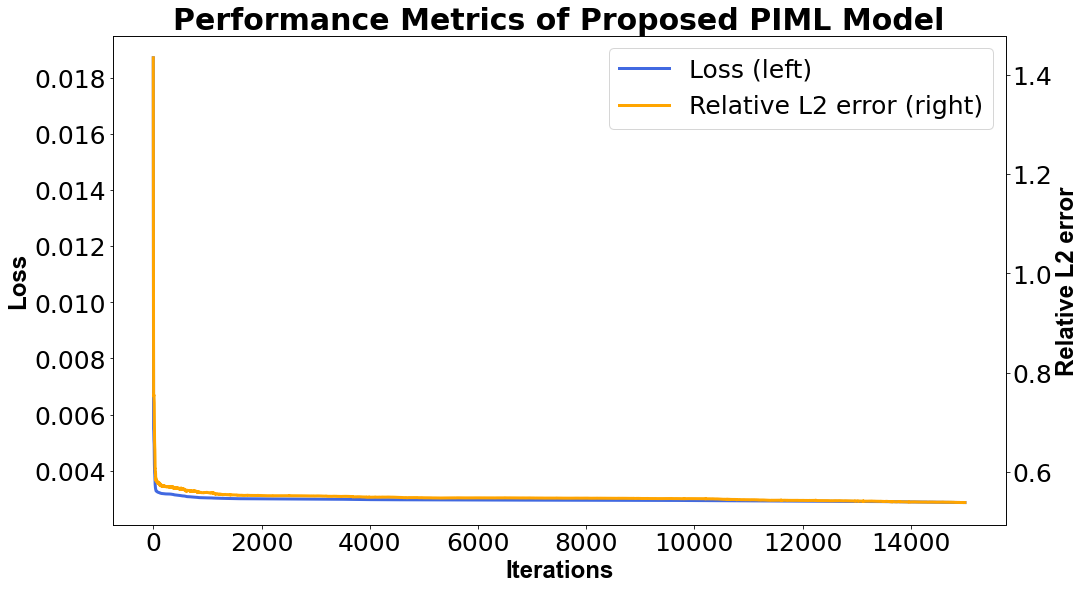

In [17]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax2 = ax1.twinx()
line1 = ax1.plot(loss_record, linewidth = '3', color = "royalblue", label='Loss (left)')
line2 = ax2.plot(l2_record, linewidth = '3', color = "orange", label='Relative L2 error (right)')
lines = line1 + line2
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')
plt.title("Performance Metrics of Proposed PIML Model", fontsize=30, fontweight="bold")
ax1.set_xlabel("Iterations", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Loss", fontsize=24, fontname = 'Arial', fontweight="bold")
ax2.set_ylabel("Relative L2 error", fontsize=24, fontname = 'Arial', fontweight="bold")
fig.set_size_inches(16, 9)

# 전체 그리드 비교

In [18]:
u_pred = PINN.evaluate(X_u_grid)
u_pred = np.reshape(u_pred,usol.shape,order='F')

y_test = usol
y_pred = u_pred

error_vec = np.linalg.norm((y_test-y_pred),2)/np.linalg.norm(y_test,2)

print('MAE = ', mean_absolute_error(y_test, y_pred))
print('MSE = ', mean_squared_error(y_test, y_pred) )
print('RMSE = ', np.sqrt(mean_squared_error(y_test, y_pred)))
print('L2 relative error =', error_vec)
print('--------------------------------------------------')

MAE =  0.020750735643050508
MSE =  0.002751529547685488
RMSE =  0.05245502404618158
L2 relative error = 0.5026539273108105
--------------------------------------------------


Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

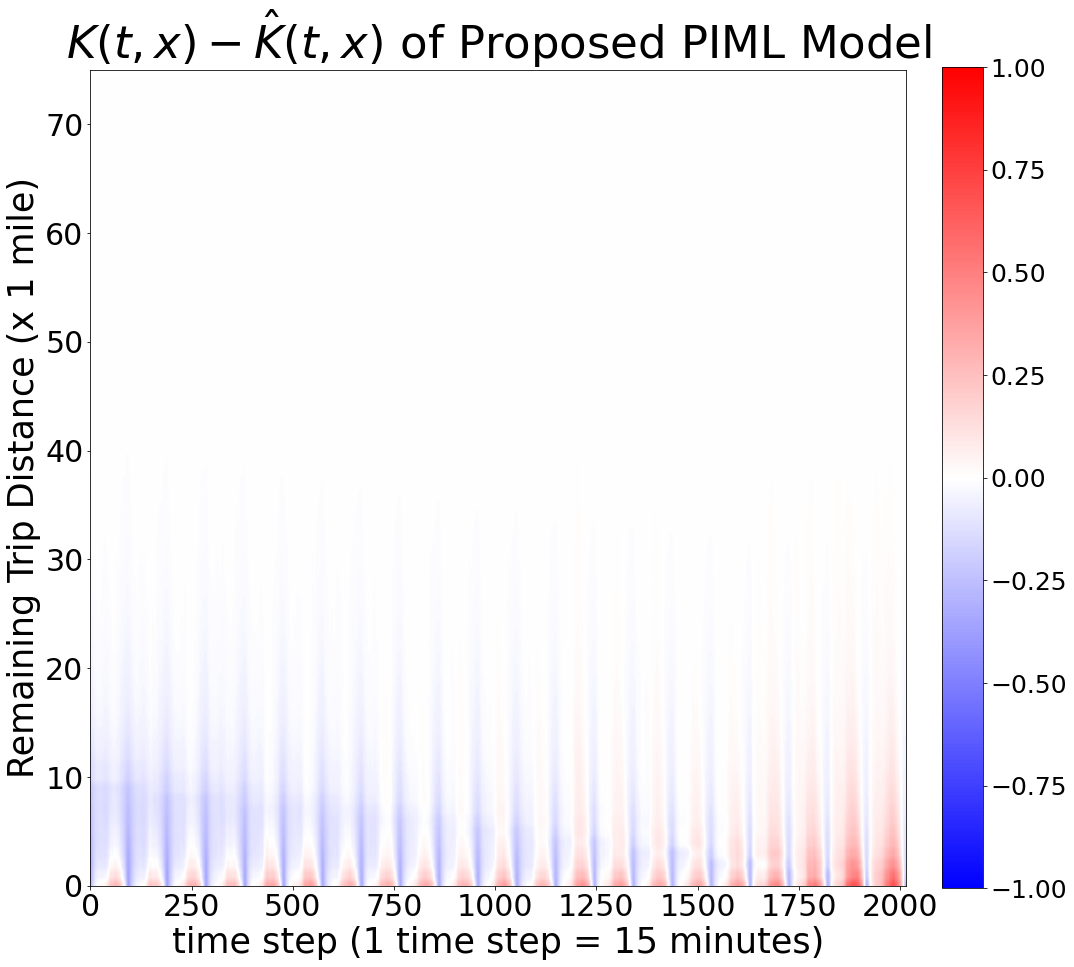

In [19]:
K_array = np.array(u_pred)
K_array = (usol - K_array)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$K(t,x)- \hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)

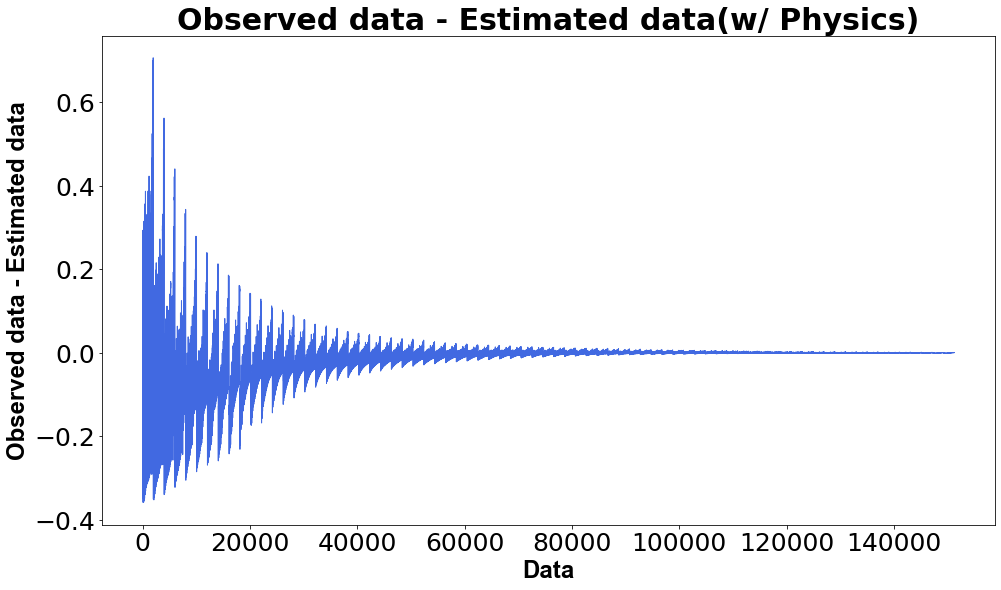

In [20]:
fig, ax1 = plt.subplots()
ax1 = plt.gca() 
ax1.set_facecolor('white')
ax1.plot(K_array.flatten(), linewidth = '1', color = "royalblue", label='Loss (left)')
plt.title("Observed data - Estimated data(w/ Physics)", fontsize=30, fontweight="bold")
ax1.set_xlabel("Data", fontsize=24, fontname = 'Arial', fontweight="bold")
ax1.set_ylabel("Observed data - Estimated data", fontsize=24, fontname = 'Arial', fontweight="bold")

fig.set_size_inches(16, 9)

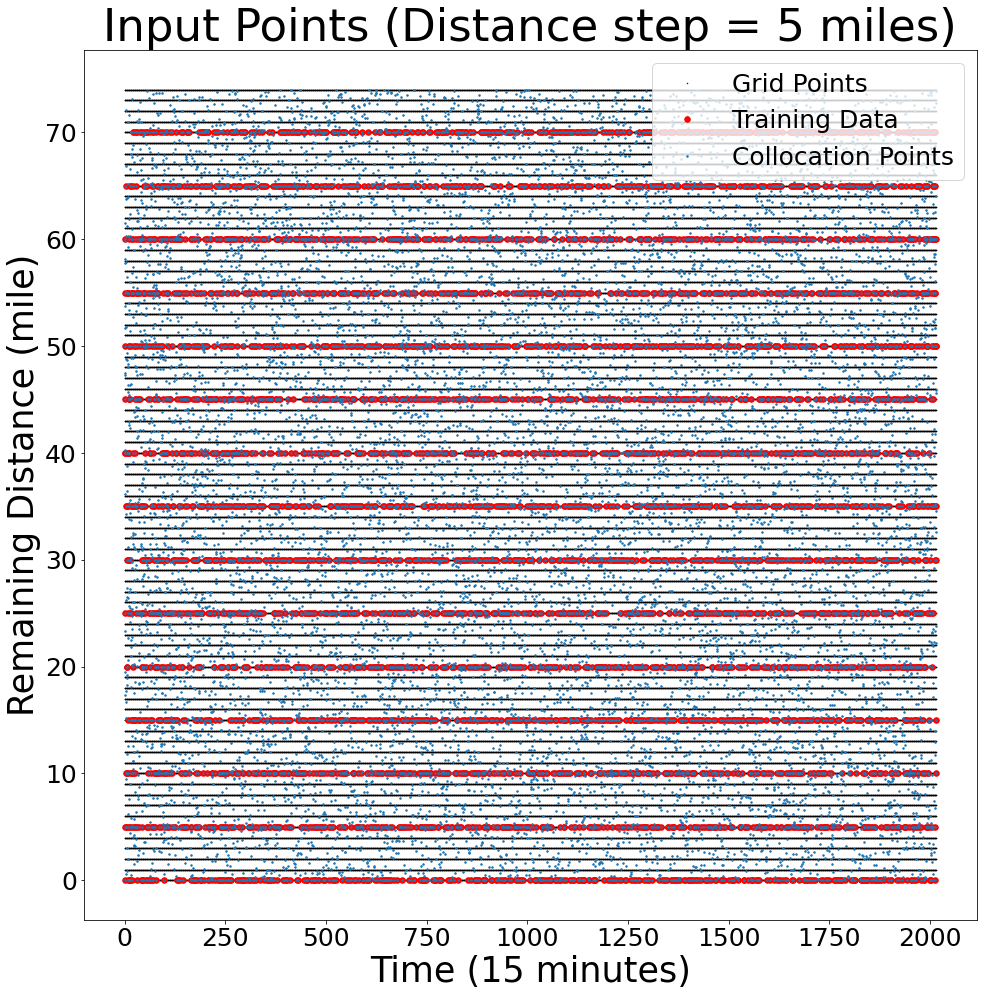

In [21]:
fig,ax = plt.subplots(figsize=(16, 16))
plt.plot(X_u_grid[:,1]*multiplier_time, X_u_grid[:,0]*multiplier_dist, 'o', color = 'black', markersize = 0.5, label = 'Grid Points')
plt.plot(X_u_train[:,1]*multiplier_time, X_u_train[:,0]*multiplier_dist, 'o', color = 'red', markersize = 5.5, label = 'Training Data')
plt.plot(X_f_train[:,1]*multiplier_time, X_f_train[:,0]*multiplier_dist, 'o', markersize = 1.5, label = 'Collocation Points')

plt.rcParams['font.size'] = '25'
plt.xlabel('Time (15 minutes)', fontsize=35)
plt.ylabel('Remaining Distance (mile)', fontsize=35)
plt.title('Input Points (Distance step = 5 miles)', fontsize=45)
plt.legend(loc='upper right')
plt.show()

Text(0, 0.5, 'Remaining Trip Distance (x 1 mile)')

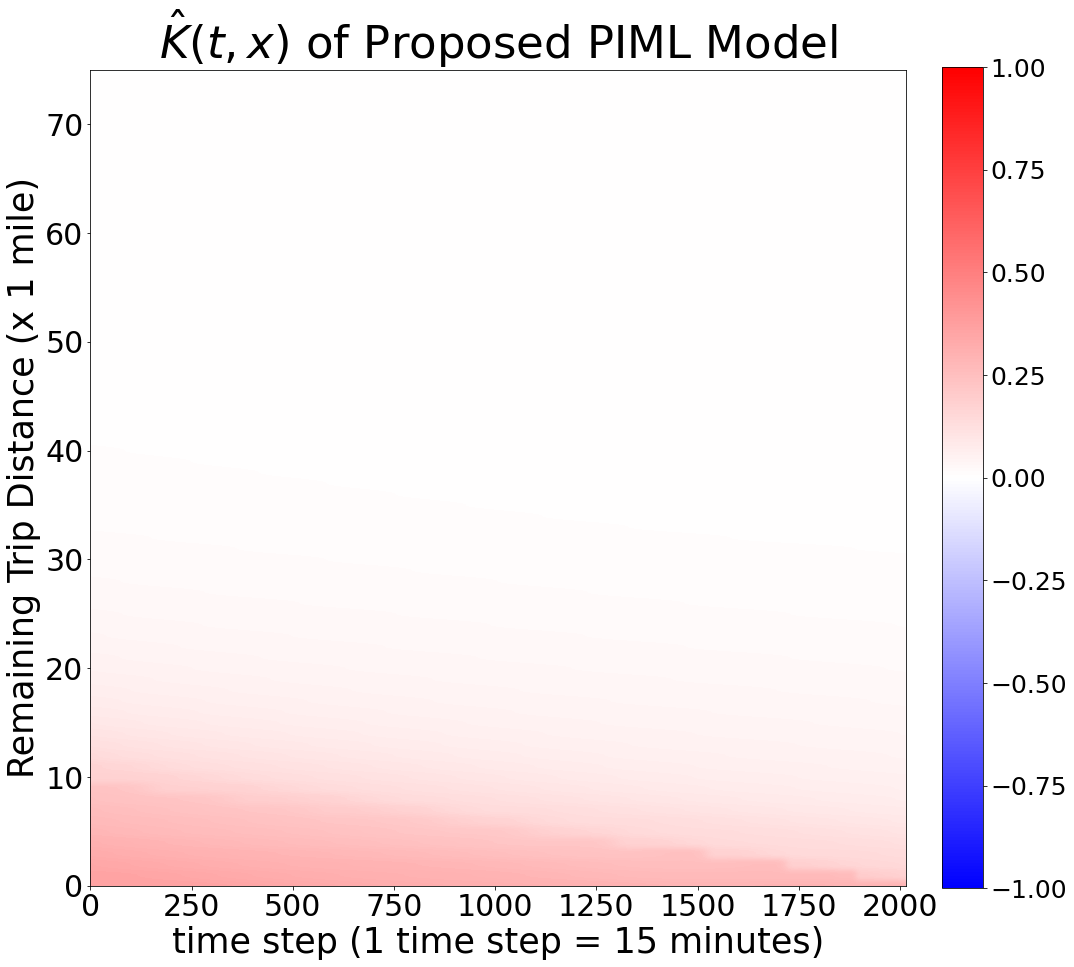

In [22]:
K_array = np.array(u_pred)

fig, ax = plt.subplots(figsize=(16, 16))
plt.rcParams['font.size'] = '25'
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontsize(30)
plt.imshow(K_array.transpose().T, cmap = 'bwr')
plt.colorbar(fraction=0.046, pad=0.04)
plt.axis([0,2016,0,75])
plt.clim(-1, 1) 
ax.set_aspect(1.0/ax.get_data_ratio(), adjustable='box')
plt.title(r'$\hat{K}(t,x)$' ' of Proposed PIML Model', fontsize=45)
plt.xlabel('time step (1 time step = 15 minutes)', fontsize=35)
plt.ylabel('Remaining Trip Distance (x 1 mile)', fontsize=35)